# 1. Introduction

Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders. Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities. While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful. 

Home credit has provided client’s loan application details, their previous loan information, transaction details and also the available previous loan details from the other financial institutes. Based on this certain snapshot of transactional data and the details provided by client in loan application can we predict if the client will be having difficulties of repaying the loan. 

## 2. ML formulation of business problem: 

Building a machine learning model to predict if an applicant is capable of replaying the loan or not. Based on the information the applicants data the model should filter out the applicant so that Home-credit can sanction the loan .The objective of the Model is a classification task , where it should able to predict if any applicant can repay the loan with a high probability as the cost of misclassification is very high. Interpretability is important , so it will be good if the model also can give some mode of feature importance. 

## 3. Data Description

The data for the below datasets can be downloaded from <a href ='https://www.kaggle.com/c/home-credit-default-risk/data'>here</a>. 

application_{train|test}.csv 

This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET). Static data for all applications. One row represents one loan in our data sample.  

Total no of columns:122 

Below is snapshot of the data: 

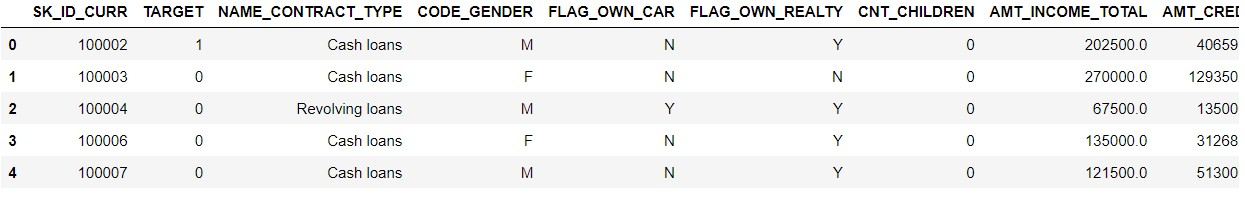 

bureau.csv 

All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample). For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date. 

Total no of columns:17 

Below is snapshot of the data: 

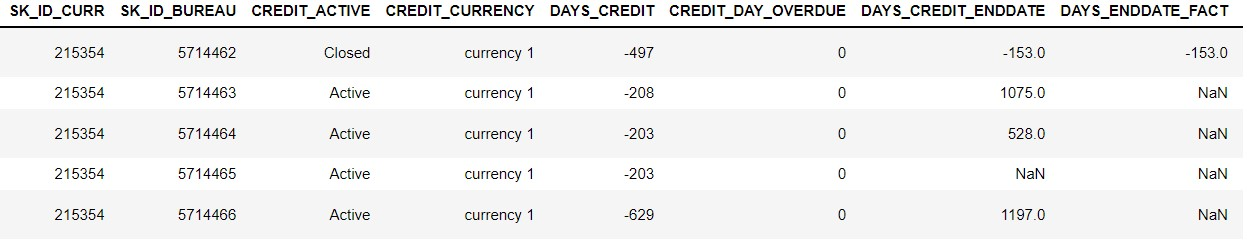

bureau_balance.csv 

Monthly balances of previous credits in Credit Bureau. This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample # of relative previous credits # of months where we have some history observable for the previous credits) rows. 

Total no of columns:3 

Below is snapshot of the data: 

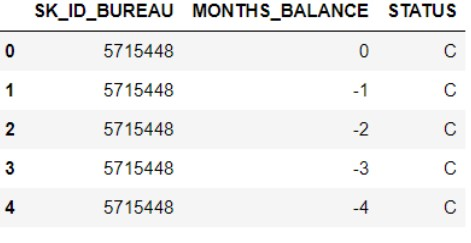

POS_CASH_balance.csv 

Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit. This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample # of relative previous credits # of months in which we have some history observable for the previous credits) rows. 

Total no of columns:8 

Below is snapshot of the data: 

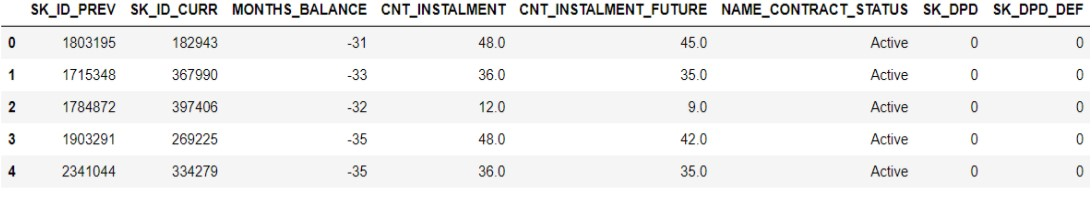

credit_card_balance.csv 

Monthly balance snapshots of previous credit cards that the applicant has with Home Credit. This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample # of relative previous credit cards # of months where we have some history observable for the previous credit card) rows. 

Total no of columns: 23 

Below is snapshot of the data: 

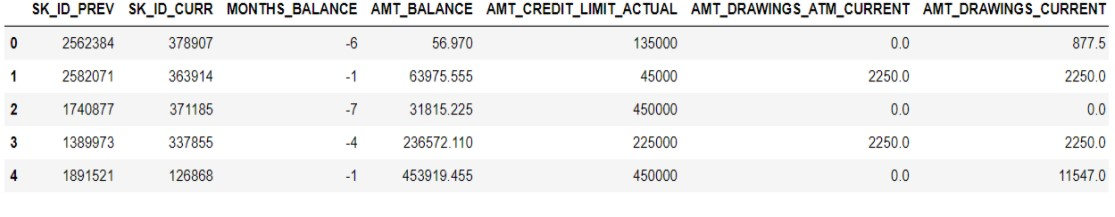 

previous_application.csv 

All previous applications for Home Credit loans of clients who have loans in our sample. There is one row for each previous application related to loans in our data sample. 

Total no of columns:37 

Below is snapshot of the data: 

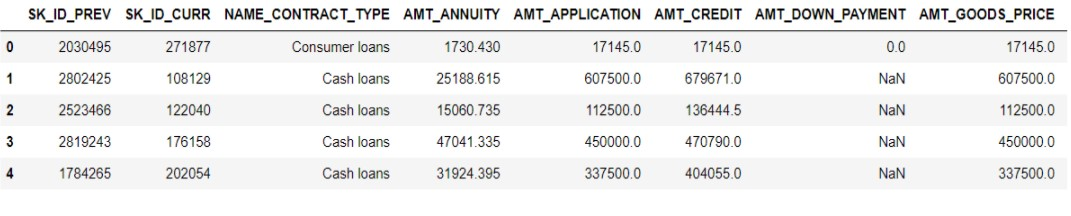 

installments_payments.csv 

Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample. There is a) one row for every payment that was made plus b) one row each for missed payment. One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample. 

Total no of columns:8 

Below is snapshot of the data: 

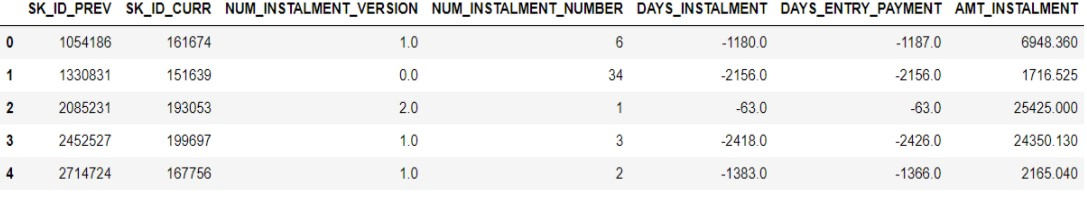 

<a href='https://drive.google.com/file/d/16C_hmV9m4lFfoR49PCWJxvbuWb1Nd85G/view'>HomeCredit_columns_description.csv</a>

This file contains descriptions for all the columns of the above files. Total 218 columns descriptions. 

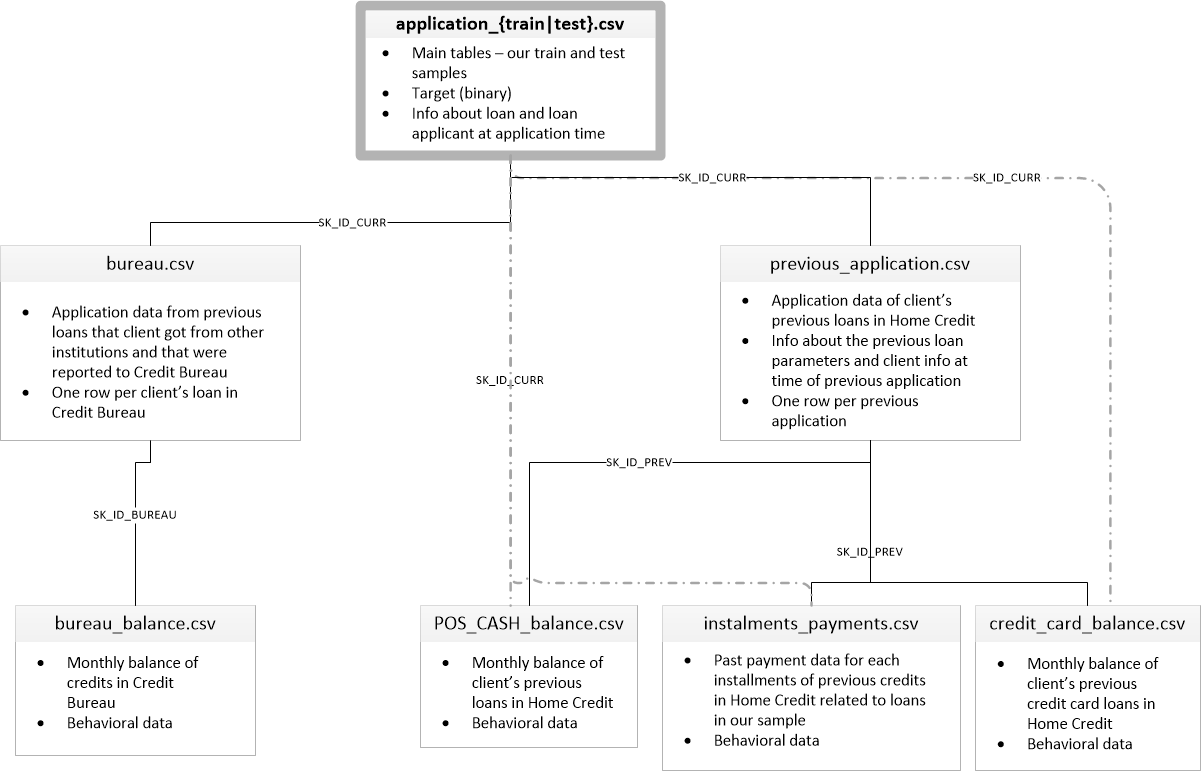

## 4. Business constraints: 


There is no strict latency requirement. We ca take a certain time to predict if the loan should be sanctioned or not. So we can build more complex models to solve our problem. 

## 5. Importing Libraries

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from scipy import stats
from tqdm import tqdm
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from chart_studio.plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter
import gc
import warnings
warnings.filterwarnings("ignore")

## 6. Reading Data

In [2]:
#all files have been saved under this root directory
root_dir='D:/AAIC dataset/self case study 1'
os.listdir(root_dir)

['application_test.csv',
 'application_train.csv',
 'bureau.csv',
 'bureau_balance.csv',
 'bureau_balance_agg.csv',
 'credit_card_balance.csv',
 'final_test.csv',
 'final_train.csv',
 'HomeCredit_columns_description.csv',
 'installments_payments.csv',
 'installments_payments_agg.csv',
 'joined_previous_application_app_test.csv',
 'joined_previous_application_app_train.csv',
 'POS_CASH_balance.csv',
 'previous_application.csv',
 'previous_application_agg.csv',
 'sample_submission.csv']

In [3]:
#storing the files in dataframe for further analysis
application_test = pd.read_csv(os.path.join(root_dir,'application_test.csv'))
application_train = pd.read_csv(os.path.join(root_dir,'application_train.csv'))
bureau = pd.read_csv(os.path.join(root_dir,'bureau.csv'))
bureau_balance = pd.read_csv(os.path.join(root_dir,'bureau_balance.csv'))
credit_card_balance = pd.read_csv(os.path.join(root_dir,'credit_card_balance.csv'))
installments_payments = pd.read_csv(os.path.join(root_dir,'installments_payments.csv'))
POS_CASH_balance = pd.read_csv(os.path.join(root_dir,'POS_CASH_balance.csv'))
previous_application = pd.read_csv(os.path.join(root_dir,'previous_application.csv'))


# 7. application_train data analysis

## 7.1 Shape of the Datasets

In [83]:
print("Shape of application train: ",application_train.shape)
print("Shape of application test: ",application_test.shape)

Shape of application train:  (307511, 122)
Shape of application test:  (48744, 121)


<h3><u>Observation:</u></h3><br>
There are total 121 columns and based on that we need to predict the dependent feature 'TARGET' which consists 1,0 value.<br>
1: client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan.(Defaulter)<br>
0:other cases(Non-defaulter) 

## 7.2 snapshot of application train data

In [84]:
application_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

              ...              FLAG_DOCUMENT_18 FLAG_DOCUMENT_19  \
0             ...                             0                0   
1             ...                             0                0   
2             ...                             0                0   
3             ...                             0                0   
4             ...                             0                0   

  FLAG_DOCUMENT_20 FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR  \
0                0                0                        0.0   
1                0                0                        0.0   
2                0                0                        0.0   
3                0                0                        NaN   
4                0                0                        0.0   

  AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_WEEK  \
0                       0.0                         0.0   
1                       0.0                         0.0   
2                       0.0                         0.0   
3                       NaN                         NaN   
4                       0.0                         0.0   

   AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        NaN                        NaN   
4                        0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_YEAR  
0                         1.0  
1                         0.0  
2                         0.0  
3                         NaN  
4                         0.0  

[5 rows x 122 columns]

In [85]:
application_test.head()

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

              ...             FLAG_DOCUMENT_18 FLAG_DOCUMENT_19  \
0             ...                            0                0   
1             ...                            0                0   
2             ...                            0                0   
3             ...                            0                0   
4             ...                            0                0   

  FLAG_DOCUMENT_20 FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR  \
0                0                0                        0.0   
1                0                0                        0.0   
2                0                0                        0.0   
3                0                0                        0.0   
4                0                0                        NaN   

   AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_WEEK  \
0                        0.0                         0.0   
1                        0.0                         0.0   
2                        0.0                         0.0   
3                        0.0                         0.0   
4                        NaN                         NaN   

   AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        1.0   
3                        0.0                        0.0   
4                        NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_YEAR  
0                         0.0  
1                         3.0  
2                         4.0  
3                         3.0  
4                         NaN  

[5 rows x 121 columns]

## 7.3 name of all the 121 features

In [7]:
application_train.columns.values

array(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3',

We Have 121 features and dependent feature 'TARGET' in the train data that we want to predict

In [8]:
print("Unique values in train data SK_ID_CURR: ",len(application_train["SK_ID_CURR"].unique()))
print("Unique values in test data SK_ID_CURR: ",len(application_test["SK_ID_CURR"].unique()))

Unique values in train data SK_ID_CURR:  307511
Unique values in test data SK_ID_CURR:  48744


There is no duplicate value for the primary key: 'SK_ID_CURR' in both train/test data, We want to predict the probablity of the 'TARGET' class labels in the application_test datset against each 'SK_ID_CURR'

## 7.4 The dependent feature - 'TARGET' class label Analysis

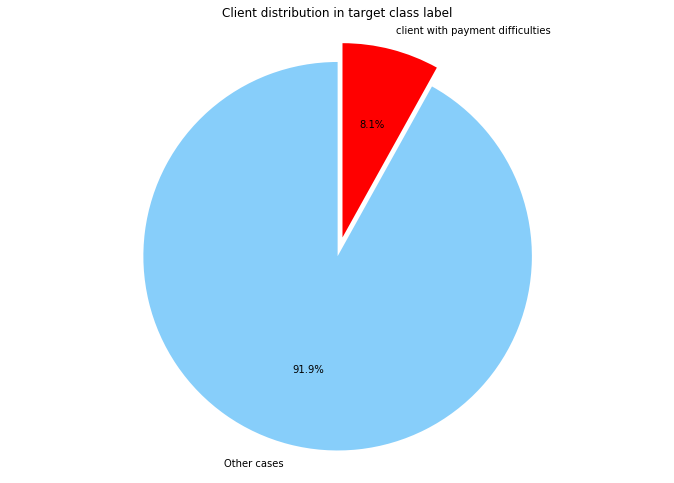

No of clients with payment difficulties: 24825
No of clients with other cases: 282686


In [23]:
#no of clients with loan repaying difficulty
clients_label_1=len(application_train[application_train['TARGET']==1].values)
clients_label_0=len(application_train[application_train['TARGET']==0].values)

#https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_features.html
plt.figure(figsize=(11.7,8.27))
clients_label_list=[clients_label_0,clients_label_1]
labels = ['Other cases','client with payment difficulties']
colors = ['lightskyblue', 'red']
explode =(0,0.1)
#plotting the pie chart
plt.pie(clients_label_list, explode = explode,labels= labels, \
        colors=colors, startangle=90, autopct='%.1f%%')
plt.axis('equal')
plt.title("Client distribution in target class label")
plt.show()
print("No of clients with payment difficulties:",clients_label_1)
print("No of clients with other cases:",clients_label_0)

<h3><u>Observation:</u></h3><br>
client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan has been assigned with class label 1 and for the other cases clients class label 0 has been assigned.

Data is highly imbalanced with 91.9% client repaid the loan successfully where 8% clients had difficulties to repaid the loan.As for this classification task we need to choose following performance metrics to properly predict for the both class label with high probablity.

Most of the clients have successfully repayed the loan, only 8.1 clients have been defaulters. Based on the given feature we have to predict this class label.

## 7.5 Performance metric:  

As this is a classification task and have imbalance dataset with class label ratio of 49:4.So F1-score, Confusion matrix and AUC will be a good metric to evaluate the model performance.  

## 7.6 Univariate analysis on the given features

In [10]:
#Separating the classes for further analysis
application_train_1=application_train.loc[application_train['TARGET']==1]
application_train_0=application_train.loc[application_train['TARGET']==0]


## 7.6.1 Missing value Statistics on the 122 features present in the train data

In [22]:
#https://www.kaggle.com/shaz13/clever-codes-in-place-do-it-swiftly
#getting info about data type, unique value present, no of missing value
def miss_value(data):
    miss_value_df = pd.DataFrame({'dtype': data.dtypes, 'Unique values': data.nunique() ,
                 'Number of missing values': data.isnull().sum() ,
                  'Percentage missing': (data.isnull().sum() / len(data)) * 100
                 }).sort_values(by='Number of missing values', ascending = False)
    return miss_value_df

In [12]:
#checking the information about application train features
miss_value(application_train).head(20)

dtype  Unique values  Number of missing values  \
COMMONAREA_MEDI           float64           3202                    214865   
COMMONAREA_AVG            float64           3181                    214865   
COMMONAREA_MODE           float64           3128                    214865   
NONLIVINGAPARTMENTS_MODE  float64            167                    213514   
NONLIVINGAPARTMENTS_AVG   float64            386                    213514   
NONLIVINGAPARTMENTS_MEDI  float64            214                    213514   
FONDKAPREMONT_MODE         object              4                    210295   
LIVINGAPARTMENTS_MODE     float64            736                    210199   
LIVINGAPARTMENTS_AVG      float64           1868                    210199   
LIVINGAPARTMENTS_MEDI     float64           1097                    210199   
FLOORSMIN_AVG             float64            305                    208642   
FLOORSMIN_MODE            float64             25                    208642   
FLOORSMIN_MEDI            float64             47                    208642   
YEARS_BUILD_MEDI          float64            151                    204488   
YEARS_BUILD_MODE          float64            154                    204488   
YEARS_BUILD_AVG           float64            149                    204488   
OWN_CAR_AGE               float64             62                    202929   
LANDAREA_MEDI             float64           3560                    182590   
LANDAREA_MODE             float64           3563                    182590   
LANDAREA_AVG              float64           3527                    182590   

                          Percentage missing  
COMMONAREA_MEDI                    69.872297  
COMMONAREA_AVG                     69.872297  
COMMONAREA_MODE                    69.872297  
NONLIVINGAPARTMENTS_MODE           69.432963  
NONLIVINGAPARTMENTS_AVG            69.432963  
NONLIVINGAPARTMENTS_MEDI           69.432963  
FONDKAPREMONT_MODE                 68.386172  
LIVINGAPARTMENTS_MODE              68.354953  
LIVINGAPARTMENTS_AVG               68.354953  
LIVINGAPARTMENTS_MEDI              68.354953  
FLOORSMIN_AVG                      67.848630  
FLOORSMIN_MODE                     67.848630  
FLOORSMIN_MEDI                     67.848630  
YEARS_BUILD_MEDI                   66.497784  
YEARS_BUILD_MODE                   66.497784  
YEARS_BUILD_AVG                    66.497784  
OWN_CAR_AGE                        65.990810  
LANDAREA_MEDI                      59.376738  
LANDAREA_MODE                      59.376738  
LANDAREA_AVG                       59.376738

Observation:

Most of the above top 20 features with most missing values have missing more than 59% of the data, need to come up with filling missing value strategies, if they have any significat feature importance , otherwise we can drop them.

## 7.6.2 All the categorical columns

In [5]:
#name of the categorigal features
application_train.select_dtypes('object').columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')

## 7.6.3 Feature Importance of all the 121 features

In [75]:
#making a copy of the original dataset for preprocessing 
application_train_temp=application_train.copy()
#converting the categorical column to one hot encoding
cat_feature_list=application_train_temp.select_dtypes('object').columns.values
for i in cat_feature_list:
    application_train_temp[i]=pd.get_dummies(application_train_temp[i])


In [76]:
#dropping label and ID columns to create traing data
train_columns=application_train_temp.drop(columns=['TARGET','SK_ID_CURR'],axis=1).columns.values
#filling nan values
application_train_temp=application_train_temp.fillna(0)
#Dropping the dependent feature
X_train=application_train_temp.drop(columns=['TARGET','SK_ID_CURR'],axis=1)
#storing the class label data
y_train=application_train_temp.TARGET


In [77]:
#Shape of train data
X_train.shape

(307511, 120)

## 7.6.3.1 Applying Normalization 

In [78]:
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html
#this will normalize the numerical features ignoring the outliers
scaler = RobustScaler()
#fitting on the train data
X_train = scaler.fit_transform(X_train)

## 7.6.3.2 Applying Random Forrest to get the fetaure Importance score

In [79]:
#fitting train data with random forest with 100 n_estimator to get feature importance
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=0)

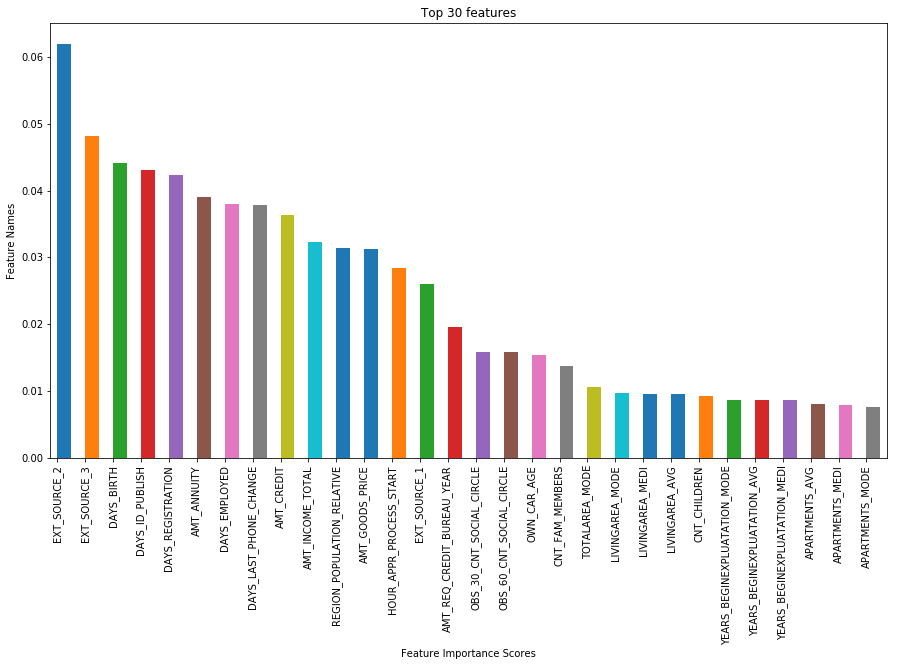

The top 10 feature names and their importance scores :


EXT_SOURCE_2              0.061946
EXT_SOURCE_3              0.048114
DAYS_BIRTH                0.044173
DAYS_ID_PUBLISH           0.043053
DAYS_REGISTRATION         0.042338
AMT_ANNUITY               0.038998
DAYS_EMPLOYED             0.038013
DAYS_LAST_PHONE_CHANGE    0.037874
AMT_CREDIT                0.036326
AMT_INCOME_TOTAL          0.032380
dtype: float64


In [80]:
#Plotting the top 15 features ascending order according to their feature importance score
plt.figure(figsize=(15,8))
#taking only the top 10 feature
feature_importance= pd.Series(clf.feature_importances_, index=train_columns).sort_values(ascending=False).head(30)
#plotting barplot 
feature_importance.plot(kind='bar',align='edge',orientation='vertical')
plt.title("Top 30 features")
plt.ylabel("Feature Names")
plt.xlabel("Feature Importance Scores")
plt.show()
#the top 10 features ascending order according to their feature importance score
print("The top 10 feature names and their importance scores :\n\n")
print(feature_importance.head(10))

<h3><u>Observation:</u></h3><br>
We will look into this top 10 feature data analysis for futher insights and how these features are impacting the clients behaviour regarding loan repaying

## 7.6.4 Data Analysis on the features 

<h2> 7.6.4.1 Univariate Analysis of EXT_SOURCE_1</h2><br>
EXT_SOURCE_1: Normalized score from external data source


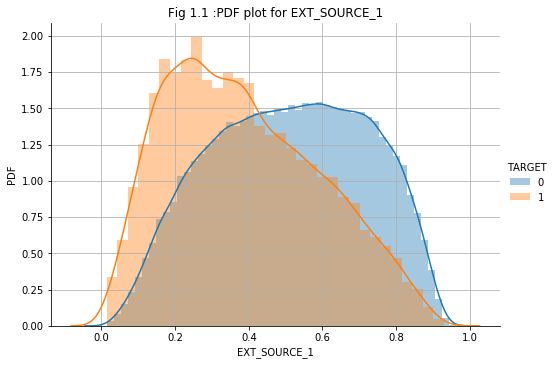

In [86]:
#plotting density plot
sns.FacetGrid(data=application_train, hue='TARGET', height=5, aspect=10/7).map(sns.distplot, 'EXT_SOURCE_1').add_legend()
plt.title('Fig 1.1 :PDF plot for EXT_SOURCE_1')
plt.xlabel('EXT_SOURCE_1')
plt.ylabel('PDF')
plt.grid()
plt.show()

<h3><u>Observation from Fig 1.1:</u></h3><br>
The values are normalized and lie between (0 and 1)
clients with 'EXT_SOURCE_1'<=0.4 tends to have more difficulty in loan repaying.

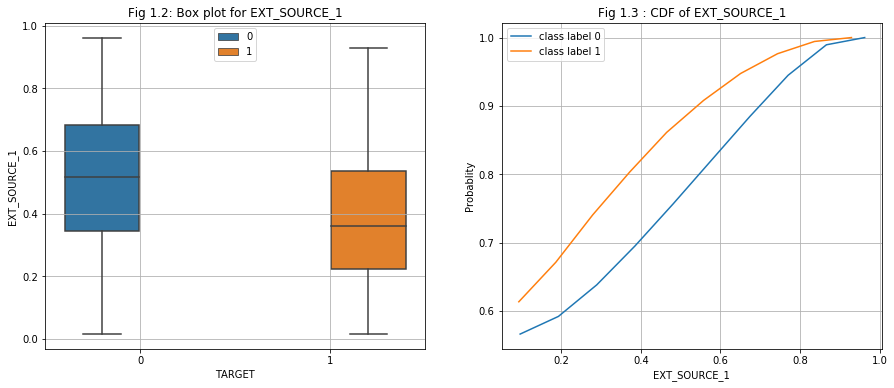

In [108]:
#plotting box plots
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.boxplot( x='TARGET', y='EXT_SOURCE_1',hue='TARGET', data=application_train)
plt.legend(loc='upper center')
plt.title('Fig 1.2: Box plot for EXT_SOURCE_1')
plt.grid()
#plotting the CDF of both class labels
plt.subplot(1,2,2)
counts, bin_edges = np.histogram(application_train[application_train['TARGET']==0]['EXT_SOURCE_1'].fillna(0), \
                                 bins=10,density = True)
pdf = counts/(sum(counts))
cdf = np.cumsum(pdf)
plt.plot(bin_edges[1:], cdf)
counts, bin_edges = np.histogram(application_train[application_train['TARGET']==1]['EXT_SOURCE_1'].fillna(0), \
                                 bins=10,density = True)
pdf = counts/(sum(counts))
cdf = np.cumsum(pdf)
plt.plot(bin_edges[1:], cdf)
plt.legend(['class label 0','class label 1'])
plt.xlabel('EXT_SOURCE_1')
plt.ylabel('Probablity')
plt.title("Fig 1.3 : CDF of EXT_SOURCE_1")
plt.grid()
plt.show()

<h3><u>Observation from Fig 1.2:</u></h3><br>
the 50-75% precentile value of 'EXT_SOURCE_1' of class label 0 more than the 75% value of class label 1<br>
the 25-50% precentile value of 'EXT_SOURCE_1' of class label 1 less than the 25% value of class label 0

<h3><u>Observation from Fig 1.3:</u></h3><br>
90% values are below 0.7 for class label 0<br>
90% values are below 0.58 for class label 1

<h2> 7.6.4.2 Univariate Analysis of EXT_SOURCE_2</h2><br>
EXT_SOURCE_2: Normalized score from external data source


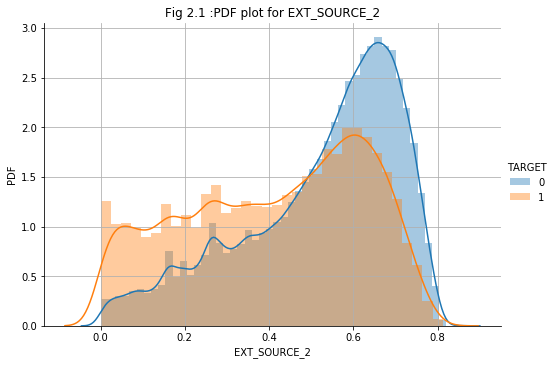

In [88]:
#plotting density plot
sns.FacetGrid(data=application_train, hue='TARGET', height=5, aspect=10/7).map(sns.distplot, 'EXT_SOURCE_2').add_legend()
plt.title('Fig 2.1 :PDF plot for EXT_SOURCE_2')
plt.xlabel('EXT_SOURCE_2')
plt.ylabel('PDF')
plt.grid()
plt.show()

<h3><u>Observation from Fig 2.1:</u></h3><br>
The values are normalized and lie between (0 and 1)
clients with 'EXT_SOURCE_2'>0.5 are more likely to repay the loan successfully

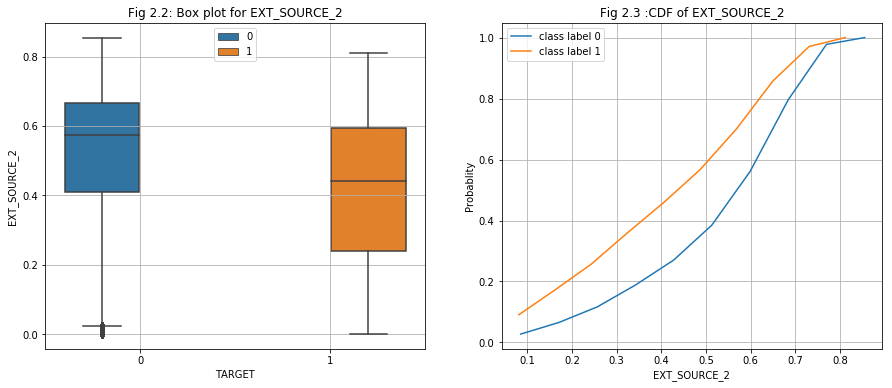

In [109]:
#plotting box plots
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.boxplot( x='TARGET', y='EXT_SOURCE_2',hue='TARGET', data=application_train)
plt.legend(loc='upper center')
plt.title('Fig 2.2: Box plot for EXT_SOURCE_2')
plt.grid()

#plotting the CDF of both class labels
plt.subplot(1,2,2)
counts, bin_edges = np.histogram(application_train[application_train['TARGET']==0]['EXT_SOURCE_2'].fillna(0), \
                                 bins=10,density = True)
pdf = counts/(sum(counts))
cdf = np.cumsum(pdf)
plt.plot(bin_edges[1:], cdf)
counts, bin_edges = np.histogram(application_train[application_train['TARGET']==1]['EXT_SOURCE_2'].fillna(0), \
                                 bins=10,density = True)
pdf = counts/(sum(counts))
cdf = np.cumsum(pdf)
plt.plot(bin_edges[1:], cdf)
plt.legend(['class label 0','class label 1'])
plt.xlabel('EXT_SOURCE_2')
plt.ylabel('Probablity')
plt.title("Fig 2.3 :CDF of EXT_SOURCE_2")
plt.grid()
plt.show()

<h3><u>Observation from Fig 2.2:</u></h3><br>
the 50-75% precentile value of 'EXT_SOURCE_2' of class label 0 more than the 75% value of class label 1


<h3><u>Observation from Fig 2.3:</u></h3><br>
60% values are below 0.61 for class label 0<br>
60% values are below 0.5 for class label 1<br>
Their is gap for the 2 labels ,label 1 is lower side than label 0 

<h2> 7.6.4.3 Univariate Analysis of EXT_SOURCE_3</h2><br>
EXT_SOURCE_3: Normalized score from external data source


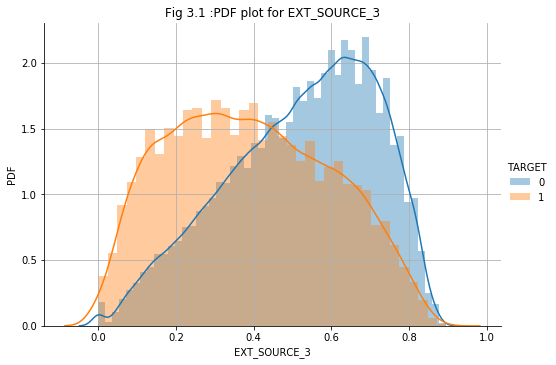

In [90]:
#plotting density plot
sns.FacetGrid(data=application_train, hue='TARGET', height=5, aspect=10/7).map(sns.distplot, 'EXT_SOURCE_3').add_legend()
plt.title('Fig 3.1 :PDF plot for EXT_SOURCE_3')
plt.xlabel('EXT_SOURCE_3')
plt.ylabel('PDF')
plt.grid()
plt.show()

<h3><u>Observation from Fig 3.1:</u></h3><br>
The values are normalized and lie between (0 and 1)
clients with 'EXT_SOURCE_3'>0.5 are more likely to repay the loan successfully and 
clients with 'EXT_SOURCE_3'<0.5 have faced difficulty repaying the loan

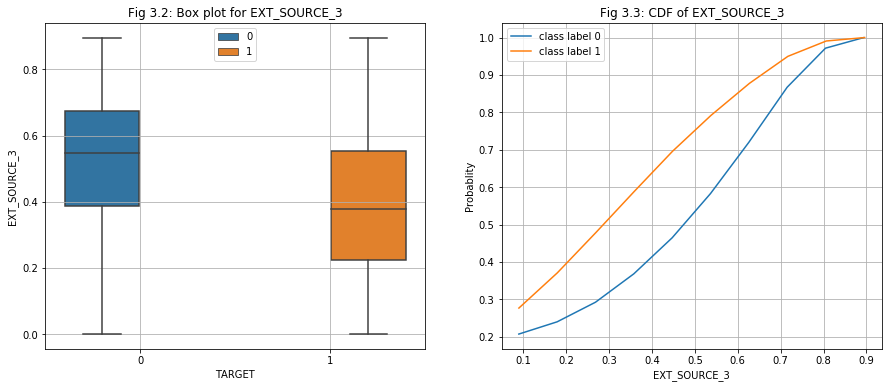

In [110]:
#plotting box plots
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.boxplot( x='TARGET', y='EXT_SOURCE_3',hue='TARGET', data=application_train)
plt.legend(loc='upper center')
plt.title('Fig 3.2: Box plot for EXT_SOURCE_3')
plt.grid()
#plotting the CDF of both class labels
plt.subplot(1,2,2)
counts, bin_edges = np.histogram(application_train[application_train['TARGET']==0]['EXT_SOURCE_3'].fillna(0), \
                                 bins=10,density = True)
pdf = counts/(sum(counts))
cdf = np.cumsum(pdf)
plt.plot(bin_edges[1:], cdf)
counts, bin_edges = np.histogram(application_train[application_train['TARGET']==1]['EXT_SOURCE_3'].fillna(0), \
                                 bins=10,density = True)
pdf = counts/(sum(counts))
cdf = np.cumsum(pdf)
plt.plot(bin_edges[1:], cdf)
plt.legend(['class label 0','class label 1'])
plt.xlabel('EXT_SOURCE_3')
plt.ylabel('Probablity')
plt.title("Fig 3.3: CDF of EXT_SOURCE_3")
plt.grid()
plt.show()

<h3><u>Observation from Fig 3.2:</u></h3><br>
the 50-75% precentile value of 'EXT_SOURCE_3' of class label 0 more than the 75% value of class label 1<br>
the 25-50% precentile value of 'EXT_SOURCE_3' of class label 1 less than the 25% value of class label 0

<h3><u>Observation from Fig 3.3:</u></h3><br>
80% values are below 0.68 for class label 0<br>
80% values are below 0.55 for class label 1<br>
Their is gap for the 2 labels ,label 1 is lower side than label 0 

<h2> 7.6.4.4 Univariate Analysis of DAYS_BIRTH</h2><br>
DAYS_BIRTH: Client's age in days at the time of application


In [92]:
#converting DAYS_BIRTH to year to get the client's age
application_train['AGE']=application_train['DAYS_BIRTH']/-365

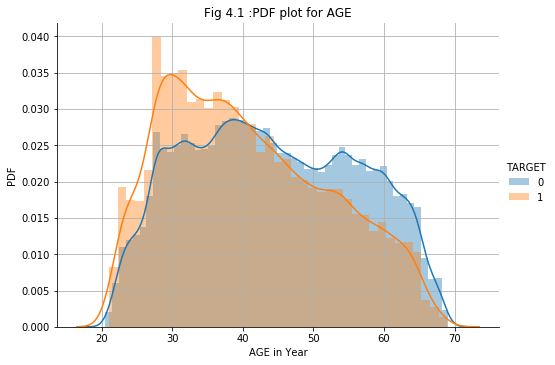

In [93]:
#plotting density plot
sns.FacetGrid(data=application_train, hue='TARGET', height=5, aspect=10/7).map(sns.distplot, 'AGE').add_legend()
plt.title('Fig 4.1 :PDF plot for AGE')
plt.xlabel('AGE in Year')
plt.ylabel('PDF')
plt.grid()
plt.show()

<h3><u>Observation from Fig 4.1:</u></h3><br>
Younger clients with age <40 and around 30 the density has been very high for class label 1 <br>
have been facing difficulty to repay the loan

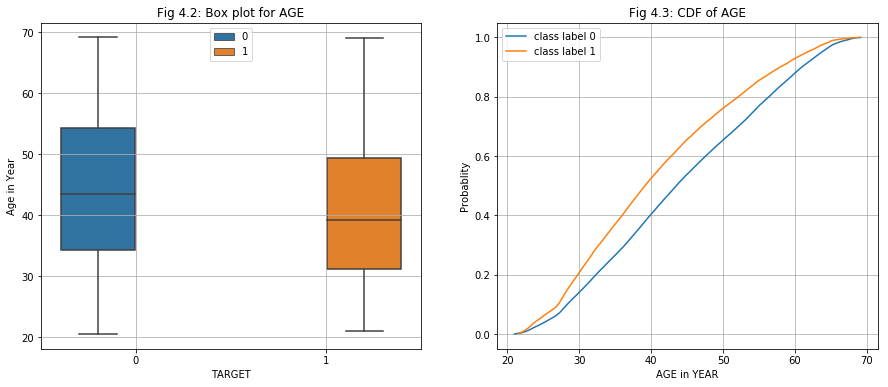

In [111]:
#plotting box plots
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.boxplot( x='TARGET', y='AGE',hue='TARGET', data=application_train)
plt.legend(loc='upper center')
plt.ylabel('Age in Year')
plt.title('Fig 4.2: Box plot for AGE')
plt.grid()
#plotting the CDF of both class labels
plt.subplot(1,2,2)
counts, bin_edges = np.histogram(application_train[application_train['TARGET']==0]['AGE'].fillna(0), \
                                 bins=100,density = True)
pdf = counts/(sum(counts))
cdf = np.cumsum(pdf)
plt.plot(bin_edges[1:], cdf)
counts, bin_edges = np.histogram(application_train[application_train['TARGET']==1]['AGE'].fillna(0), \
                                 bins=100,density = True)
pdf = counts/(sum(counts))
cdf = np.cumsum(pdf)
plt.plot(bin_edges[1:], cdf)
plt.legend(['class label 0','class label 1'])
plt.xlabel('AGE in YEAR')
plt.ylabel('Probablity')
plt.title("Fig 4.3: CDF of AGE")
plt.grid()
plt.show()

<h3><u>Observation from Fig 4.2:</u></h3><br>
The 25-50% range is lower for class label 1 than class 0.
For label 0 the 50% value is 45 where as for label 1 the 50% value is around 39 which is on the lower side

<h3><u>Observation from Fig 4.3:</u></h3><br>
60% values are below 49 for class label 0<br>
60% values are below 43 for class label 1
Not a significat difference but, their is gap as younger clients are tends to be a defaulter

<h2> 7.6.4.5 Univariate Analysis of DAYS_ID_PUBLISH</h2><br>
DAYS_ID_PUBLISH: How many days before the application did client change the identity document with which he applied for the loan

In [95]:
#converting DAYS_ID_PUBLISH to year
application_train['YEARS_ID_PUBLISH']=application_train['DAYS_ID_PUBLISH']/-365

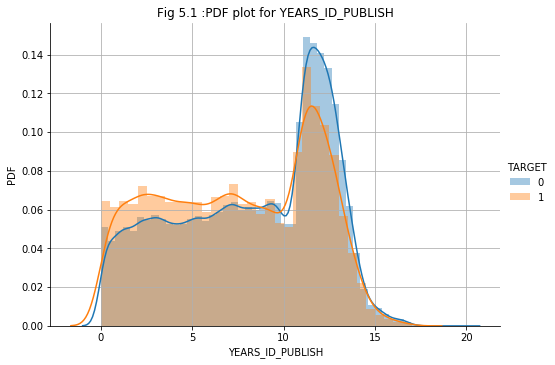

In [96]:
#plotting density plot
sns.FacetGrid(data=application_train, hue='TARGET', height=5, aspect=10/7).map(sns.distplot, 'YEARS_ID_PUBLISH').add_legend()
plt.title('Fig 5.1 :PDF plot for YEARS_ID_PUBLISH')
plt.xlabel('YEARS_ID_PUBLISH')
plt.ylabel('PDF')
plt.grid()
plt.show()

<h3><u>Observation from Fig 5.1:</u></h3><br>
Client who have changed the identity document within 8 years have higher density for class label 1 

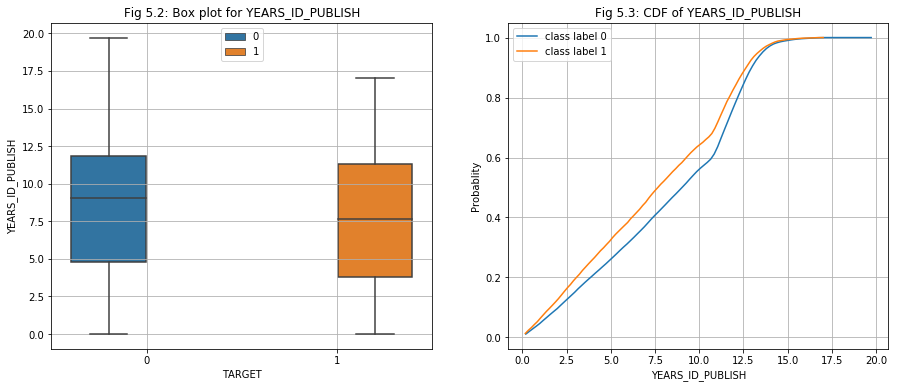

In [112]:
#plotting box plots
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.boxplot( x='TARGET', y='YEARS_ID_PUBLISH',hue='TARGET', data=application_train)
plt.legend(loc='upper center')
plt.grid()
plt.ylabel('YEARS_ID_PUBLISH')
plt.title('Fig 5.2: Box plot for YEARS_ID_PUBLISH')

#plotting the CDF of both class labels
plt.subplot(1,2,2)
counts, bin_edges = np.histogram(application_train[application_train['TARGET']==0]['YEARS_ID_PUBLISH'].fillna(0), \
                                 bins=100,density = True)
pdf = counts/(sum(counts))
cdf = np.cumsum(pdf)
plt.plot(bin_edges[1:], cdf)
counts, bin_edges = np.histogram(application_train[application_train['TARGET']==1]['YEARS_ID_PUBLISH'].fillna(0), \
                                 bins=100,density = True)
pdf = counts/(sum(counts))
cdf = np.cumsum(pdf)
plt.plot(bin_edges[1:], cdf)
plt.legend(['class label 0','class label 1'])
plt.xlabel('YEARS_ID_PUBLISH')
plt.ylabel('Probablity')
plt.title("Fig 5.3: CDF of YEARS_ID_PUBLISH")
plt.grid()
plt.show()

<h3><u>Observation from Fig 4.2:</u></h3><br>
the 50% value for label 0 is 8 years where as for class label 1 50% value is 7.5 years.

<h3><u>Observation from Fig 4.3:</u></h3><br>
their is visible gap around 60% values 9 for class label 1 where as 11 for class label 0 almost 2 year gap.

<h2> 7.6.4.6 Univariate Analysis of DAYS_LAST_PHONE_CHANGE</h2><br>
DAYS_LAST_PHONE_CHANGE: How many days before application did client change phone

In [98]:
#converting DAYS_LAST_PHONE_CHANGE to year
application_train['YEARS_LAST_PHONE_CHANGE']=application_train['DAYS_LAST_PHONE_CHANGE']/-365

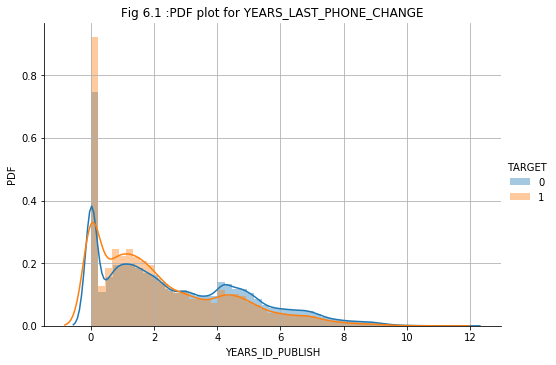

In [99]:
#plotting density plot
sns.FacetGrid(data=application_train, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'YEARS_LAST_PHONE_CHANGE').add_legend()
plt.title('Fig 6.1 :PDF plot for YEARS_LAST_PHONE_CHANGE')
plt.xlabel('YEARS_ID_PUBLISH')
plt.ylabel('PDF')
plt.grid()
plt.show()

<h3><u>Observation from Fig 6.1:</u></h3><br>
The data is right skewed, it means their will be few noisy points in the right side.<br>
Clients who have changed their phone number in recent 2.5 years are more likely to be deafulter 

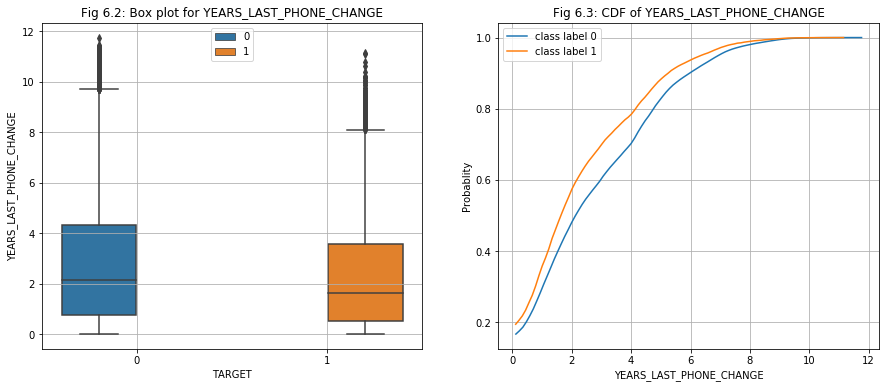

In [113]:
#plotting box plots
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.boxplot( x='TARGET', y='YEARS_LAST_PHONE_CHANGE',hue='TARGET', data=application_train)
plt.grid()
plt.legend(loc='upper center')
plt.ylabel('YEARS_LAST_PHONE_CHANGE')
plt.title('Fig 6.2: Box plot for YEARS_LAST_PHONE_CHANGE')

#plotting the CDF of both class labels
plt.subplot(1,2,2)
counts, bin_edges = np.histogram(application_train[application_train['TARGET']==0]['YEARS_LAST_PHONE_CHANGE'].fillna(0), \
                                 bins=100,density = True)
pdf = counts/(sum(counts))
cdf = np.cumsum(pdf)
plt.plot(bin_edges[1:], cdf)
counts, bin_edges = np.histogram(application_train[application_train['TARGET']==1]['YEARS_LAST_PHONE_CHANGE'].fillna(0), \
                                 bins=100,density = True)
pdf = counts/(sum(counts))
cdf = np.cumsum(pdf)
plt.plot(bin_edges[1:], cdf)
plt.legend(['class label 0','class label 1'])
plt.xlabel('YEARS_LAST_PHONE_CHANGE')
plt.ylabel('Probablity')
plt.title("Fig 6.3: CDF of YEARS_LAST_PHONE_CHANGE")
plt.grid()
plt.show()

<h3><u>Observation from Fig 6.2:</u></h3><br>
Many noisy points are present for both the class labels.<br>
The 75 % range for label 0 is 4.3 year and for label 1 its on lower side 3.7 years. 
<h3><u>Observation from Fig 6.3:</u></h3><br>
The cdf for label 1 is on the lower side than lable 0, the gap around 70% is almost 1 year. So lower the value clients tend to be a defaulter.

<h2> 7.6.4.7 Univariate Analysis of DAYS_EMPLOYED</h2><br>
DAYS_EMPLOYED: How many days before the application the person started current employment

In [5]:
#converting unit days to year
application_train['DAYS_EMPLOYED_YEAR']=application_train['DAYS_EMPLOYED']/-365

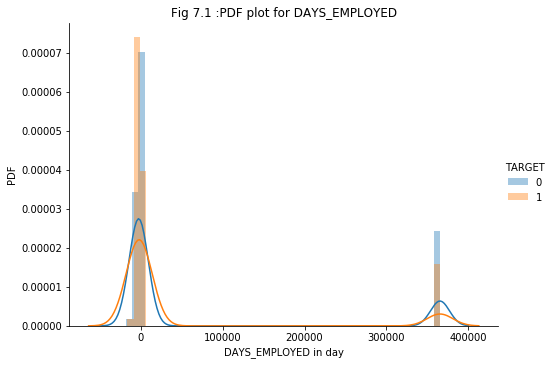

In [101]:
#plotting density plot
sns.FacetGrid(data=application_train, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'DAYS_EMPLOYED').add_legend()
plt.title('Fig 7.1 :PDF plot for DAYS_EMPLOYED')
plt.xlabel('DAYS_EMPLOYED in day')
plt.ylabel('PDF')
plt.show()

<h4>+365243 days for employment seems to be an outlier, it can not happen in reality, so removing it</h4>

In [102]:
#checking the max range
np.max(application_train.DAYS_EMPLOYED.values)

365243

After removing 55374 no of columns for further analysis


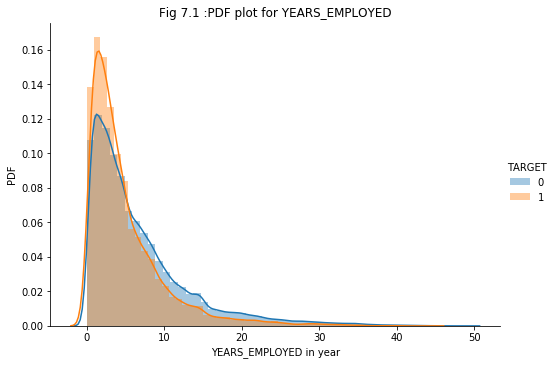

In [103]:
print("After removing {} no of columns for further analysis".format(len(application_train[(application_train['DAYS_EMPLOYED']==365243)])))
application_train["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)
#converting unit days to year
application_train['YEARS_EMPLOYED']=application_train['DAYS_EMPLOYED']/-365
#After removing plotting density plot
sns.FacetGrid(data=application_train, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'YEARS_EMPLOYED').add_legend()
plt.title('Fig 7.1 :PDF plot for YEARS_EMPLOYED')
plt.xlabel('YEARS_EMPLOYED in year')
plt.ylabel('PDF')
plt.show()

<h3><u>Observation from Fig 7.1:</u></h3><br>
The data is right skewed, it means their will be few noisy points in the right side.Very less people have very high employment years<br>Clients with less work/business experience(less than 6 years) are more likely to be deafulter 

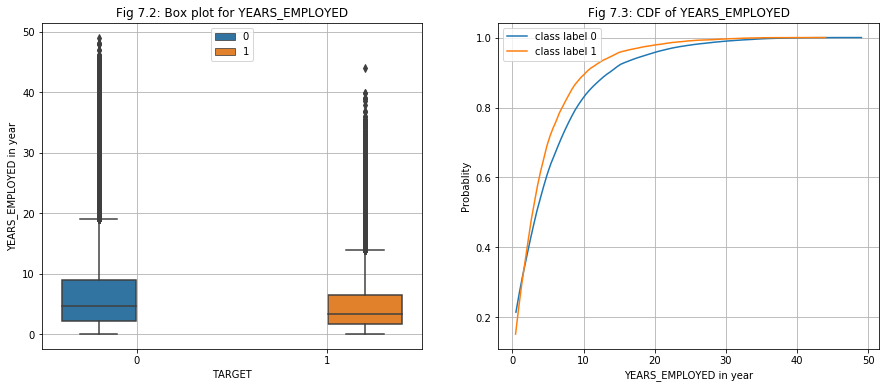

In [114]:
#plotting box plots
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.boxplot( x='TARGET', y='YEARS_EMPLOYED',hue='TARGET', data=application_train)
plt.grid()
plt.legend(loc='upper center')
plt.ylabel('YEARS_EMPLOYED in year')
plt.title('Fig 7.2: Box plot for YEARS_EMPLOYED')

#plotting the CDF of both class labels
plt.subplot(1,2,2)
counts, bin_edges = np.histogram(application_train[application_train['TARGET']==0]['YEARS_EMPLOYED'].fillna(0), \
                                 bins=100,density = True)
pdf = counts/(sum(counts))
cdf = np.cumsum(pdf)
plt.plot(bin_edges[1:], cdf)
counts, bin_edges = np.histogram(application_train[application_train['TARGET']==1]['YEARS_EMPLOYED'].fillna(0), \
                                 bins=100,density = True)
pdf = counts/(sum(counts))
cdf = np.cumsum(pdf)
plt.plot(bin_edges[1:], cdf)
plt.legend(['class label 0','class label 1'])
plt.xlabel('YEARS_EMPLOYED in year')
plt.ylabel('Probablity')
plt.title("Fig 7.3: CDF of YEARS_EMPLOYED")
plt.grid()
plt.show()

<h3><u>Observation from Fig 7.2:</u></h3><br>
Many noisy points are present for both the class labels.<br>
The 75 % range for label 0 is 9 year and for label 1 its on lower side 6 years. 
<h3><u>Observation from Fig 7.3:</u></h3><br>
The cdf for label 1 is on the lower side than lable 0, the gap around 90% is almost 2 year. their is slight overlap in the 30% probality range, but after that the class 0 always on the lower side.Lower the value indicates the clients have faced difficulty while loan repaying.

<h2> 7.6.4.8 Univariate Analysis of AMT_ANNUITY</h2><br>
AMT_ANNUITY:Loan annuity<br>
https://www.annuityfreedom.net/loan-companies/ <br>
What is an annuity loan? An annuity loan is a situation in which an annuity holder will borrow money against the value of his/her annuity contract. It can allow people to access funds without going through the process of cashing out their annuity, which may leave them exposed to taxes and penalties


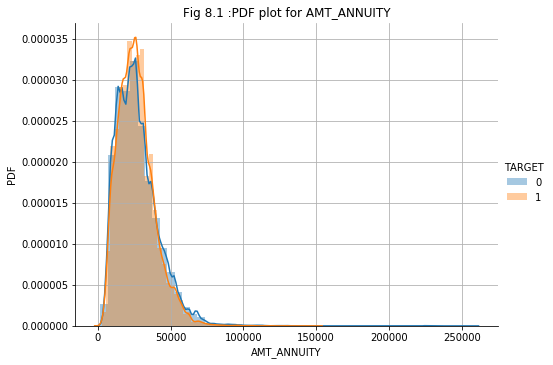

In [117]:
#plotting density plot
sns.FacetGrid(data=application_train, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'AMT_ANNUITY').add_legend()
plt.grid()
plt.title('Fig 8.1 :PDF plot for AMT_ANNUITY')
plt.xlabel('AMT_ANNUITY')
plt.ylabel('PDF')
plt.show()

<h3><u>Observation from Fig 8.1:</u></h3><br>
The data is right skewed, it means their will be few noisy points in the right side.Very less clients have high annuity amounts.Applying log transform may give us better understanding about the data.Most clients have annuity under 100000.

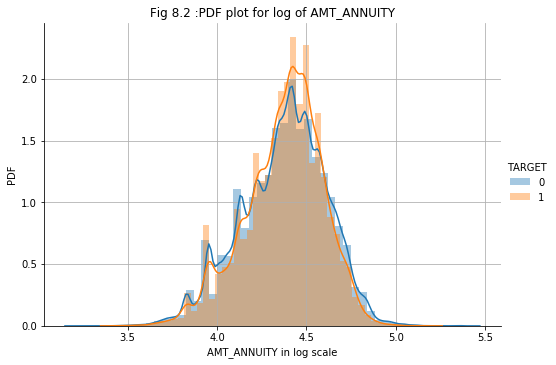

In [106]:
#converting the values to log scale for better visulaization
application_train['LOG_AMT_ANNUITY']=np.log10(application_train['AMT_ANNUITY'])
#plotting density plot
sns.FacetGrid(data=application_train, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'LOG_AMT_ANNUITY').add_legend()
plt.title('Fig 8.2 :PDF plot for log of AMT_ANNUITY')
plt.xlabel('AMT_ANNUITY in log scale')
plt.ylabel('PDF')
plt.grid()
plt.show()

<h3><u>Observation from Fig 8.2:</u></h3><br>
log10(AMT_ANNUITY) less than 4.7 and more than 4.3 label 1 has has more density.This range idicates clients has been defaulter.

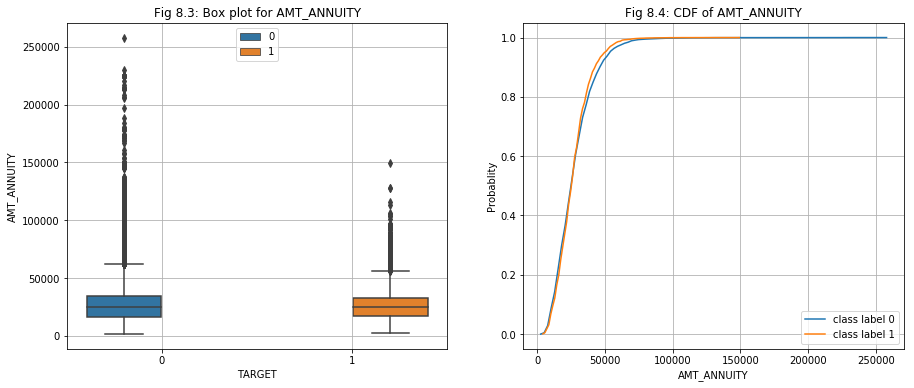

In [116]:
#plotting box plots
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.boxplot( x='TARGET', y='AMT_ANNUITY',hue='TARGET', data=application_train)
plt.legend(loc='upper center')
plt.grid()
plt.ylabel('AMT_ANNUITY')
plt.title('Fig 8.3: Box plot for AMT_ANNUITY')

#plotting the CDF of both class labels
plt.subplot(1,2,2)
counts, bin_edges = np.histogram(application_train[application_train['TARGET']==0]['AMT_ANNUITY'].fillna(0), \
                                 bins=100,density = True)
pdf = counts/(sum(counts))
cdf = np.cumsum(pdf)
plt.plot(bin_edges[1:], cdf)
counts, bin_edges = np.histogram(application_train[application_train['TARGET']==1]['AMT_ANNUITY'].fillna(0), \
                                 bins=100,density = True)
pdf = counts/(sum(counts))
cdf = np.cumsum(pdf)
plt.plot(bin_edges[1:], cdf)
plt.legend(['class label 0','class label 1'])
plt.xlabel('AMT_ANNUITY')
plt.ylabel('Probablity')
plt.title("Fig 8.4: CDF of AMT_ANNUITY")
plt.grid()
plt.show()

<h3><u>Observation from Fig 8.3:</u></h3><br>
Many noisy points are present for both the class labels at the larger amounts side.<br>
<h3><u>Observation from Fig 8.4:</u></h3><br>
The cdf for label 1 is on the lower side than lable 0 almost overlapping, but label 0 slightly is on the higher side than label 1 at 97%, but in the lower probablity region at 40% label 1 is ahead of label 0. From the fig 8.2 their is a specific range for this clients are tend to be a defaulter(as amount is in log10 scale-10^4.3 to 10^4.7)

<h2> 7.6.4.9 Univariate Analysis of AMT_ANNUITY</h2><br>
AMT_CREDIT:Credit amount of the loan<br>


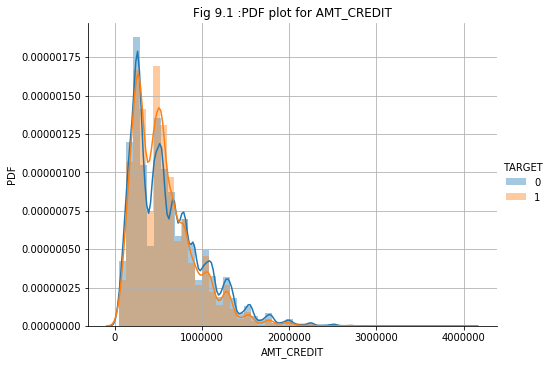

In [119]:
#plotting density plot
sns.FacetGrid(data=application_train, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'AMT_CREDIT').add_legend()
plt.grid()
plt.title('Fig 9.1 :PDF plot for AMT_CREDIT')
plt.xlabel('AMT_CREDIT')
plt.ylabel('PDF')
plt.show()

<h3><u>Observation from Fig 9.1:</u></h3><br>
The data is right skewed, it means their will be few noisy points in the right side.Very less clients have high amount credited amounts.Applying log transform may give us better understanding about the data.Most clients have annuity under 2500000 

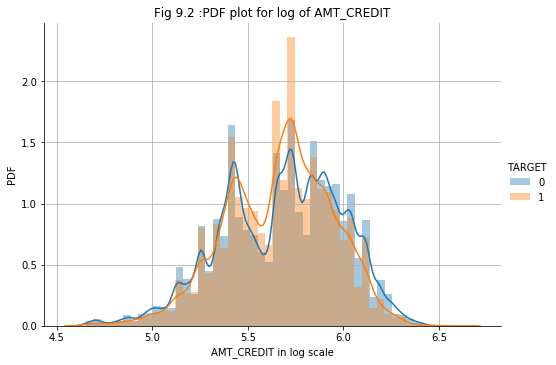

In [121]:
#converting the values to log scale for better visulaization
application_train['LOG_AMT_CREDIT']=np.log10(application_train['AMT_CREDIT'])
#plotting density plot
sns.FacetGrid(data=application_train, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'LOG_AMT_CREDIT').add_legend()
plt.title('Fig 9.2 :PDF plot for log of AMT_CREDIT')
plt.xlabel('AMT_CREDIT in log scale')
plt.ylabel('PDF')
plt.grid()
plt.show()

<h3><u>Observation from Fig 9.2:</u></h3><br>
log10(AMT_CREDIT) less than 5.4 and more than 5.8 label 1 has has more density.This range idicates clients has been defaulter.

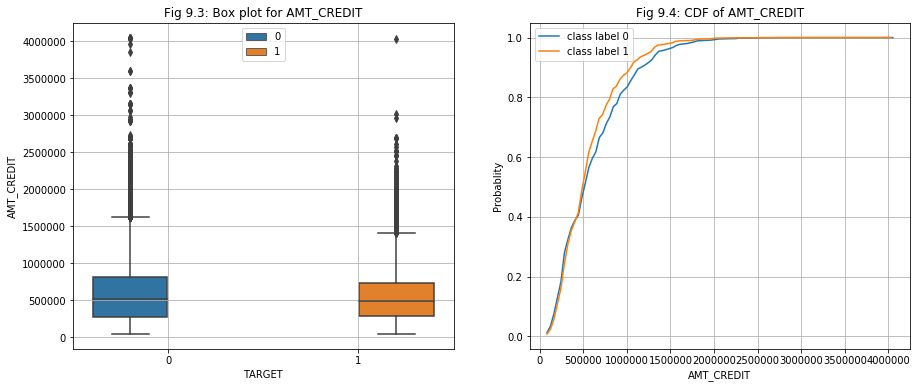

In [123]:
#plotting box plots
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.boxplot( x='TARGET', y='AMT_CREDIT',hue='TARGET', data=application_train)
plt.legend(loc='upper center')
plt.grid()
plt.ylabel('AMT_CREDIT')
plt.title('Fig 9.3: Box plot for AMT_CREDIT')

#plotting the CDF of both class labels
plt.subplot(1,2,2)
counts, bin_edges = np.histogram(application_train[application_train['TARGET']==0]['AMT_CREDIT'].fillna(0), \
                                 bins=100,density = True)
pdf = counts/(sum(counts))
cdf = np.cumsum(pdf)
plt.plot(bin_edges[1:], cdf)
counts, bin_edges = np.histogram(application_train[application_train['TARGET']==1]['AMT_CREDIT'].fillna(0), \
                                 bins=100,density = True)
pdf = counts/(sum(counts))
cdf = np.cumsum(pdf)
plt.plot(bin_edges[1:], cdf)
plt.legend(['class label 0','class label 1'])
plt.xlabel('AMT_CREDIT')
plt.ylabel('Probablity')
plt.title("Fig 9.4: CDF of AMT_CREDIT")
plt.grid()
plt.show()

<h3><u>Observation from Fig 9.3:</u></h3><br>
Many noisy points are present for both the class labels at the larger amounts side.<br>
The 75 % range for label 0 higher than label 1 . 
<h3><u>Observation from Fig 9.4:</u></h3><br>
The cdf for label 1 is on the lower side than lable 0 almost overlapping, but after 45% the gap increased where label 0 is ahead of label 1.. From the fig 9.2 their is a specific range for this clients are tend to be a defaulter(as amount is in log10 scale-10^5.4 to 10^5.8)

<h2> 7.6.4.10 Univariate Analysis of AMT_INCOME_TOTAL</h2><br>
AMT_INCOME_TOTAL: Income of the client<br>


In [130]:
#checking the max range
np.max(application_train.AMT_INCOME_TOTAL.values)
#As this is unrealistic client with this large income has been a defaulter will try to plot cdf after removing the data
application_train["AMT_INCOME_TOTAL"].replace({117000000: np.nan}, inplace = True)

117000000.0

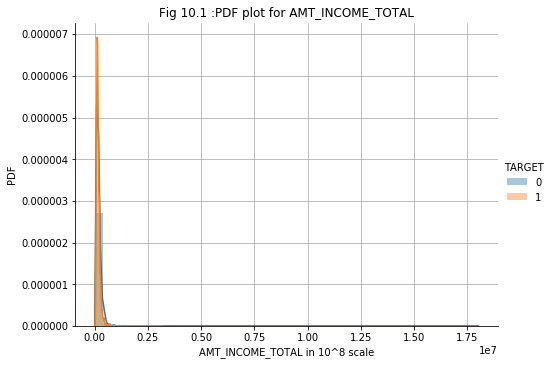

In [132]:
#plotting density plot
sns.FacetGrid(data=application_train, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'AMT_INCOME_TOTAL').add_legend()
plt.grid()
plt.title('Fig 10.1 :PDF plot for AMT_INCOME_TOTAL')
plt.xlabel('AMT_INCOME_TOTAL in 10^8 scale')
plt.ylabel('PDF')
plt.show()

<h3><u>Observation from Fig 10.1:</u></h3><br>
The plot is highly right skewed.Very less clients have a large income.Applying log transform we can try to to visulaize the data

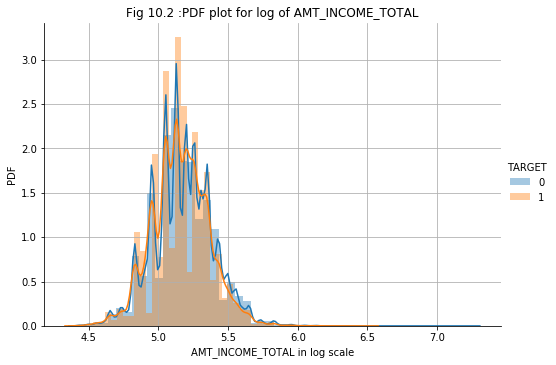

In [133]:
#converting the values to log scale for better visulaization
application_train['LOG_AMT_INCOME_TOTAL']=np.log10(application_train['AMT_INCOME_TOTAL'])
#plotting density plot
sns.FacetGrid(data=application_train, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'LOG_AMT_INCOME_TOTAL').add_legend()
plt.title('Fig 10.2 :PDF plot for log of AMT_INCOME_TOTAL')
plt.xlabel('AMT_INCOME_TOTAL in log scale')
plt.ylabel('PDF')
plt.grid()
plt.show()

<h3><u>Observation from Fig 10.2:</u></h3><br>
The plot is highly right skewed.Still the plot is overlapping, can not make any certain conclusion.But in the range 4.7 and 5.3 the distribution of label 0 is fluctuating whereas label 1 seems to be with higher density in cerain regions.

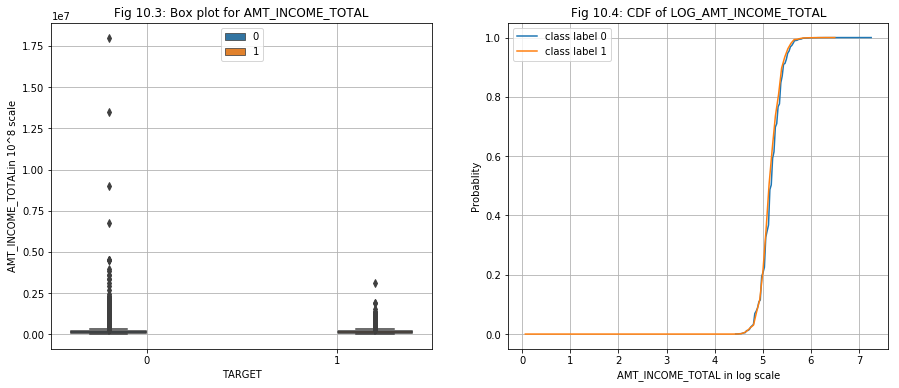

In [140]:
#plotting box plots
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.boxplot( x='TARGET', y='AMT_INCOME_TOTAL',hue='TARGET', data=application_train)
plt.legend(loc='upper center')
plt.grid()
plt.ylabel('AMT_INCOME_TOTALin 10^8 scale')
plt.title('Fig 10.3: Box plot for AMT_INCOME_TOTAL')
plt.subplot(1,2,2)
#plotting the CDF of both class labels
counts, bin_edges = np.histogram(application_train[application_train['TARGET']==0]['LOG_AMT_INCOME_TOTAL'].fillna(0), \
                                 bins=100,density = True)
pdf = counts/(sum(counts))
cdf = np.cumsum(pdf)
plt.plot(bin_edges[1:], cdf)
counts, bin_edges = np.histogram(application_train[application_train['TARGET']==1]['LOG_AMT_INCOME_TOTAL'].fillna(0), \
                                 bins=100,density = True)
pdf = counts/(sum(counts))
cdf = np.cumsum(pdf)
plt.plot(bin_edges[1:], cdf)
plt.legend(['class label 0','class label 1'])
plt.xlabel('AMT_INCOME_TOTAL in log scale')
plt.ylabel('Probablity')
plt.title("Fig 10.4: CDF of LOG_AMT_INCOME_TOTAL")
plt.grid()
plt.show()

<h3><u>Observation from Fig 10.3:</u></h3><br>
Many noisy points are present for both the class labels at the larger amounts side.<br>
Theere may be many outliers present for large amount incomes. 
<h3><u>Observation from Fig 10.4:</u></h3><br>
The cdf for label 1 is on the lower side than lable 0 almost overlapping, but label 0 is slightly ahead of label 1.this indicates after a certain range low income affects the client's ability of repaying the loan.

<h3>7.6.5 Bivariate Analysis of EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,DAYS_ID_PUBLISH </h3>


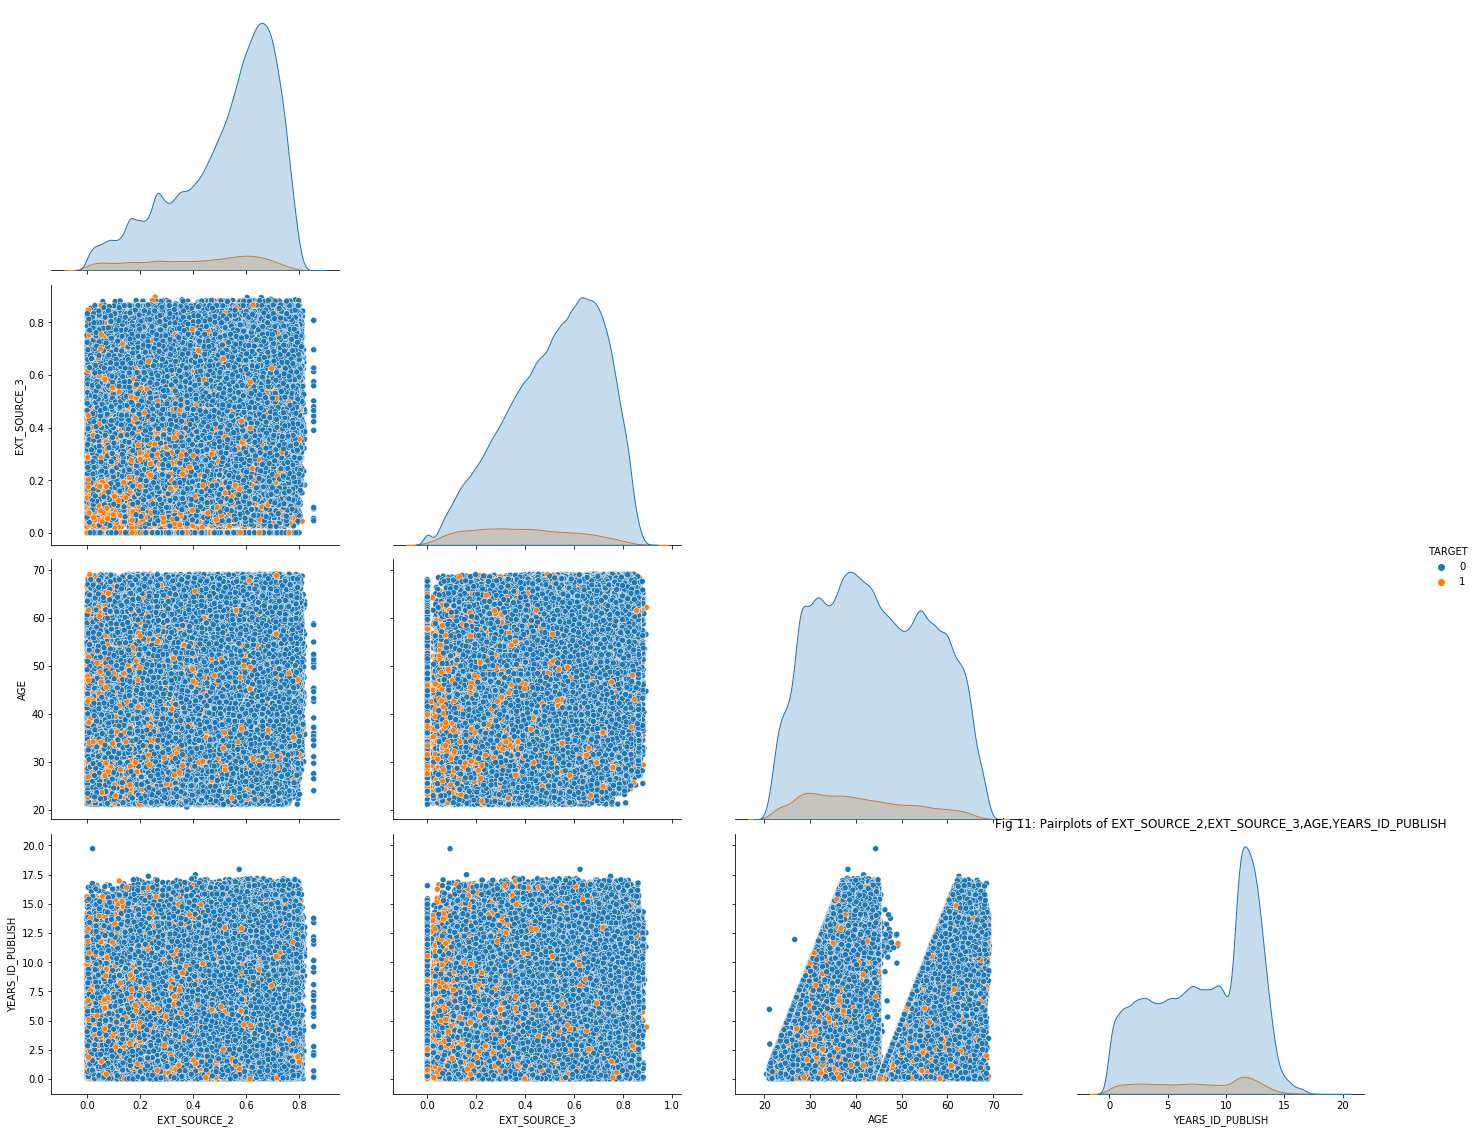

In [153]:
#plotting pairplots of top 4 features EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,DAYS_ID_PUBLISH
sns.pairplot(application_train[['EXT_SOURCE_2','EXT_SOURCE_3','AGE','YEARS_ID_PUBLISH','TARGET']], hue='TARGET',\
             corner=True,height=4,aspect=5/4)
plt.title('Fig 11: Pairplots of EXT_SOURCE_2,EXT_SOURCE_3,AGE,YEARS_ID_PUBLISH')
plt.show()

<h3><u>Observation from Fig 11:</u></h3><br>
'EXT_SOURCE_2' vs 'EXT_SOURCE_3':clients with EXT_SOURCE_2<0.2 and EXT_SOURCE_3<0.2 has the most tendency for defaulter<br>
'EXT_SOURCE_3' vs 'DAYS_BIRTH':clients with  EXT_SOURCE_3<0.4 and 25<AGE<40 has the most tendency for defaulter

<h2>7.6.6 Categorical feature Analysis </h2>


<h3> 7.6.6.1 Univariate Analysis of NAME_CONTRACT_TYPE</h3><br>
NAME_CONTRACT_TYPE: Identification if loan is cash or revolving

In [25]:
#getting the counts of each unique category in the features
def agg_count_details(data,feature_name):
    #Getting count on the categorical feature and aggregating based on their 'TARGET' label
    #and printing the top 5 values for both labels
    #https://stackoverflow.com/questions/51540495/pandas-groupby-count-the-number-of-zeros-in-a-column
    #for label 1
    counts_1=data.groupby([feature_name])[['TARGET']].agg(lambda x: x.eq(1).sum()).\
      apply(lambda x: x.sort_values(ascending=False))

    counts_1_percent=data.groupby([feature_name])[['TARGET']].agg(lambda x: x.eq(1).sum()).\
      apply(lambda x: 100*x/x.sum()).apply(lambda x: x.sort_values(ascending=False))
    
    counts_1_percent=counts_1_percent.merge(counts_1,on=feature_name)
    counts_1_percent.columns =[ 'Count of each category', 'Percentage of count of each category']
    #for label 0
    counts_0=data.groupby([feature_name])[['TARGET']].agg(lambda x: x.eq(0).sum()).\
      apply(lambda x: x.sort_values(ascending=False))

    counts_0_percent=data.groupby([feature_name])[['TARGET']].agg(lambda x: x.eq(0).sum()).\
      apply(lambda x: 100*x/x.sum()).apply(lambda x: x.sort_values(ascending=False))
    counts_0_percent=counts_0_percent.merge(counts_0,on=feature_name)
    counts_0_percent.columns =[ 'Count of each category', 'Percentage of count of each category']
    return counts_1_percent,counts_0_percent

Unique values present in NAME_CONTRACT_TYPE : {'Revolving loans', 'Cash loans'} 
No of unique values: 2


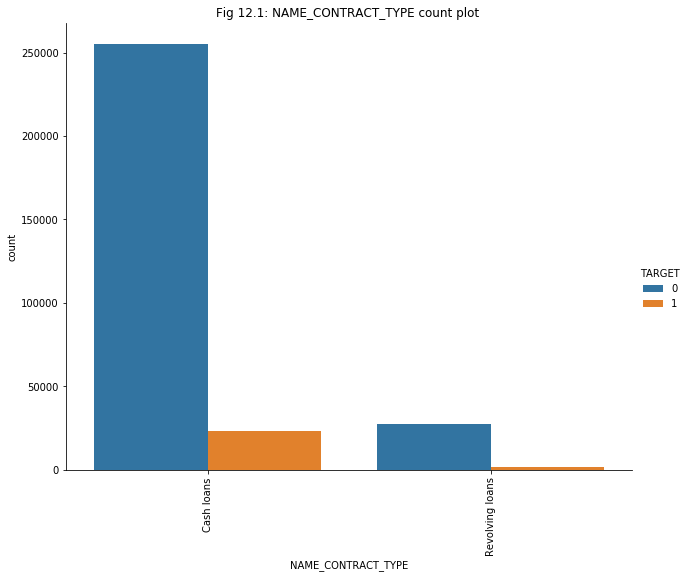

Counts of top 5 values of label 1:


Count of each category  \
NAME_CONTRACT_TYPE                           
Cash loans                       93.538771   
Revolving loans                   6.461229   

                    Percentage of count of each category  
NAME_CONTRACT_TYPE                                        
Cash loans                                         23221  
Revolving loans                                     1604

Counts of  top 5 values of label 0:


Count of each category  \
NAME_CONTRACT_TYPE                           
Cash loans                       90.209986   
Revolving loans                   9.790014   

                    Percentage of count of each category  
NAME_CONTRACT_TYPE                                        
Cash loans                                        255011  
Revolving loans                                    27675

In [98]:
print("Unique values present in {} : {} ".format('NAME_CONTRACT_TYPE', set(application_train['NAME_CONTRACT_TYPE'].values)))
print("No of unique values: {}".format(len(set(application_train['NAME_CONTRACT_TYPE'].values))))
#plotting countplot in sorted manner for each unique value in the categorical feature
sns.catplot(x='NAME_CONTRACT_TYPE', kind="count",hue='TARGET', data=application_train,height=7, \
            aspect=9/7,order=application_train['NAME_CONTRACT_TYPE'].value_counts().index).\
set_xticklabels(rotation=90)
plt.title('Fig 12.1: {} count plot '.format('NAME_CONTRACT_TYPE'))
plt.show()

counts_1_percent,counts_0_percent=agg_count_details(application_train,'NAME_CONTRACT_TYPE')

#printing the top 5 values for both labels
print("Counts of top 5 values of label 1:")
display(counts_1_percent.head(5))
print("Counts of  top 5 values of label 0:")
display(counts_0_percent.head(5))

<h3><u>Observation from Fig 12.1:</u></h3><br>
Their is 2 uniquevalues present in the feature: 'Revolving loans', 'Cash loans'<br>
Most client took Cash loans.9.79% clients of label 1 took revolving type loan where as 6.46% clients of label 0 took revolving loan.Defaulter client took more of revolving type of loans

<h3> 7.6.6.2 Univariate Analysis of CODE_GENDER</h3><br>
CODE_GENDER: Gender of the client

Unique values present in CODE_GENDER : {'M', 'F', 'XNA'} 
No of unique values: 3


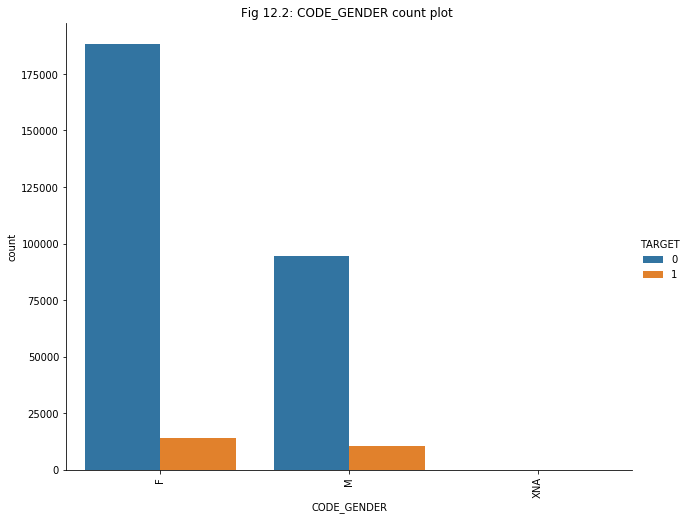

Counts of top 5 values of label 1:


Count of each category  Percentage of count of each category
CODE_GENDER                                                              
F                         57.079557                                 14170
M                         42.920443                                 10655
XNA                        0.000000                                     0

Counts of  top 5 values of label 0:


Count of each category  Percentage of count of each category
CODE_GENDER                                                              
F                         66.603228                                188278
M                         33.395357                                 94404
XNA                        0.001415                                     4

In [97]:
print("Unique values present in {} : {} ".format('CODE_GENDER', set(application_train['CODE_GENDER'].values)))
print("No of unique values: {}".format(len(set(application_train['CODE_GENDER'].values))))
#plotting countplot in sorted manner for each unique value in the categorical feature
sns.catplot(x='CODE_GENDER', kind="count",hue='TARGET', data=application_train,height=7, \
            aspect=9/7,order=application_train['CODE_GENDER'].value_counts().index).\
set_xticklabels(rotation=90)
plt.title('Fig 12.2: {} count plot '.format('CODE_GENDER'))
plt.show()

counts_1_percent,counts_0_percent=agg_count_details(application_train,'CODE_GENDER')

#printing the top 5 values for both labels
print("Counts of top 5 values of label 1:")
display(counts_1_percent.head(5))
print("Counts of  top 5 values of label 0:")
display(counts_0_percent.head(5))

<h3><u>Observation from Fig 12.2:</u></h3><br>
There are 3 unique values in the feature: M: Male, F:Female,XNA:Others<br>
11% difference in the count of male client with loan repaying difficulty.Generally their is no discrimination reagrding gender but in the train data male client seems to be defaulter more than female clients.

<h3> 7.6.6.3 Univariate Analysis of NAME_TYPE_SUITE</h3><br>
NAME_TYPE_SUITE: Who was accompanying client when he was applying for the loan

Unique values present in NAME_TYPE_SUITE : {nan, 'Other_A', 'Group of people', 'Family', 'Children', 'Spouse, partner', 'Other_B', 'Unaccompanied'} 
No of unique values: 8


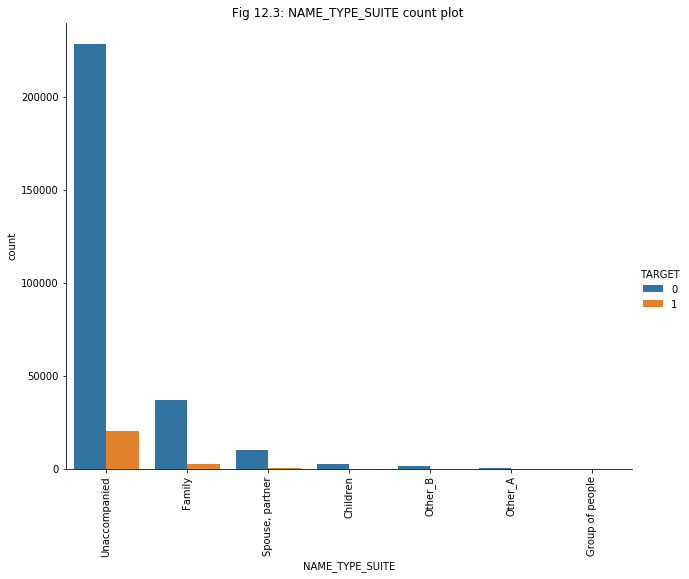

Counts of top 5 values of label 1:


Count of each category  Percentage of count of each category
NAME_TYPE_SUITE                                                              
Unaccompanied                 82.153100                                 20337
Family                        12.155120                                  3009
Spouse, partner                3.615431                                   895
Children                       0.973541                                   241
Other_B                        0.702888                                   174

Counts of  top 5 values of label 0:


Count of each category  Percentage of count of each category
NAME_TYPE_SUITE                                                              
Unaccompanied                 81.072180                                228189
Family                        13.195293                                 37140
Spouse, partner                3.721613                                 10475
Children                       1.075093                                  3026
Other_B                        0.567035                                  1596

In [99]:
print("Unique values present in {} : {} ".format('NAME_TYPE_SUITE', set(application_train['NAME_TYPE_SUITE'].values)))
print("No of unique values: {}".format(len(set(application_train['NAME_TYPE_SUITE'].values))))
#plotting countplot in sorted manner for each unique value in the categorical feature
sns.catplot(x='NAME_TYPE_SUITE', kind="count",hue='TARGET', data=application_train,height=7, \
            aspect=9/7,order=application_train['NAME_TYPE_SUITE'].value_counts().index).\
set_xticklabels(rotation=90)
plt.title('Fig 12.3: {} count plot '.format('NAME_TYPE_SUITE'))
plt.show()


counts_1_percent,counts_0_percent=agg_count_details(application_train,'NAME_TYPE_SUITE')

#printing the top 5 values for both labels
print("Counts of top 5 values of label 1:")
display(counts_1_percent.head(5))
print("Counts of  top 5 values of label 0:")
display(counts_0_percent.head(5))

<h3><u>Observation from Fig 12.3:</u></h3><br>
There are 7 unique value present in the feature except nan values:'Other_A', 'Group of people', 'Family', 'Children', 'Spouse, partner', 'Other_B', 'Unaccompanied'<br>
Most clients came unaccompanied.Rest counts are matching , their is no significant difference in the labels.

<h3> 7.6.6.4 Univariate Analysis of NAME_INCOME_TYPE</h3><br>
NAME_INCOME_TYPE: Clients income type (businessman, working, maternity leave,…)

Unique values present in NAME_INCOME_TYPE : {'Student', 'Businessman', 'Commercial associate', 'Working', 'Unemployed', 'Maternity leave', 'Pensioner', 'State servant'} 
No of unique values: 8


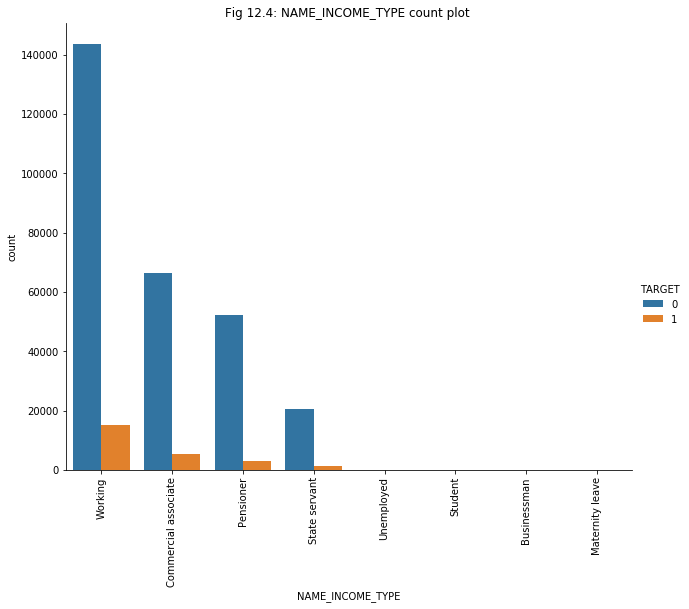

Counts of top 5 values of label 1:


Count of each category  \
NAME_INCOME_TYPE                               
Working                            61.325277   
Commercial associate               21.591138   
Pensioner                          12.012085   
State servant                       5.031219   
Unemployed                          0.032226   

                      Percentage of count of each category  
NAME_INCOME_TYPE                                            
Working                                              15224  
Commercial associate                                  5360  
Pensioner                                             2982  
State servant                                         1249  
Unemployed                                               8

Counts of  top 5 values of label 0:


Count of each category  \
NAME_INCOME_TYPE                               
Working                            50.780725   
Commercial associate               23.438373   
Pensioner                          18.529393   
State servant                       7.235590   
Student                             0.006367   

                      Percentage of count of each category  
NAME_INCOME_TYPE                                            
Working                                             143550  
Commercial associate                                 66257  
Pensioner                                            52380  
State servant                                        20454  
Student                                                 18

In [100]:
print("Unique values present in {} : {} ".format('NAME_INCOME_TYPE', set(application_train['NAME_INCOME_TYPE'].values)))
print("No of unique values: {}".format(len(set(application_train['NAME_INCOME_TYPE'].values))))
#plotting countplot in sorted manner for each unique value in the categorical feature
sns.catplot(x='NAME_INCOME_TYPE', kind="count",hue='TARGET', data=application_train,height=7, \
            aspect=9/7,order=application_train['NAME_INCOME_TYPE'].value_counts().index).\
set_xticklabels(rotation=90)
plt.title('Fig 12.4: {} count plot '.format('NAME_INCOME_TYPE'))
plt.show()

counts_1_percent,counts_0_percent=agg_count_details(application_train,'NAME_INCOME_TYPE')

#printing the top 5 values for both labels
print("Counts of top 5 values of label 1:")
display(counts_1_percent.head(5))
print("Counts of  top 5 values of label 0:")
display(counts_0_percent.head(5))

<h3><u>Observation from Fig 12.4:</u></h3><br>
There are 8 unique values present in these feature: 'Student', 'Businessman', 'Commercial associate', 'Working', 'Unemployed', 'Maternity leave', 'Pensioner', 'State servant'<br>
Most clients are 'Working' . There is 11% differnece in working client who have loan repaying difficulties.Pensioner are more likely to be non defaulter.

<h3> 7.6.6.5 Univariate Analysis of NAME_EDUCATION_TYPE</h3><br>
NAME_EDUCATION_TYPE: Level of highest education the client achieved

Unique values present in NAME_EDUCATION_TYPE : {'Incomplete higher', 'Academic degree', 'Higher education', 'Lower secondary', 'Secondary / secondary special'} 
No of unique values: 5


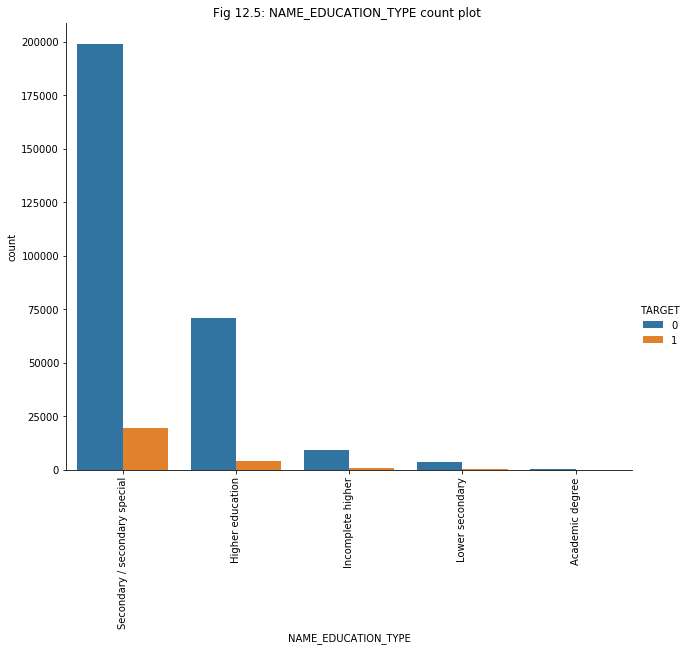

Counts of top 5 values of label 1:


Count of each category  \
NAME_EDUCATION_TYPE                                     
Secondary / secondary special               78.646526   
Higher education                            16.149043   
Incomplete higher                            3.512588   
Lower secondary                              1.679758   
Academic degree                              0.012085   

                               Percentage of count of each category  
NAME_EDUCATION_TYPE                                                  
Secondary / secondary special                                 19524  
Higher education                                               4009  
Incomplete higher                                               872  
Lower secondary                                                 417  
Academic degree                                                   3

Counts of  top 5 values of label 0:


Count of each category  \
NAME_EDUCATION_TYPE                                     
Secondary / secondary special               70.349080   
Higher education                            25.064559   
Incomplete higher                            3.327013   
Lower secondary                              1.202394   
Academic degree                              0.056954   

                               Percentage of count of each category  
NAME_EDUCATION_TYPE                                                  
Secondary / secondary special                                198867  
Higher education                                              70854  
Incomplete higher                                              9405  
Lower secondary                                                3399  
Academic degree                                                 161

In [101]:
print("Unique values present in {} : {} ".format('NAME_EDUCATION_TYPE', set(application_train['NAME_EDUCATION_TYPE'].values)))
print("No of unique values: {}".format(len(set(application_train['NAME_EDUCATION_TYPE'].values))))
#plotting countplot in sorted manner for each unique value in the categorical feature
sns.catplot(x='NAME_EDUCATION_TYPE', kind="count",hue='TARGET', data=application_train,height=7, \
            aspect=9/7,order=application_train['NAME_EDUCATION_TYPE'].value_counts().index).\
set_xticklabels(rotation=90)
plt.title('Fig 12.5: {} count plot '.format('NAME_EDUCATION_TYPE'))
plt.show()

counts_1_percent,counts_0_percent=agg_count_details(application_train,'NAME_EDUCATION_TYPE')

#printing the top 5 values for both labels
print("Counts of top 5 values of label 1:")
display(counts_1_percent.head(5))
print("Counts of  top 5 values of label 0:")
display(counts_0_percent.head(5))

<h3><u>Observation from Fig 12.5:</u></h3><br>
There are 5 unique values present in this feature:'Incomplete higher', 'Academic degree', 'Higher education', 'Lower secondary', 'Secondary / secondary special'<br>
Most clients have education type as :Secondary / secondary special, but there is almost 8 % more client with education type as Secondary / secondary special have loan reaying difficulties and 8 % less for  Higher education.

<h3> 7.6.6.6 Univariate Analysis of NAME_FAMILY_STATUS</h3><br>
NAME_FAMILY_STATUS: Family status of the client

Unique values present in NAME_FAMILY_STATUS : {'Single / not married', 'Separated', 'Civil marriage', 'Married', 'Widow', 'Unknown'} 
No of unique values: 6


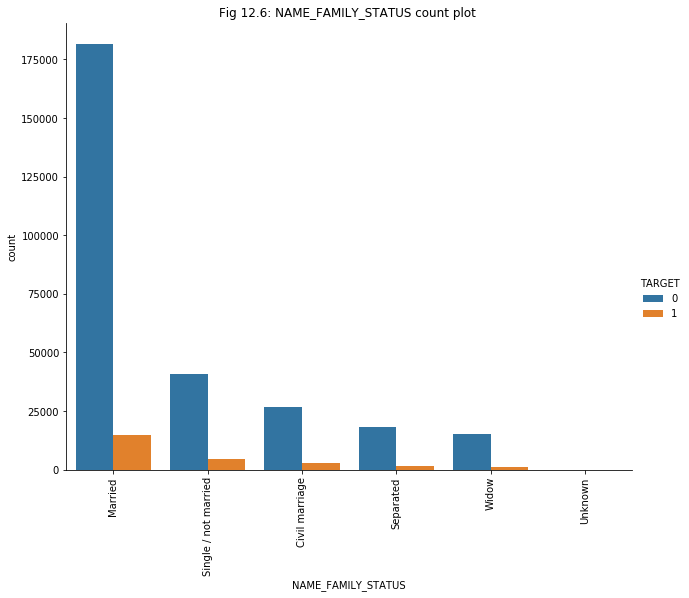

Counts of top 5 values of label 1:


Count of each category  \
NAME_FAMILY_STATUS                             
Married                            59.818731   
Single / not married               17.953676   
Civil marriage                     11.927492   
Separated                           6.525680   
Widow                               3.774421   

                      Percentage of count of each category  
NAME_FAMILY_STATUS                                          
Married                                              14850  
Single / not married                                  4457  
Civil marriage                                        2961  
Separated                                             1620  
Widow                                                  937

Counts of  top 5 values of label 0:


Count of each category  \
NAME_FAMILY_STATUS                             
Married                            64.234522   
Single / not married               14.499126   
Civil marriage                      9.485436   
Separated                           6.420551   
Widow                               5.359657   

                      Percentage of count of each category  
NAME_FAMILY_STATUS                                          
Married                                             181582  
Single / not married                                 40987  
Civil marriage                                       26814  
Separated                                            18150  
Widow                                                15151

In [102]:
print("Unique values present in {} : {} ".format('NAME_FAMILY_STATUS', set(application_train['NAME_FAMILY_STATUS'].values)))
print("No of unique values: {}".format(len(set(application_train['NAME_FAMILY_STATUS'].values))))
#plotting countplot in sorted manner for each unique value in the categorical feature
sns.catplot(x='NAME_FAMILY_STATUS', kind="count",hue='TARGET', data=application_train,height=7, \
            aspect=9/7,order=application_train['NAME_FAMILY_STATUS'].value_counts().index).\
set_xticklabels(rotation=90)
plt.title('Fig 12.6: {} count plot '.format('NAME_FAMILY_STATUS'))
plt.show()

counts_1_percent,counts_0_percent=agg_count_details(application_train,'NAME_FAMILY_STATUS')

#printing the top 5 values for both labels
print("Counts of top 5 values of label 1:")
display(counts_1_percent.head(5))
print("Counts of  top 5 values of label 0:")
display(counts_0_percent.head(5))

<h3><u>Observation from Fig 12.6:</u></h3><br>
There are 6 unique values present in this fetaure :'Single / not married', 'Separated', 'Civil marriage', 'Married', 'Widow', 'Unknown'<br>
Most clients are married.Clients with status: Married,unmarried and Civil marriage  are more tends to be defaulter as their is a certain difference in the counts.

<h3> 7.6.6.7 Univariate Analysis of OCCUPATION_TYPE</h3><br>
OCCUPATION_TYPE: What kind of occupation does the client have

Unique values present in OCCUPATION_TYPE : {nan, 'Laborers', 'Secretaries', 'Cleaning staff', 'Sales staff', 'Security staff', 'Drivers', 'Realty agents', 'Core staff', 'Cooking staff', 'IT staff', 'Medicine staff', 'Low-skill Laborers', 'HR staff', 'High skill tech staff', 'Waiters/barmen staff', 'Managers', 'Private service staff', 'Accountants'} 
No of unique values: 19


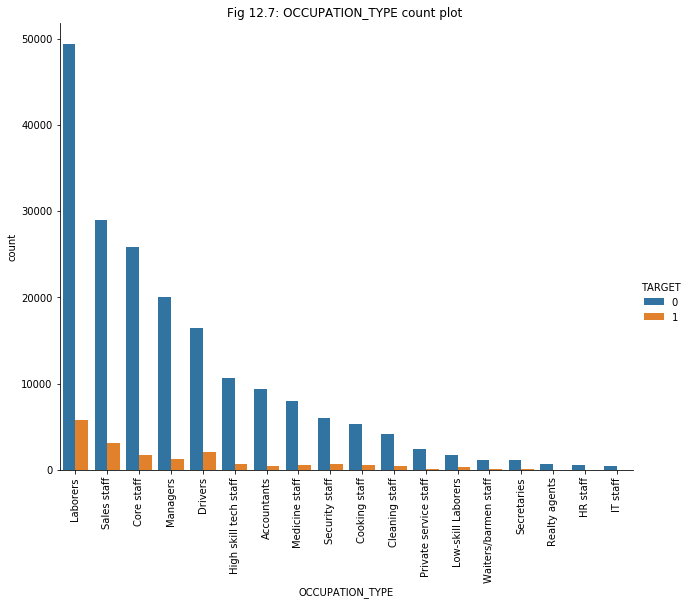

Counts of top 5 values of label 1:


Count of each category  Percentage of count of each category
OCCUPATION_TYPE                                                              
Laborers                      31.476789                                  5838
Sales staff                   16.671160                                  3092
Drivers                       11.360328                                  2107
Core staff                     9.370788                                  1738
Managers                       7.160188                                  1328

Counts of  top 5 values of label 0:


Count of each category  Percentage of count of each category
OCCUPATION_TYPE                                                              
Laborers                      25.625607                                 49348
Sales staff                   15.064417                                 29010
Core staff                    13.414134                                 25832
Managers                      10.408001                                 20043
Drivers                        8.566102                                 16496

In [103]:
print("Unique values present in {} : {} ".format('OCCUPATION_TYPE', set(application_train['OCCUPATION_TYPE'].values)))
print("No of unique values: {}".format(len(set(application_train['OCCUPATION_TYPE'].values))))
#plotting countplot in sorted manner for each unique value in the categorical feature
sns.catplot(x='OCCUPATION_TYPE', kind="count",hue='TARGET', data=application_train,height=7, \
            aspect=9/7,order=application_train['OCCUPATION_TYPE'].value_counts().index).\
set_xticklabels(rotation=90)
plt.title('Fig 12.7: {} count plot '.format('OCCUPATION_TYPE'))
plt.show()

counts_1_percent,counts_0_percent=agg_count_details(application_train,'OCCUPATION_TYPE')

#printing the top 5 values for both labels
print("Counts of top 5 values of label 1:")
display(counts_1_percent.head(5))
print("Counts of  top 5 values of label 0:")
display(counts_0_percent.head(5))

<h3><u>Observation from Fig 12.7:</u></h3><br>
There are 18 unique values present in this feature except nan :'Laborers', 'Secretaries', 'Cleaning staff', 'Sales staff', 'Security staff', 'Drivers', 'Realty agents', 'Core staff', 'Cooking staff', 'IT staff', 'Medicine staff', 'Low-skill Laborers', 'HR staff', 'High skill tech staff', 'Waiters/barmen staff', 'Managers', 'Private service staff', 'Accountants'<br>
Most clients have occupation as Laborers.There is 6% more clients with occupation as Laborers have loan repaying difficulties. <br>
Drivers seems to be more tend to be deafulter as the count percentage is 3% higher.

<h3> 7.6.6.8 Univariate Analysis of ORGANIZATION_TYPE</h3><br>
ORGANIZATION_TYPE: Type of organization where client works

Unique values present in ORGANIZATION_TYPE : {'Self-employed', 'Transport: type 4', 'Industry: type 9', 'Agriculture', 'Legal Services', 'School', 'Security Ministries', 'Trade: type 4', 'Emergency', 'Realtor', 'Industry: type 1', 'Advertising', 'Trade: type 2', 'Trade: type 7', 'Religion', 'Telecom', 'Trade: type 1', 'Industry: type 6', 'Industry: type 12', 'Industry: type 10', 'Industry: type 3', 'Postal', 'Business Entity Type 1', 'University', 'Trade: type 5', 'Services', 'Hotel', 'Other', 'Electricity', 'Police', 'Mobile', 'Restaurant', 'Housing', 'Construction', 'Industry: type 13', 'Transport: type 2', 'Business Entity Type 2', 'Medicine', 'Industry: type 11', 'Industry: type 4', 'Insurance', 'Trade: type 6', 'Cleaning', 'Industry: type 8', 'Transport: type 1', 'Security', 'XNA', 'Industry: type 7', 'Bank', 'Transport: type 3', 'Industry: type 5', 'Business Entity Type 3', 'Kindergarten', 'Trade: type 3', 'Military', 'Industry: type 2', 'Culture', 'Government'} 
No of unique val

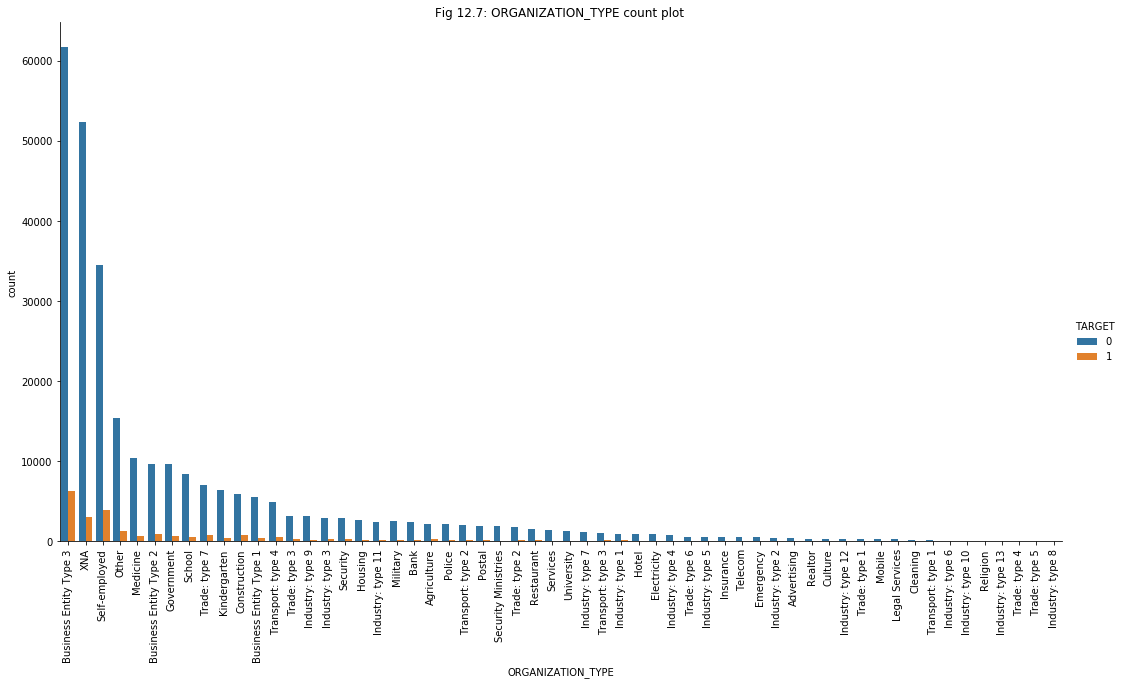

Counts of top 5 values of label 1:


Count of each category  \
ORGANIZATION_TYPE                                
Business Entity Type 3               25.470292   
Self-employed                        15.742195   
XNA                                  12.044310   
Other                                 5.135952   
Business Entity Type 2                3.625378   

                        Percentage of count of each category  
ORGANIZATION_TYPE                                             
Business Entity Type 3                                  6323  
Self-employed                                           3908  
XNA                                                     2990  
Other                                                   1275  
Business Entity Type 2                                   900

Counts of  top 5 values of label 0:


Count of each category  \
ORGANIZATION_TYPE                                
Business Entity Type 3               21.815371   
XNA                                  18.530808   
Self-employed                        12.205769   
Other                                 5.450571   
Medicine                              3.698804   

                        Percentage of count of each category  
ORGANIZATION_TYPE                                             
Business Entity Type 3                                 61669  
XNA                                                    52384  
Self-employed                                          34504  
Other                                                  15408  
Medicine                                               10456

In [104]:
print("Unique values present in {} : {} ".format('ORGANIZATION_TYPE', set(application_train['ORGANIZATION_TYPE'].values)))
print("No of unique values: {}".format(len(set(application_train['ORGANIZATION_TYPE'].values))))
#plotting countplot in sorted manner for each unique value in the categorical feature
sns.catplot(x='ORGANIZATION_TYPE', kind="count",hue='TARGET', data=application_train,height=8, \
            aspect=15/8,order=application_train['ORGANIZATION_TYPE'].value_counts().index).\
set_xticklabels(rotation=90)
plt.title('Fig 12.7: {} count plot '.format('ORGANIZATION_TYPE'))
plt.show()

counts_1_percent,counts_0_percent=agg_count_details(application_train,'ORGANIZATION_TYPE')

#printing the top 5 values for both labels
print("Counts of top 5 values of label 1:")
display(counts_1_percent.head(5))
print("Counts of  top 5 values of label 0:")
display(counts_0_percent.head(5))

<h3><u>Observation from Fig 12.8:</u></h3><br>
There are 57 unique values present in this feature :
'Self-employed', 'Transport: type 4', 'Industry: type 9', 'Agriculture', 'Legal Services', 'School', 'Security Ministries', 'Trade: type 4', 'Emergency', 'Realtor', 'Industry: type 1', 'Advertising', 'Trade: type 2', 'Trade: type 7', 'Religion', 'Telecom', 'Trade: type 1', 'Industry: type 6', 'Industry: type 12', 'Industry: type 10', 'Industry: type 3', 'Postal', 'Business Entity Type 1', 'University', 'Trade: type 5', 'Services', 'Hotel', 'Other', 'Electricity', 'Police', 'Mobile', 'Restaurant', 'Housing', 'Construction', 'Industry: type 13', 'Transport: type 2', 'Business Entity Type 2', 'Medicine', 'Industry: type 11', 'Industry: type 4', 'Insurance', 'Trade: type 6', 'Cleaning', 'Industry: type 8', 'Transport: type 1', 'Security', 'XNA', 'Industry: type 7', 'Bank', 'Transport: type 3', 'Industry: type 5', 'Business Entity Type 3', 'Kindergarten', 'Trade: type 3', 'Military', 'Industry: type 2', 'Culture', 'Government'<br>Most clients belongs to organization type as BusinessEntity Type 3.But with this type there is certain difference of 4% in the count, these client,Business Entity Type 2  and of Self-employed clients are more likely to be defaulter.'XNA'<not available organization type are more likely be non-defaulter.

# 8. Bureau_balance analysis

## 8.1 Shape of the Bureau_balance Datasets

In [129]:
print("Shape of bureau_balance: ",bureau_balance.shape)

Shape of bureau_balance:  (27299925, 3)


<h3><u>Observation:</u></h3><br>
There are total 3 features and we have 27 million rows in this dataset

## 8.2 snapshot of bureau_balance data

In [116]:
bureau_balance.head()

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

## 8.3 name of all the 3 features

In [117]:
bureau_balance.columns.values

array(['SK_ID_BUREAU', 'MONTHS_BALANCE', 'STATUS'], dtype=object)

In [135]:
print("Unique values in bureau_balance data SK_ID_BUREAU: ",len(bureau_balance["SK_ID_BUREAU"].unique()))

Unique values in bureau_balance data SK_ID_BUREAU:  817395


<h3><u>Observation:</u></h3><br>
We Have 3 features.<br>
We have several rows for each 'SK_ID_BUREAU' and there is .8 million unique SK_ID_BUREAU.

## 8.3.1 Joining with the parent tables

In [16]:
#as per the relation snapshot provided we need to have 'SK_ID_CURR' from bureau data
#so We need to join bureau to bureau_balance data on 'SK_ID_BUREAU' to get the 'SK_ID_CURR'
#this 'SK_ID_CURR' will be used to join over application train to get the 'TARGET' label
#SK_ID_BUREAU-this is unique to each application in bureau
bureau_balance_join_bereau=bureau[['SK_ID_BUREAU','SK_ID_CURR']].merge(bureau_balance,on = 'SK_ID_BUREAU', how = 'left')

print("After Joining bureau to bureau_balance data on SK_ID_BUREAU new columns of the joined data: ",\
      bureau_balance_join_bereau.columns.values)
#Joining with application train on 'SK_ID_CURR to get the 'TARGET' label
bureau_balance_join_bereau_join_app=application_train[['SK_ID_CURR','TARGET']].\
merge(bureau_balance_join_bereau,on = 'SK_ID_CURR', how = 'left')

print("After Joining bureau to bureau_balance data on SK_ID_BUREAU new columns of the joined data: ",\
      bureau_balance_join_bereau_join_app.columns.values)

After Joining bureau to bureau_balance data on SK_ID_BUREAU new columns of the joined data:  ['SK_ID_BUREAU' 'SK_ID_CURR' 'MONTHS_BALANCE' 'STATUS']
After Joining bureau to bureau_balance data on SK_ID_BUREAU new columns of the joined data:  ['SK_ID_CURR' 'TARGET' 'SK_ID_BUREAU' 'MONTHS_BALANCE' 'STATUS']


In [20]:
#after join final dataset shape
bureau_balance_join_bereau_join_app.shape

(15687442, 5)

## 8.4 Missing value Statistics on the 3 features present in the joined data

In [23]:
#checking the information about application train features
miss_value(bureau_balance_join_bereau_join_app)

dtype  Unique values  Number of missing values  \
MONTHS_BALANCE  float64             97                    985830   
STATUS           object              8                    985830   
SK_ID_BUREAU    float64        1465325                     44020   
SK_ID_CURR        int64         307511                         0   
TARGET            int64              2                         0   

                Percentage missing  
MONTHS_BALANCE            6.284199  
STATUS                    6.284199  
SK_ID_BUREAU              0.280607  
SK_ID_CURR                0.000000  
TARGET                    0.000000

<h3><u>Observation:</u></h3><br>
'MONTHS_BALANCE' and 'STATUS' these two features are missing 6% value.




## 8.5 EDA of STATUS
STATUS: Status of Credit Bureau loan during the month (active, closed, DPD0-30,… [C means closed, X means status unknown, 0 means no DPD, 1 means maximal did during month between 1-30, 2 means DPD 31-60,… 5 means DPD 120+ or sold or written off ] )

Unique values present in STATUS : {nan, '1', '2', '4', '3', '0', 'C', 'X', '5'} 
No of unique values: 9


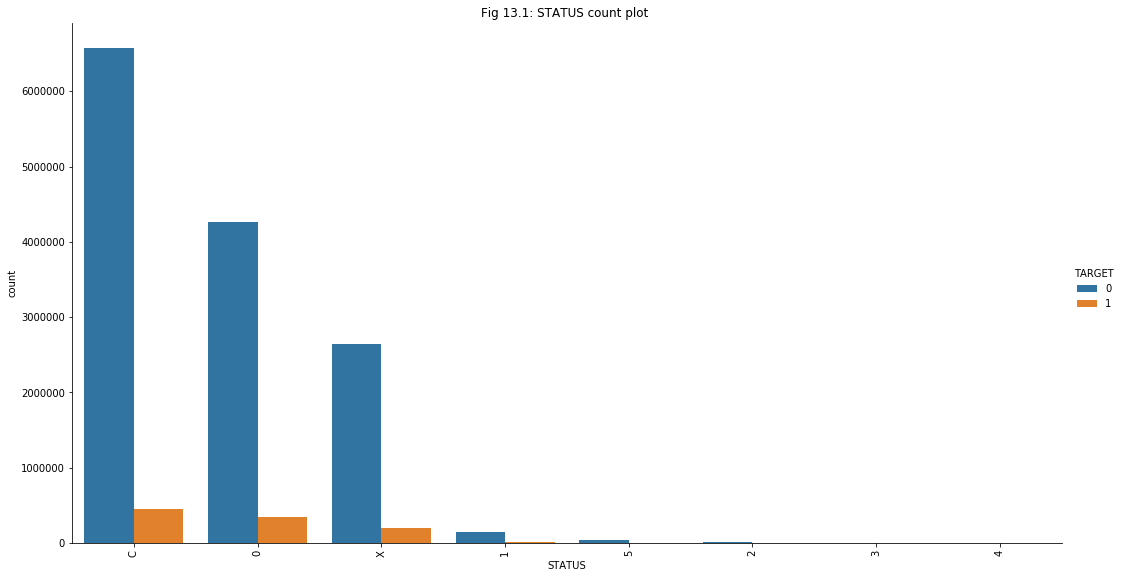

Counts of top 5 values of label 1:


Count of each category  Percentage of count of each category
STATUS                                                              
C                    44.026009                                449189
0                    34.329954                                350262
X                    19.362411                                197551
1                     1.558394                                 15900
5                     0.452326                                  4615

Counts of  top 5 values of label 0:


Count of each category  Percentage of count of each category
STATUS                                                              
C                    48.082939                               6578386
0                    31.176952                               4265422
X                    19.292626                               2639488
1                     1.019126                                139430
5                     0.262496                                 35913

In [26]:
print("Unique values present in {} : {} ".format('STATUS', set(bureau_balance_join_bereau_join_app\
                                                                          ['STATUS'].values)))
print("No of unique values: {}".format(len(set(bureau_balance_join_bereau_join_app['STATUS'].values))))
#plotting countplot in sorted manner for each unique value in the categorical feature
sns.catplot(x='STATUS', kind="count",hue='TARGET', data=bureau_balance_join_bereau_join_app,height=8, \
            aspect=15/8,order=bureau_balance_join_bereau_join_app['STATUS'].value_counts().index).\
set_xticklabels(rotation=90)
plt.title('Fig 13.1: {} count plot '.format('STATUS'))
plt.show()

counts_1_percent,counts_0_percent=agg_count_details(bureau_balance_join_bereau_join_app,'STATUS')

#printing the top 5 values for both labels
print("Counts of top 5 values of label 1:")
display(counts_1_percent.head(5))
print("Counts of  top 5 values of label 0:")
display(counts_0_percent.head(5))

<h3><u>From fig 13.1: Observation:</u></h3><br>
There are 8 unique values in this feature except nan values: '1', '3', '2', '5', '4', 'X', 'C', '0'<br>
closed status seems to indicates to be no defaulter with a 4% more count percentage but for status 0 seems to be 3% higher for deafulter clients.Status 5 is also slightly on the higher side for defaulter clients.

## 8.6 EDA of MONTHS_BALANCE
MONTHS_BALANCE: Month of balance relative to application date (-1 means the freshest balance date)

count    2.417974e+07
mean    -2.791315e+01
std      2.175792e+01
min     -9.600000e+01
25%     -4.100000e+01
50%     -2.300000e+01
75%     -1.000000e+01
max      0.000000e+00
Name: MONTHS_BALANCE, dtype: float64


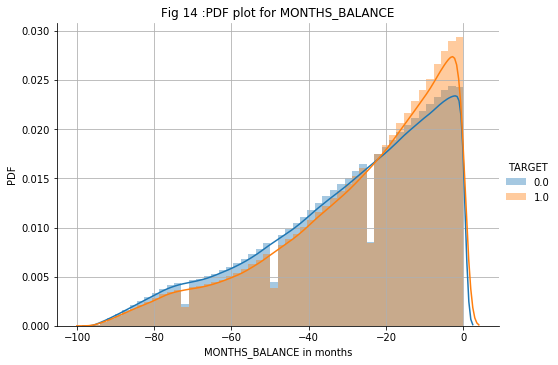

In [13]:
#plotting density plot
print(bureau_balance_join_bereau_join_app.MONTHS_BALANCE.describe())
sns.FacetGrid(data=bureau_balance_join_bereau_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'MONTHS_BALANCE').add_legend()
plt.title('Fig 14 :PDF plot for MONTHS_BALANCE')
plt.xlabel('MONTHS_BALANCE in months')
plt.ylabel('PDF')
plt.grid()


<h3><u>From fig 14: Observation:</u></h3><br>
We have total 96 months of data available, but the recent data will be more useful.<br>
We have more data available in bureau_balance for defaulter clients than the non-defaulter clients for recent 24 month.

# 9. Bureau data analysis

## 9.1 Shape of the Bureau Datasets

In [130]:
print("Shape of bureau: ",bureau.shape)

Shape of bureau:  (1716428, 17)


<h3><u>Observation:</u></h3><br>
There are total 17 features and 1.7 million rows in this dataset

## 9.2 snapshot of bureau data

In [131]:
bureau.head()

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

## 9.3 name of all the 17 features

In [132]:
bureau.columns.values

array(['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY',
       'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE',
       'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT',
       'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE',
       'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY'], dtype=object)

In [134]:
print("Unique values in bureau data SK_ID_CURR: ",len(bureau["SK_ID_CURR"].unique()))

Unique values in bureau data SK_ID_CURR:  305811


<h3><u>Observation:</u></h3><br>
We Have 17 features.<br>
We have several rows for each 'SK_ID_CURR' and there is .3 million unique SK_ID_CURR in the dataset.

## 9.3.1 Joining with application_train

In [27]:
#Joining with application train on 'SK_ID_CURR to get the 'TARGET' label
bereau_join_app=application_train[['SK_ID_CURR','TARGET']].\
merge(bureau,on = 'SK_ID_CURR', how = 'left')

print("After Joining bureau to application data on SK_ID_BUREAU new columns of the joined data: ",\
      bereau_join_app.columns.values)

After Joining bureau to application data on SK_ID_BUREAU new columns of the joined data:  ['SK_ID_CURR' 'TARGET' 'SK_ID_BUREAU' 'CREDIT_ACTIVE' 'CREDIT_CURRENCY'
 'DAYS_CREDIT' 'CREDIT_DAY_OVERDUE' 'DAYS_CREDIT_ENDDATE'
 'DAYS_ENDDATE_FACT' 'AMT_CREDIT_MAX_OVERDUE' 'CNT_CREDIT_PROLONG'
 'AMT_CREDIT_SUM' 'AMT_CREDIT_SUM_DEBT' 'AMT_CREDIT_SUM_LIMIT'
 'AMT_CREDIT_SUM_OVERDUE' 'CREDIT_TYPE' 'DAYS_CREDIT_UPDATE' 'AMT_ANNUITY']


In [29]:
#after joining with application train
bereau_join_app.shape

(1509345, 18)

## 9.4 Missing value Statistics on the 3 features present in the joined data

In [28]:
#checking the information about application train features
miss_value(bereau_join_app)

dtype  Unique values  Number of missing values  \
AMT_ANNUITY             float64          30103                   1174033   
AMT_CREDIT_MAX_OVERDUE  float64          61066                    992565   
DAYS_ENDDATE_FACT       float64           2916                    588693   
AMT_CREDIT_SUM_LIMIT    float64          45290                    533690   
AMT_CREDIT_SUM_DEBT     float64         202918                    267114   
DAYS_CREDIT_ENDDATE     float64          13641                    133118   
AMT_CREDIT_SUM          float64         211528                     44023   
SK_ID_BUREAU            float64        1465325                     44020   
CREDIT_ACTIVE            object              4                     44020   
CREDIT_CURRENCY          object              4                     44020   
DAYS_CREDIT             float64           2923                     44020   
CREDIT_DAY_OVERDUE      float64            893                     44020   
CNT_CREDIT_PROLONG      float64             10                     44020   
AMT_CREDIT_SUM_OVERDUE  float64           1440                     44020   
CREDIT_TYPE              object             15                     44020   
DAYS_CREDIT_UPDATE      float64           2980                     44020   
TARGET                    int64              2                         0   
SK_ID_CURR                int64         307511                         0   

                        Percentage missing  
AMT_ANNUITY                      77.784271  
AMT_CREDIT_MAX_OVERDUE           65.761307  
DAYS_ENDDATE_FACT                39.003210  
AMT_CREDIT_SUM_LIMIT             35.359046  
AMT_CREDIT_SUM_DEBT              17.697346  
DAYS_CREDIT_ENDDATE               8.819587  
AMT_CREDIT_SUM                    2.916696  
SK_ID_BUREAU                      2.916497  
CREDIT_ACTIVE                     2.916497  
CREDIT_CURRENCY                   2.916497  
DAYS_CREDIT                       2.916497  
CREDIT_DAY_OVERDUE                2.916497  
CNT_CREDIT_PROLONG                2.916497  
AMT_CREDIT_SUM_OVERDUE            2.916497  
CREDIT_TYPE                       2.916497  
DAYS_CREDIT_UPDATE                2.916497  
TARGET                            0.000000  
SK_ID_CURR                        0.000000

<h3><u>Observation:</u></h3><br>
AMT_ANNUITY,AMT_CREDIT_MAX_OVERDUE-this filed is missing more than 65% of data



## 9.5 EDA of numerical features

In [31]:
# Name of all the numerical features
bereau_join_app.select_dtypes(exclude='object').columns.values

array(['SK_ID_CURR', 'TARGET', 'SK_ID_BUREAU', 'DAYS_CREDIT',
       'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT',
       'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM',
       'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
       'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY'],
      dtype=object)

## 9.5.1 EDA - DAYS_CREDIT
DAYS_CREDIT: How many days before current application did client apply for Credit Bureau credit

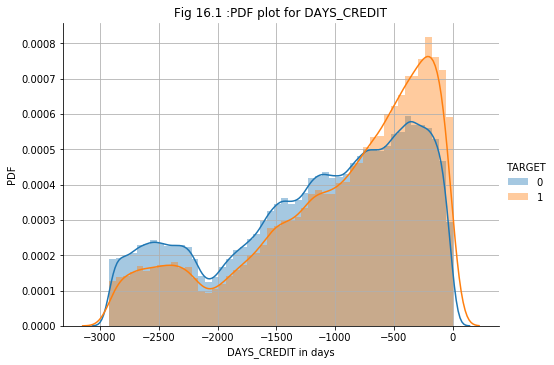

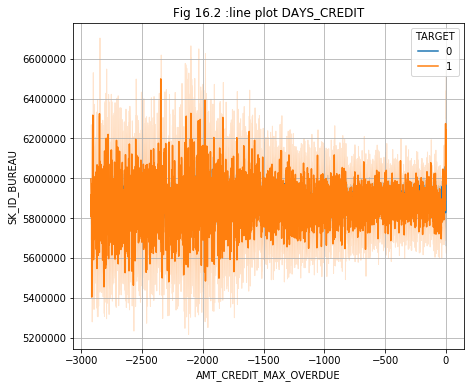



 Few statistical Informaion:


count    1.465325e+06
mean    -1.143600e+03
std      8.000200e+02
min     -2.922000e+03
25%     -1.671000e+03
50%     -9.850000e+02
75%     -4.700000e+02
max      0.000000e+00
Name: DAYS_CREDIT, dtype: float64


In [69]:
#plotting density plot
sns.FacetGrid(data=bereau_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'DAYS_CREDIT').add_legend()
plt.title('Fig 16.1 :PDF plot for DAYS_CREDIT')
plt.xlabel('DAYS_CREDIT in days')
plt.ylabel('PDF')
plt.grid()
plt.show()
plt.figure(figsize=(7,6))
sns.lineplot(y=bereau_join_app.SK_ID_BUREAU,x=bereau_join_app.DAYS_CREDIT,sort=True,hue=bereau_join_app.TARGET)
plt.title('Fig 16.2 :line plot DAYS_CREDIT')
plt.xlabel('AMT_CREDIT_MAX_OVERDUE')
plt.ylabel('SK_ID_BUREAU')
plt.grid()
plt.show()
print("\n\n Few statistical Informaion:\n\n")
print(bereau_join_app.DAYS_CREDIT.describe())

<h3><u>From fig 16: Observation:</u></h3><br>
we have a range of past 2992 days information, which is well distributed for both the labels and recent information is mostly available

## 9.5.2 EDA - CREDIT_DAY_OVERDUE: Number of days past due on CB credit at the time of application for related loan in our sample


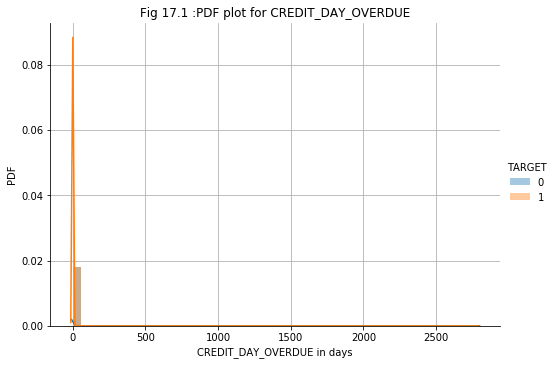

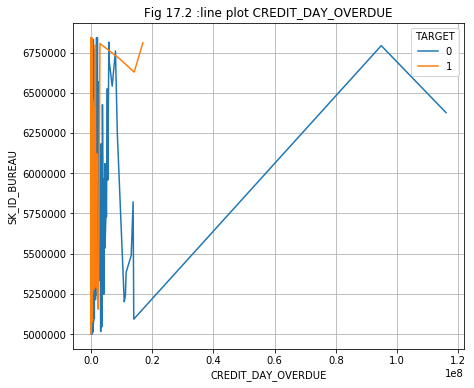



 Few statistical Informaion:


count    1.465325e+06
mean     8.887612e-01
std      3.824707e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.792000e+03
Name: CREDIT_DAY_OVERDUE, dtype: float64


In [70]:
#plotting density plot
sns.FacetGrid(data=bereau_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'CREDIT_DAY_OVERDUE').add_legend()
plt.title('Fig 17.1 :PDF plot for CREDIT_DAY_OVERDUE')
plt.xlabel('CREDIT_DAY_OVERDUE in days')
plt.ylabel('PDF')
plt.grid()
plt.show()
plt.figure(figsize=(7,6))
sns.lineplot(y=bereau_join_app.SK_ID_BUREAU,x=bereau_join_app.AMT_CREDIT_MAX_OVERDUE,sort=True,hue=bereau_join_app.TARGET)
plt.title('Fig 17.2 :line plot CREDIT_DAY_OVERDUE')
plt.xlabel('CREDIT_DAY_OVERDUE')
plt.ylabel('SK_ID_BUREAU')
plt.grid()
plt.show()
print("\n\n Few statistical Informaion:\n\n")
print(bereau_join_app.CREDIT_DAY_OVERDUE.describe())

<h3><u>From fig 17: Observation:</u></h3><br>
The distribution is highly right skewed.Very less client have more days overdue where as most client have 0 overdue.

## 9.5.3 EDA - DAYS_CREDIT_ENDDATE: Remaining duration of CB credit (in days) at the time of application in Home Credit


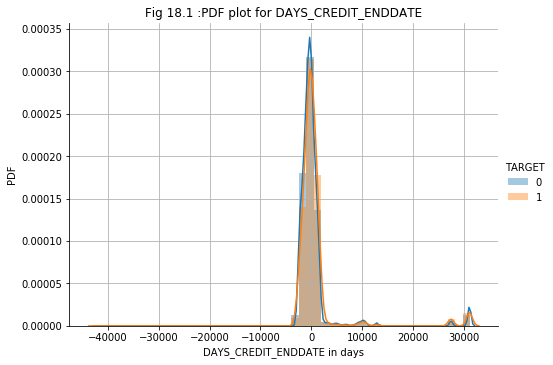

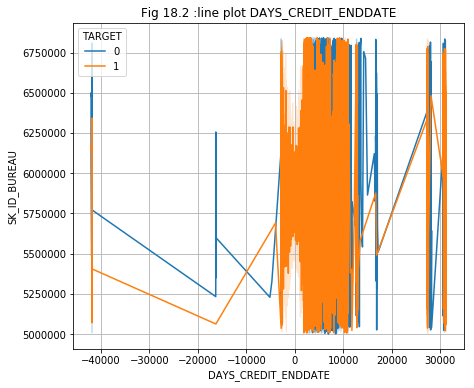



 Few statistical Informaion:


count    1.376227e+06
mean     4.931322e+02
std      4.964905e+03
min     -4.206000e+04
25%     -1.144000e+03
50%     -3.340000e+02
75%      4.730000e+02
max      3.119900e+04
Name: DAYS_CREDIT_ENDDATE, dtype: float64


In [71]:
#plotting density plot
sns.FacetGrid(data=bereau_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'DAYS_CREDIT_ENDDATE').add_legend()
plt.title('Fig 18.1 :PDF plot for DAYS_CREDIT_ENDDATE')
plt.xlabel('DAYS_CREDIT_ENDDATE in days')
plt.ylabel('PDF')
plt.grid()
plt.show()
plt.figure(figsize=(7,6))
sns.lineplot(y=bereau_join_app.SK_ID_BUREAU,x=bereau_join_app.DAYS_CREDIT_ENDDATE,sort=True,hue=bereau_join_app.TARGET)
plt.title('Fig 18.2 :line plot DAYS_CREDIT_ENDDATE')
plt.xlabel('DAYS_CREDIT_ENDDATE')
plt.ylabel('SK_ID_BUREAU')
plt.grid()
plt.show()
print("\n\n Few statistical Informaion:\n\n")
print(bereau_join_app.DAYS_CREDIT_ENDDATE.describe())

<h3><u>From fig 18: Observation:</u></h3><br>
the density is high around 0 .<br>
min value=42060 days(114 year) in past , seems to be an outlier.<br>
max future day value=31199.0 (89 year) may not be an outlier and many client have still balance left in CB credit

## 9.5.4 EDA - DAYS_ENDDATE_FACT: Days since CB credit ended at the time of application in Home Credit (only for closed credit)


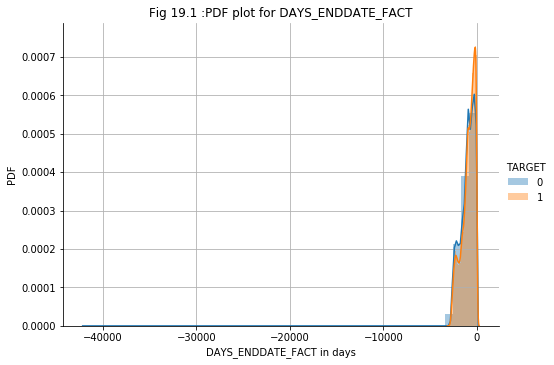

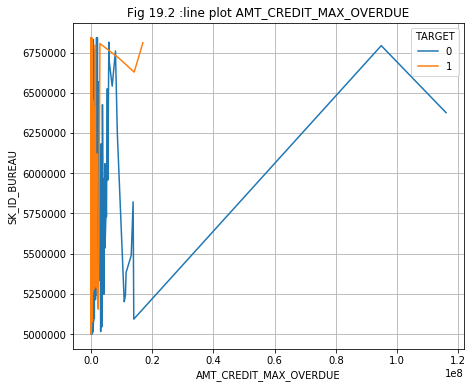



 Few statistical Informaion:


count    920652.000000
mean      -1022.765286
std         718.371749
min      -42023.000000
25%       -1503.000000
50%        -900.000000
75%        -427.000000
max           0.000000
Name: DAYS_ENDDATE_FACT, dtype: float64


In [72]:
#plotting density plot
sns.FacetGrid(data=bereau_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'DAYS_ENDDATE_FACT').add_legend()
plt.title('Fig 19.1 :PDF plot for DAYS_ENDDATE_FACT')
plt.xlabel('DAYS_ENDDATE_FACT in days')
plt.ylabel('PDF')
plt.grid()
plt.show()
plt.figure(figsize=(7,6))
sns.lineplot(y=bereau_join_app.SK_ID_BUREAU,x=bereau_join_app.AMT_CREDIT_MAX_OVERDUE,sort=True,hue=bereau_join_app.TARGET)
plt.title('Fig 19.2 :line plot AMT_CREDIT_MAX_OVERDUE')
plt.xlabel('AMT_CREDIT_MAX_OVERDUE')
plt.ylabel('SK_ID_BUREAU')
plt.grid()
plt.show()
print("\n\n Few statistical Informaion:\n\n")
print(bereau_join_app.DAYS_ENDDATE_FACT.describe())

<h3><u>From fig 19: Observation:</u></h3><br>
The distribution is hevily skewed in the left side as the information available o to negetive menas past days.<br>
the density is high around 0, means most client closed their CB credit application before applying in home credit .<br>
min value=-42023 days(100 year+) in past , seems to be an outlier
Only past data availavle

## 9.5.5 EDA - DAYS_CREDIT_UPDATE: How many days before loan application did last information about the Credit Bureau credit come


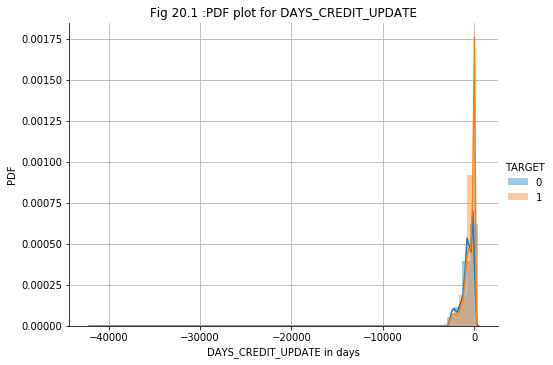

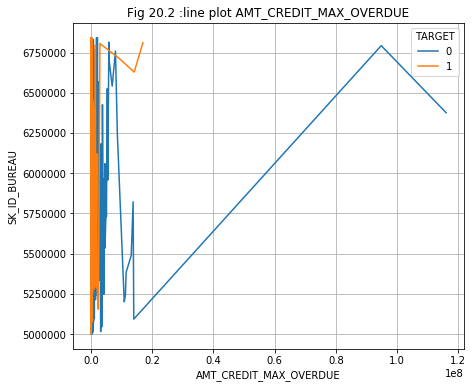



 Few statistical Informaion:


count    1.465325e+06
mean    -5.997869e+02
std      7.371010e+02
min     -4.194700e+04
25%     -9.040000e+02
50%     -4.060000e+02
75%     -3.300000e+01
max      3.720000e+02
Name: DAYS_CREDIT_UPDATE, dtype: float64


In [73]:
#plotting density plot
sns.FacetGrid(data=bereau_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'DAYS_CREDIT_UPDATE').add_legend()
plt.title('Fig 20.1 :PDF plot for DAYS_CREDIT_UPDATE')
plt.xlabel('DAYS_CREDIT_UPDATE in days')
plt.ylabel('PDF')
plt.grid()
plt.show()
plt.figure(figsize=(7,6))
sns.lineplot(y=bereau_join_app.SK_ID_BUREAU,x=bereau_join_app.AMT_CREDIT_MAX_OVERDUE,sort=True,hue=bereau_join_app.TARGET)
plt.title('Fig 20.2 :line plot AMT_CREDIT_MAX_OVERDUE')
plt.xlabel('AMT_CREDIT_MAX_OVERDUE')
plt.ylabel('SK_ID_BUREAU')
plt.grid()
plt.show()
print("\n\n Few statistical Informaion:\n\n")
print(bereau_join_app.DAYS_CREDIT_UPDATE.describe())

<h3><u>From fig 20: Observation:</u></h3><br>
The distribution is hevily skewed in the left side as the information available o to negetive menas past days.<br>
the density is high around 0, most recently the CB information came for most clients .<br>
min value=-42023 days(100 year+) in past , seems to be an outlier
Only past data availavle

## 9.5.6 EDA - AMT_CREDIT_MAX_OVERDUE: Maximal amount overdue on the Credit Bureau credit so far (at application date of loan in our sample)


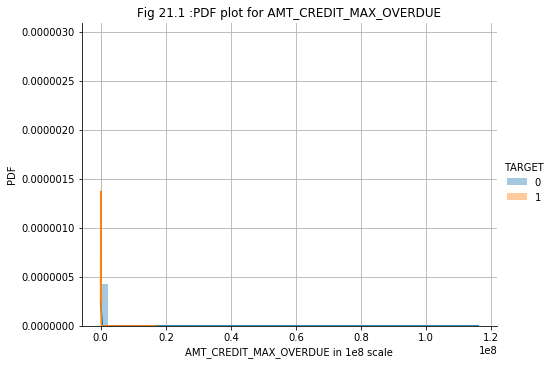

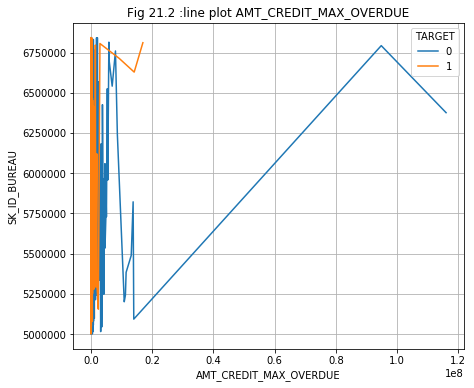



 Few statistical Informaion:


count    5.167800e+05
mean     3.942852e+03
std      2.196856e+05
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.159872e+08
Name: AMT_CREDIT_MAX_OVERDUE, dtype: float64


In [74]:
#plotting density plot
sns.FacetGrid(data=bereau_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'AMT_CREDIT_MAX_OVERDUE').add_legend()
plt.title('Fig 21.1 :PDF plot for AMT_CREDIT_MAX_OVERDUE')
plt.xlabel('AMT_CREDIT_MAX_OVERDUE in 1e8 scale')
plt.ylabel('PDF')
plt.grid()
plt.show()
plt.figure(figsize=(7,6))
sns.lineplot(y=bereau_join_app.SK_ID_BUREAU,x=bereau_join_app.AMT_CREDIT_MAX_OVERDUE,sort=True,hue=bereau_join_app.TARGET)
plt.title('Fig 21.2 :line plot AMT_CREDIT_MAX_OVERDUE')
plt.xlabel('AMT_CREDIT_MAX_OVERDUE')
plt.ylabel('SK_ID_BUREAU')
plt.grid()
plt.show()
print("\n\n Few statistical Informaion:\n\n")
print(bereau_join_app.AMT_CREDIT_MAX_OVERDUE.describe())

In [49]:
bereau_join_app[bereau_join_app['AMT_CREDIT_MAX_OVERDUE']>.2e8]['AMT_CREDIT_MAX_OVERDUE']

SK_ID_BUREAU
6793130.0     94812246.0
6376438.0    115987185.0
Name: AMT_CREDIT_MAX_OVERDUE, dtype: float64

<h3><u>From fig 21: Observation:</u></h3><br>
the density is high around 0, data heavily right skewed.<br>
value has range between 0 to 1.159872e+08 and with standard deviation of 2.196856e+05
94812246.0,115987185.0-these two value is in the higher range from other values , may be suspected as outlier as rest of the values are in 0 to 0.2e+08 rarnge.

## 9.5.7 EDA - CNT_CREDIT_PROLONG: How many times was the Credit Bureau credit prolonged


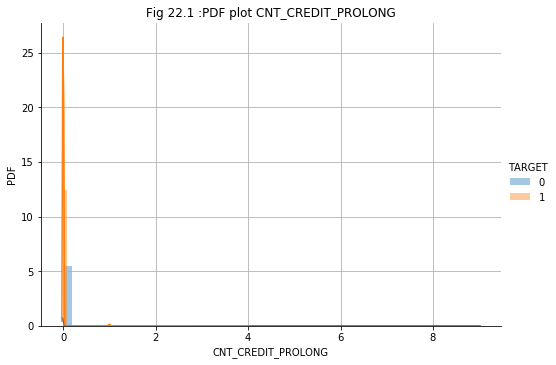

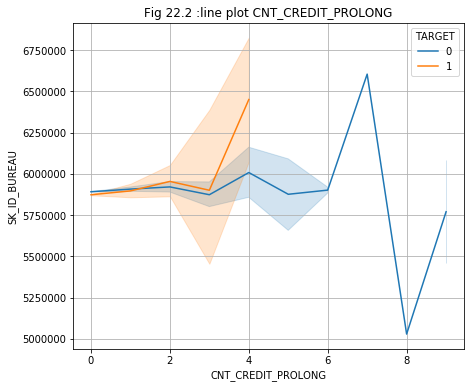



 Few statistical Informaion:


count    1.465325e+06
mean     7.278249e-03
std      1.026408e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      9.000000e+00
Name: CNT_CREDIT_PROLONG, dtype: float64


In [75]:
#plotting density plot
sns.FacetGrid(data=bereau_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'CNT_CREDIT_PROLONG').add_legend()
plt.title('Fig 22.1 :PDF plot CNT_CREDIT_PROLONG')
plt.xlabel('CNT_CREDIT_PROLONG')
plt.ylabel('PDF')
plt.grid()
plt.show()
plt.figure(figsize=(7,6))
sns.lineplot(y=bereau_join_app.SK_ID_BUREAU,x=bereau_join_app.CNT_CREDIT_PROLONG,sort=True,hue=bereau_join_app.TARGET)
plt.title('Fig 22.2 :line plot CNT_CREDIT_PROLONG')
plt.xlabel('CNT_CREDIT_PROLONG')
plt.ylabel('SK_ID_BUREAU')
plt.grid()
plt.show()
print("\n\n Few statistical Informaion:\n\n")
print(bereau_join_app.CNT_CREDIT_PROLONG.describe())

<h3><u>From fig 22: Observation:</u></h3><br>
the density is high around 0, most clients did not prolonged their credit.<br>
The range is between 0 to 8, max 8 times clients prolonged their credits. In the available sample defaulter clients have 4 time max prolonged their creidts

## 9.5.8 EDA - AMT_CREDIT_SUM: Current credit amount for the Credit Bureau credit


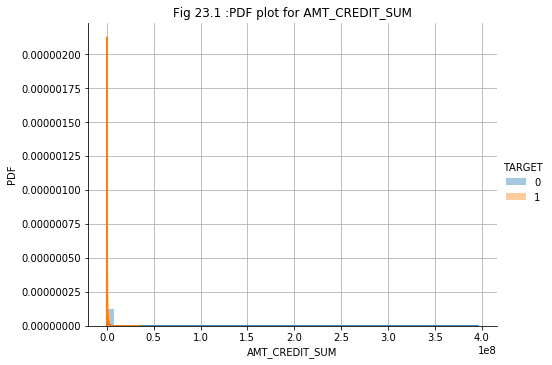

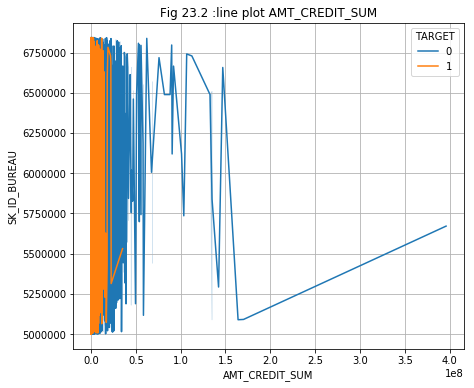



 Few statistical Informaion:


count    1.465322e+06
mean     3.516889e+05
std      1.078009e+06
min      0.000000e+00
25%      5.116500e+04
50%      1.246981e+05
75%      3.082500e+05
max      3.960000e+08
Name: AMT_CREDIT_SUM, dtype: float64


In [76]:
#plotting density plot
sns.FacetGrid(data=bereau_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'AMT_CREDIT_SUM').add_legend()
plt.title('Fig 23.1 :PDF plot for AMT_CREDIT_SUM')
plt.xlabel('AMT_CREDIT_SUM')
plt.ylabel('PDF')
plt.grid()
plt.show()
plt.figure(figsize=(7,6))
sns.lineplot(y=bereau_join_app.SK_ID_BUREAU,x=bereau_join_app.AMT_CREDIT_SUM,sort=True,hue=bereau_join_app.TARGET)
plt.title('Fig 23.2 :line plot AMT_CREDIT_SUM')
plt.xlabel('AMT_CREDIT_SUM')
plt.ylabel('SK_ID_BUREAU')
plt.grid()
plt.show()
print("\n\n Few statistical Informaion:\n\n")
print(bereau_join_app.AMT_CREDIT_SUM.describe())


<h3><u>From fig 23: Observation:</u></h3><br>
The distribution is heavily right skewed.Most client have zero credit in credit bureau.<br>
The value ranges from 0 to 585000000 .The max value might be outlier as if the credit is already there , no need to apply for another loan

## 9.5.9 EDA - AMT_CREDIT_SUM_DEBT: Current debt on Credit Bureau credit


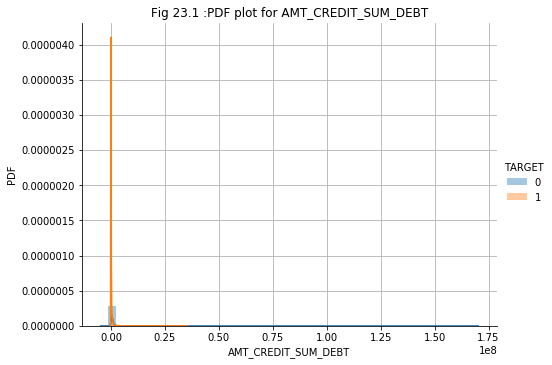

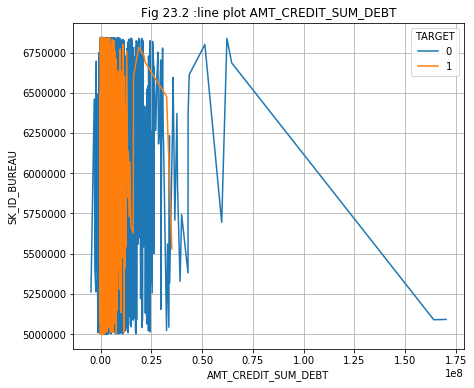



 Few statistical Informaion:


count    1.465322e+06
mean     3.516889e+05
std      1.078009e+06
min      0.000000e+00
25%      5.116500e+04
50%      1.246981e+05
75%      3.082500e+05
max      3.960000e+08
Name: AMT_CREDIT_SUM, dtype: float64


In [77]:
#plotting density plot
sns.FacetGrid(data=bereau_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'AMT_CREDIT_SUM_DEBT').add_legend()
plt.title('Fig 24.1 :PDF plot for AMT_CREDIT_SUM_DEBT')
plt.xlabel('AMT_CREDIT_SUM_DEBT')
plt.ylabel('PDF')
plt.grid()
plt.show()
plt.figure(figsize=(7,6))
sns.lineplot(y=bereau_join_app.SK_ID_BUREAU,x=bereau_join_app.AMT_CREDIT_SUM_DEBT,sort=True,hue=bereau_join_app.TARGET)
plt.title('Fig 24.2 :line plot AMT_CREDIT_SUM_DEBT')
plt.xlabel('AMT_CREDIT_SUM_DEBT')
plt.ylabel('SK_ID_BUREAU')
plt.grid()
plt.show()
print("\n\n Few statistical Informaion:\n\n")
print(bereau_join_app.AMT_CREDIT_SUM.describe())


In [83]:
bereau_join_app[bereau_join_app['AMT_CREDIT_SUM_DEBT']>1.5e8]['AMT_CREDIT_SUM_DEBT']

SK_ID_BUREAU
5089138.0    164032200.0
5090928.0    170100000.0
Name: AMT_CREDIT_SUM_DEBT, dtype: float64

<h3><u>From fig 24: Observation:</u></h3><br>
The distribution is heavily right skewed.The value ranges from 0 to 170100000.Most clietns have zero debt to Credit bureau<br>
Values more than 1.5e8 might be an outlier

## 9.5.10 AMT_CREDIT_SUM_LIMIT: Current credit limit of credit card reported in Credit Bureau


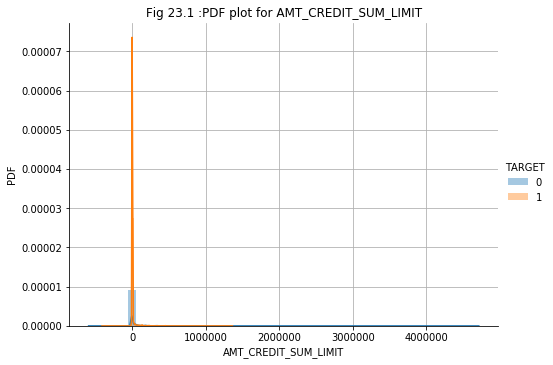

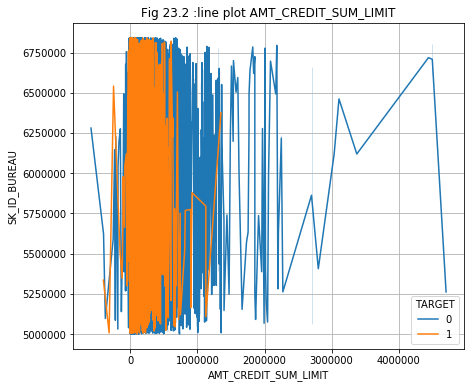



 Few statistical Informaion:


count    1.465322e+06
mean     3.516889e+05
std      1.078009e+06
min      0.000000e+00
25%      5.116500e+04
50%      1.246981e+05
75%      3.082500e+05
max      3.960000e+08
Name: AMT_CREDIT_SUM, dtype: float64


In [78]:
#plotting density plot
sns.FacetGrid(data=bereau_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'AMT_CREDIT_SUM_LIMIT').add_legend()
plt.title('Fig 25.1 :PDF plot for AMT_CREDIT_SUM_LIMIT')
plt.xlabel('AMT_CREDIT_SUM_LIMIT')
plt.ylabel('PDF')
plt.grid()
plt.show()
plt.figure(figsize=(7,6))
sns.lineplot(y=bereau_join_app.SK_ID_BUREAU,x=bereau_join_app.AMT_CREDIT_SUM_LIMIT,sort=True,hue=bereau_join_app.TARGET)
plt.title('Fig 25.2 :line plot AMT_CREDIT_SUM_LIMIT')
plt.xlabel('AMT_CREDIT_SUM_LIMIT')
plt.ylabel('SK_ID_BUREAU')
plt.grid()
plt.show()
print("\n\n Few statistical Informaion:\n\n")
print(bereau_join_app.AMT_CREDIT_SUM.describe())


<h3><u>From fig 25: Observation:</u></h3><br>
The distribution is heavilty right skewed.<br>
current credit limit of most client is zero<br>
The values ranges from o to 4.705600e+06

## 9.5.11 AMT_CREDIT_SUM_OVERDUE: Current amount overdue on Credit Bureau credit


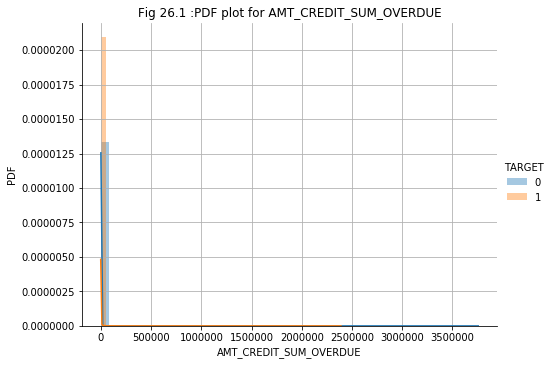

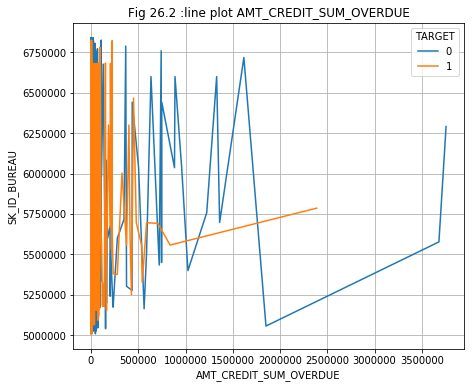



 Few statistical Informaion:


count    1.465325e+06
mean     4.010547e+01
std      6.273639e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.756681e+06
Name: AMT_CREDIT_SUM_OVERDUE, dtype: float64


In [79]:
#plotting density plot
sns.FacetGrid(data=bereau_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'AMT_CREDIT_SUM_OVERDUE').add_legend()
plt.title('Fig 26.1 :PDF plot for AMT_CREDIT_SUM_OVERDUE')
plt.xlabel('AMT_CREDIT_SUM_OVERDUE')
plt.ylabel('PDF')
plt.grid()
plt.show()
plt.figure(figsize=(7,6))
sns.lineplot(y=bereau_join_app.SK_ID_BUREAU,x=bereau_join_app.AMT_CREDIT_SUM_OVERDUE,sort=True,hue=bereau_join_app.TARGET)
plt.title('Fig 26.2 :line plot AMT_CREDIT_SUM_OVERDUE')
plt.xlabel('AMT_CREDIT_SUM_OVERDUE')
plt.ylabel('SK_ID_BUREAU')
plt.grid()
plt.show()
print("\n\n Few statistical Informaion:\n\n")
print(bereau_join_app.AMT_CREDIT_SUM_OVERDUE.describe())


In [82]:
len(bereau_join_app[bereau_join_app['AMT_CREDIT_SUM_OVERDUE']>3.5e5]['AMT_CREDIT_SUM_OVERDUE'])

35

<h3><u>From fig 26: Observation:</u></h3><br>
The distribution is heavilty right skewed.<br>
current due of most client is zero<br>
The values ranges from o to 3.756681e+06, values more than 3.5e5 might be an outlier

## 9.5.12 AMT_ANNUITY: Annuity of the Credit Bureau credit


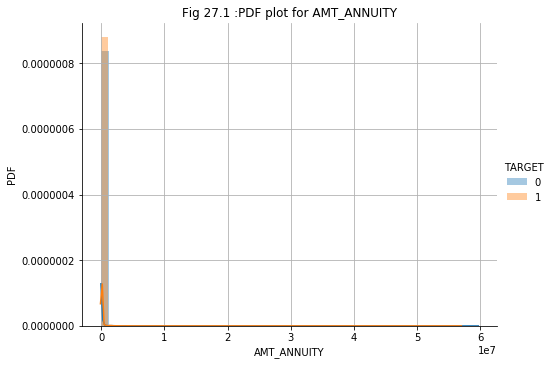

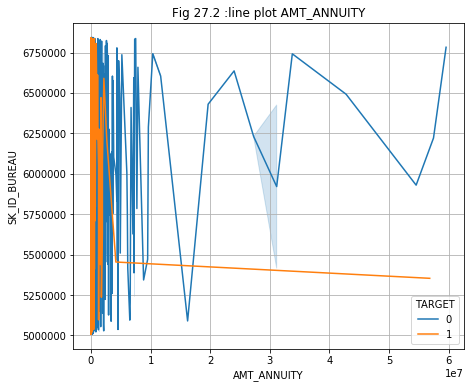



 Few statistical Informaion:


count    3.353120e+05
mean     1.576301e+04
std      2.681074e+05
min      0.000000e+00
25%      0.000000e+00
50%      6.750000e+01
75%      1.399050e+04
max      5.958668e+07
Name: AMT_ANNUITY, dtype: float64


In [80]:
#plotting density plot
sns.FacetGrid(data=bereau_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'AMT_ANNUITY').add_legend()
plt.title('Fig 27.1 :PDF plot for AMT_ANNUITY')
plt.xlabel('AMT_ANNUITY')
plt.ylabel('PDF')
plt.grid()
plt.show()
plt.figure(figsize=(7,6))
sns.lineplot(y=bereau_join_app.SK_ID_BUREAU,x=bereau_join_app.AMT_ANNUITY,sort=True,hue=bereau_join_app.TARGET)
plt.title('Fig 27.2 :line plot AMT_ANNUITY')
plt.xlabel('AMT_ANNUITY')
plt.ylabel('SK_ID_BUREAU')
plt.grid()
plt.show()
print("\n\n Few statistical Informaion:\n\n")
print(bereau_join_app.AMT_ANNUITY.describe())


<h3><u>From fig 27: Observation:</u></h3><br>
The distribution is heavilty right skewed.<br>
current due of most client is zero<br>
The values ranges from o to 5.958668e+07

## 9.6 EDA of categorical features

In [85]:
#name of all the categorical features
bereau_join_app.select_dtypes('object').columns.values

array(['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE'], dtype=object)

## 9.6.1 EDA-CREDIT_ACTIVE: Status of the Credit Bureau (CB) reported credits

Unique values present in CREDIT_ACTIVE : {nan, 'Active', 'Closed', 'Bad debt', 'Sold'} 
No of unique values: 5


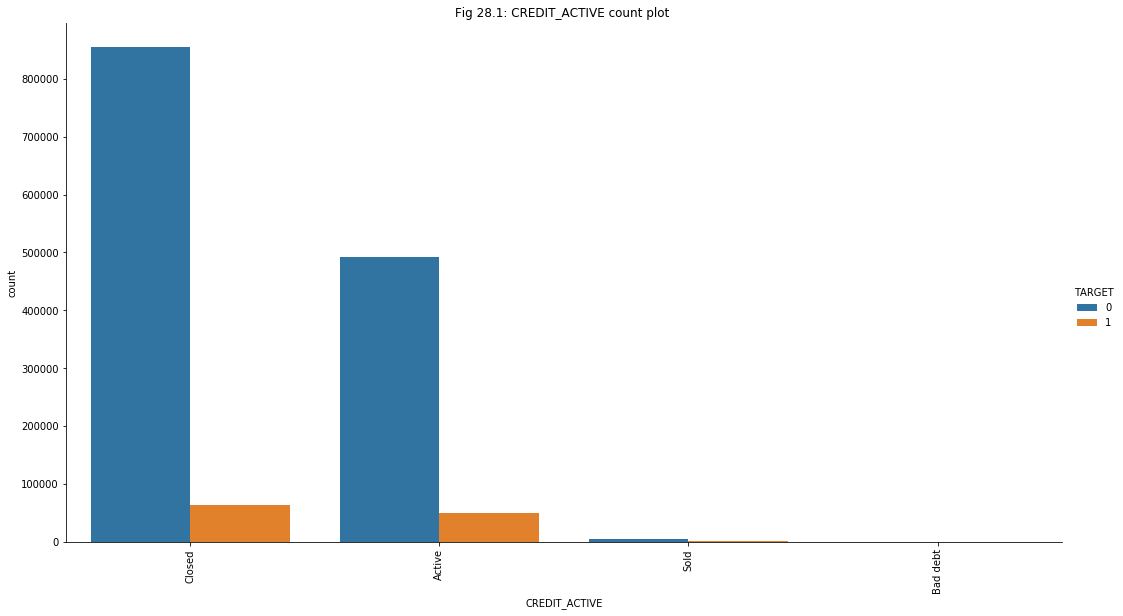

Counts of top 5 values of label 1:


Count of each category  Percentage of count of each category
CREDIT_ACTIVE                                                              
Closed                      55.544010                                 63609
Active                      43.953895                                 50336
Sold                         0.498603                                   571
Bad debt                     0.003493                                     4

Counts of  top 5 values of label 0:


Count of each category  Percentage of count of each category
CREDIT_ACTIVE                                                              
Closed                      63.230740                                854124
Active                      36.391855                                491583
Sold                         0.376220                                  5082
Bad debt                     0.001184                                    16

In [87]:
print("Unique values present in {} : {} ".format('CREDIT_ACTIVE', set(bereau_join_app\
                                                                          ['CREDIT_ACTIVE'].values)))
print("No of unique values: {}".format(len(set(bereau_join_app['CREDIT_ACTIVE'].values))))
#plotting countplot in sorted manner for each unique value in the categorical feature
sns.catplot(x='CREDIT_ACTIVE', kind="count",hue='TARGET', data=bereau_join_app,height=8, \
            aspect=15/8,order=bereau_join_app['CREDIT_ACTIVE'].value_counts().index).\
set_xticklabels(rotation=90)
plt.title('Fig 28.1: {} count plot '.format('CREDIT_ACTIVE'))
plt.show()

counts_1_percent,counts_0_percent=agg_count_details(bereau_join_app,'CREDIT_ACTIVE')

#printing the top 5 values for both labels
print("Counts of top 5 values of label 1:")
display(counts_1_percent.head(5))
print("Counts of  top 5 values of label 0:")
display(counts_0_percent.head(5))

<h3><u>From fig 28.1: Observation:</u></h3><br>
There are 4 unique values except nan :'Active', 'Closed', 'Bad debt', 'Sold'. In the sample for defaulter client seems to have more active credit type available 

## 9.6.2 EDA-CREDIT_CURRENCY: Recoded currency of the Credit Bureau credit

Unique values present in CREDIT_CURRENCY : {nan, 'currency 4', 'currency 3', 'currency 1', 'currency 2'} 
No of unique values: 5


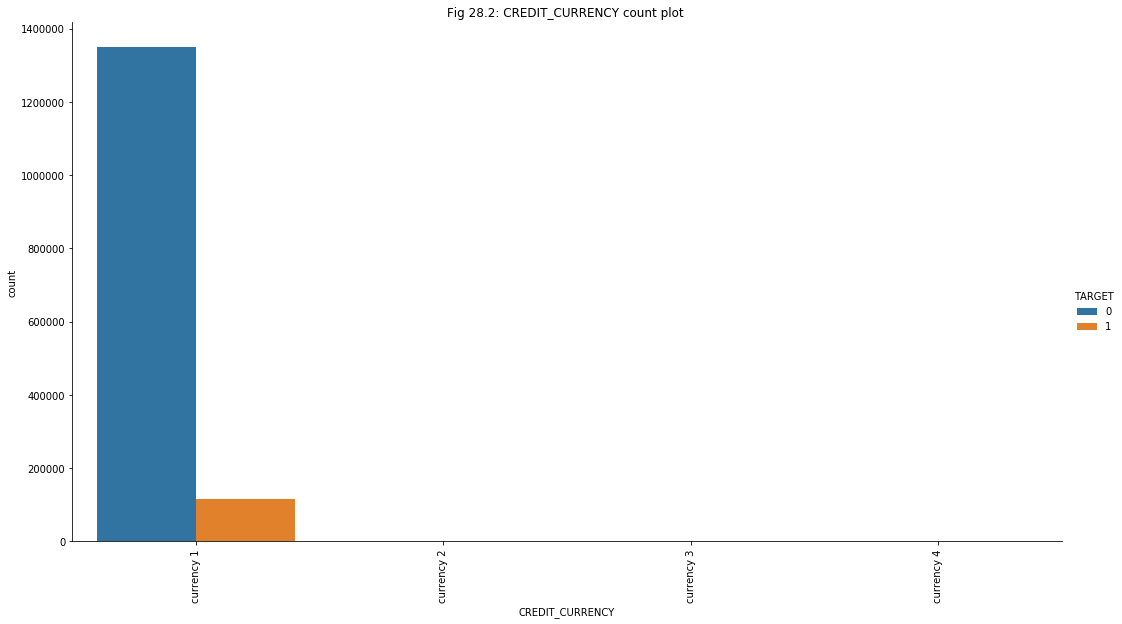

Counts of top 5 values of label 1:


Count of each category  Percentage of count of each category
CREDIT_CURRENCY                                                              
currency 1                    99.942368                                114454
currency 2                     0.042787                                    49
currency 3                     0.014845                                    17
currency 4                     0.000000                                     0

Counts of  top 5 values of label 0:


Count of each category  Percentage of count of each category
CREDIT_CURRENCY                                                              
currency 1                    99.913755                               1349640
currency 2                     0.075733                                  1023
currency 3                     0.009846                                   133
currency 4                     0.000666                                     9

In [88]:
print("Unique values present in {} : {} ".format('CREDIT_CURRENCY', set(bereau_join_app\
                                                                          ['CREDIT_CURRENCY'].values)))
print("No of unique values: {}".format(len(set(bereau_join_app['CREDIT_CURRENCY'].values))))
#plotting countplot in sorted manner for each unique value in the categorical feature
sns.catplot(x='CREDIT_CURRENCY', kind="count",hue='TARGET', data=bereau_join_app,height=8, \
            aspect=15/8,order=bereau_join_app['CREDIT_CURRENCY'].value_counts().index).\
set_xticklabels(rotation=90)
plt.title('Fig 28.2: {} count plot '.format('CREDIT_CURRENCY'))
plt.show()

counts_1_percent,counts_0_percent=agg_count_details(bereau_join_app,'CREDIT_CURRENCY')

#printing the top 5 values for both labels
print("Counts of top 5 values of label 1:")
display(counts_1_percent.head(5))
print("Counts of  top 5 values of label 0:")
display(counts_0_percent.head(5))

<h3><u>From fig 28.2: Observation:</u></h3><br>
There are 4 unique values except nan :'currency 4', 'currency 3', 'currency 1', 'currency 2'. 

## 9.6.3 EDA-CREDIT_TYPE: Type of Credit Bureau credit (Car, cash,...)

Unique values present in CREDIT_TYPE : {nan, 'Real estate loan', 'Loan for purchase of shares (margin lending)', 'Interbank credit', 'Cash loan (non-earmarked)', 'Car loan', 'Microloan', 'Loan for the purchase of equipment', 'Credit card', 'Another type of loan', 'Mobile operator loan', 'Consumer credit', 'Loan for working capital replenishment', 'Unknown type of loan', 'Loan for business development', 'Mortgage'} 
No of unique values: 16


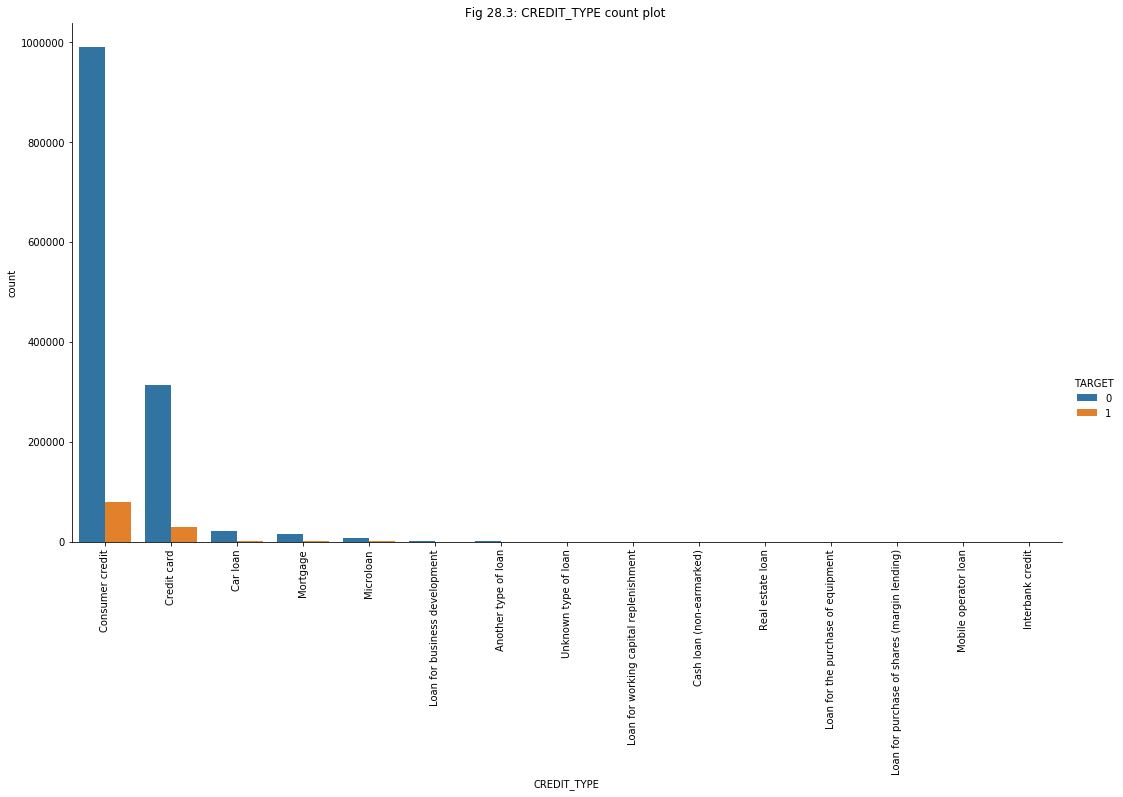

Counts of top 5 values of label 1:


Count of each category  Percentage of count of each category
CREDIT_TYPE                                                                  
Consumer credit               69.896961                                 80046
Credit card                   26.425079                                 30262
Microloan                      1.623297                                  1859
Car loan                       1.156130                                  1324
Mortgage                       0.681104                                   780

Counts of  top 5 values of label 0:


Count of each category  Percentage of count of each category
CREDIT_TYPE                                                                  
Consumer credit               73.257354                                989564
Credit card                   23.215120                                313591
Car loan                       1.660713                                 22433
Mortgage                       1.097642                                 14827
Microloan                      0.529018                                  7146

In [89]:
print("Unique values present in {} : {} ".format('CREDIT_TYPE', set(bereau_join_app\
                                                                          ['CREDIT_TYPE'].values)))
print("No of unique values: {}".format(len(set(bereau_join_app['CREDIT_TYPE'].values))))
#plotting countplot in sorted manner for each unique value in the categorical feature
sns.catplot(x='CREDIT_TYPE', kind="count",hue='TARGET', data=bereau_join_app,height=8, \
            aspect=15/8,order=bereau_join_app['CREDIT_TYPE'].value_counts().index).\
set_xticklabels(rotation=90)
plt.title('Fig 28.3: {} count plot '.format('CREDIT_TYPE'))
plt.show()

counts_1_percent,counts_0_percent=agg_count_details(bereau_join_app,'CREDIT_TYPE')

#printing the top 5 values for both labels
print("Counts of top 5 values of label 1:")
display(counts_1_percent.head(5))
print("Counts of  top 5 values of label 0:")
display(counts_0_percent.head(5))

<h3><u>From fig 28.3: Observation:</u></h3><br>
There are 15 unique values except nan :'Real estate loan', 'Loan for purchase of shares (margin lending)', 'Interbank credit', 'Cash loan (non-earmarked)', 'Car loan', 'Microloan', 'Loan for the purchase of equipment', 'Credit card', 'Another type of loan', 'Mobile operator loan', 'Consumer credit', 'Loan for working capital replenishment', 'Unknown type of loan', 'Loan for business development', 'Mortgage'

# 10. installments_payments data analysis

## 10.1 Shape of the installments_payments Datasets

In [90]:
print("Shape of installments_payments: ",installments_payments.shape)

Shape of installments_payments:  (13605401, 8)


<h3><u>Observation:</u></h3><br>
There are total 8 features and 13 million rows in this dataset

## 10.2 snapshot of installments_payments data

In [91]:
installments_payments.head()

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   
2     2085231      193053                     2.0                      1   
3     2452527      199697                     1.0                      3   
4     2714724      167756                     1.0                      2   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0          -1180.0             -1187.0        6948.360     6948.360  
1          -2156.0             -2156.0        1716.525     1716.525  
2            -63.0               -63.0       25425.000    25425.000  
3          -2418.0             -2426.0       24350.130    24350.130  
4          -1383.0             -1366.0        2165.040     2160.585

## 10.3 name of all the features

In [92]:
installments_payments.columns.values

array(['SK_ID_PREV', 'SK_ID_CURR', 'NUM_INSTALMENT_VERSION',
       'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT',
       'AMT_INSTALMENT', 'AMT_PAYMENT'], dtype=object)

In [95]:
print("Unique values in installments_payments data SK_ID_CURR: ",len(installments_payments["SK_ID_CURR"].unique()))
print("Unique values in installments_payments data SK_ID_PREV: ",len(installments_payments["SK_ID_PREV"].unique()))

Unique values in installments_payments data SK_ID_CURR:  339587
Unique values in installments_payments data SK_ID_PREV:  997752


<h3><u>Observation:</u></h3><br>
We Have 8 features.<br>
We have several rows for each 'SK_ID_CURR' and there is .33 million unique SK_ID_CURR in the dataset.
We have several rows for each 'SK_ID_PREV' and there is .99 million unique SK_ID_CURR in the dataset.

## 10.3.1 Joining with application_train

In [96]:
#Joining with application train on 'SK_ID_CURR to get the 'TARGET' label
installments_payments_join_app=application_train[['SK_ID_CURR','TARGET']].\
merge(installments_payments,on = 'SK_ID_CURR', how = 'left')

print("After Joining bureau to application data on SK_ID_BUREAU new columns of the joined data: ",\
      installments_payments_join_app.columns.values)

After Joining bureau to application data on SK_ID_BUREAU new columns of the joined data:  ['SK_ID_CURR' 'TARGET' 'SK_ID_PREV' 'NUM_INSTALMENT_VERSION'
 'NUM_INSTALMENT_NUMBER' 'DAYS_INSTALMENT' 'DAYS_ENTRY_PAYMENT'
 'AMT_INSTALMENT' 'AMT_PAYMENT']


In [97]:
#after joining with application train
installments_payments_join_app.shape

(11607460, 9)

## 10.4 Missing value Statistics on the 9 features present in the joined data

In [98]:
#checking the information about application train features
miss_value(installments_payments_join_app)

dtype  Unique values  Number of missing values  \
DAYS_ENTRY_PAYMENT      float64           3039                     18451   
AMT_PAYMENT             float64         875297                     18451   
SK_ID_PREV              float64         853344                     15868   
NUM_INSTALMENT_VERSION  float64             55                     15868   
NUM_INSTALMENT_NUMBER   float64            277                     15868   
DAYS_INSTALMENT         float64           2922                     15868   
AMT_INSTALMENT          float64         831108                     15868   
SK_ID_CURR                int64         307511                         0   
TARGET                    int64              2                         0   

                        Percentage missing  
DAYS_ENTRY_PAYMENT                0.158958  
AMT_PAYMENT                       0.158958  
SK_ID_PREV                        0.136705  
NUM_INSTALMENT_VERSION            0.136705  
NUM_INSTALMENT_NUMBER             0.136705  
DAYS_INSTALMENT                   0.136705  
AMT_INSTALMENT                    0.136705  
SK_ID_CURR                        0.000000  
TARGET                            0.000000

<h3><u>Observation:</u></h3><br>
Most of the data is present



## 10.5 EDA of numerical features

In [99]:
# Name of all the numerical features
installments_payments_join_app.select_dtypes(exclude='object').columns.values

array(['SK_ID_CURR', 'TARGET', 'SK_ID_PREV', 'NUM_INSTALMENT_VERSION',
       'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT',
       'AMT_INSTALMENT', 'AMT_PAYMENT'], dtype=object)

## 10.5.1 EDA - NUM_INSTALMENT_VERSION: Version of installment calendar (0 is for credit card) of previous credit. Change of installment version from month to month signifies that some parameter of payment calendar has changed

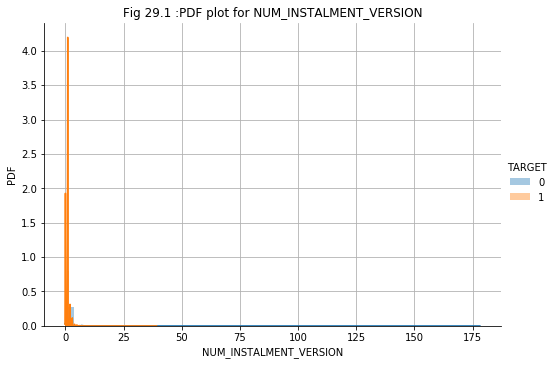

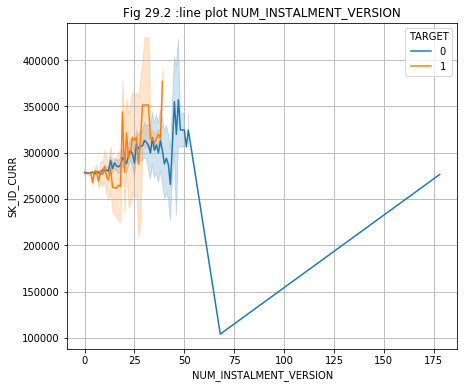



 Few statistical Informaion:


count    1.159159e+07
mean     8.509618e-01
std      1.002910e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.780000e+02
Name: NUM_INSTALMENT_VERSION, dtype: float64


In [101]:
#plotting density plot
sns.FacetGrid(data=installments_payments_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'NUM_INSTALMENT_VERSION').add_legend()
plt.title('Fig 29.1 :PDF plot for NUM_INSTALMENT_VERSION')
plt.xlabel('NUM_INSTALMENT_VERSION')
plt.ylabel('PDF')
plt.grid()
plt.show()
plt.figure(figsize=(7,6))
sns.lineplot(y=installments_payments_join_app.SK_ID_CURR,\
             x=installments_payments_join_app.NUM_INSTALMENT_VERSION,sort=True,hue=installments_payments_join_app.TARGET)
plt.title('Fig 29.2 :line plot NUM_INSTALMENT_VERSION')
plt.xlabel('NUM_INSTALMENT_VERSION')
plt.ylabel('SK_ID_CURR')
plt.grid()
plt.show()
print("\n\n Few statistical Informaion:\n\n")
print(installments_payments_join_app.NUM_INSTALMENT_VERSION.describe())

<h3><u>From fig 29: Observation:</u></h3><br>
we have a range of 0 to 178 NUM_INSTALMENT_VERSION available in the sample

## 10.5.2 EDA - NUM_INSTALMENT_NUMBER: On which installment we observe payment

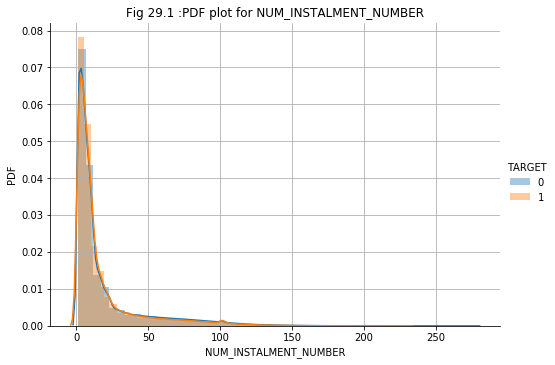

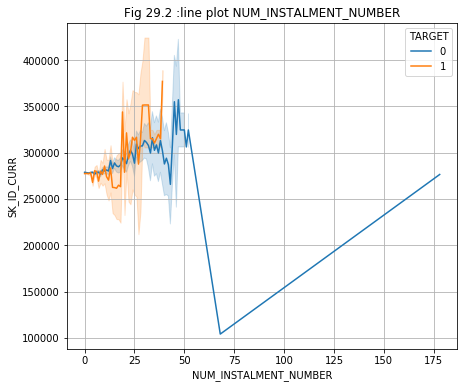



 Few statistical Informaion:


count    1.159159e+07
mean     1.873027e+01
std      2.649067e+01
min      1.000000e+00
25%      4.000000e+00
50%      8.000000e+00
75%      1.900000e+01
max      2.770000e+02
Name: NUM_INSTALMENT_NUMBER, dtype: float64


In [102]:
#plotting density plot
sns.FacetGrid(data=installments_payments_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'NUM_INSTALMENT_NUMBER').add_legend()
plt.title('Fig 30.1 :PDF plot for NUM_INSTALMENT_NUMBER')
plt.xlabel('NUM_INSTALMENT_NUMBER')
plt.ylabel('PDF')
plt.grid()
plt.show()
plt.figure(figsize=(7,6))
sns.lineplot(y=installments_payments_join_app.SK_ID_CURR,\
             x=installments_payments_join_app.NUM_INSTALMENT_VERSION,sort=True,hue=installments_payments_join_app.TARGET)
plt.title('Fig 30.2 :line plot NUM_INSTALMENT_NUMBER')
plt.xlabel('NUM_INSTALMENT_NUMBER')
plt.ylabel('SK_ID_CURR')
plt.grid()
plt.show()
print("\n\n Few statistical Informaion:\n\n")
print(installments_payments_join_app.NUM_INSTALMENT_NUMBER.describe())

<h3><u>From fig 30: Observation:</u></h3><br>
we have a range of 0 to 277 installment no available in the sample

## 10.5.3 EDA - DAYS_INSTALMENT: When the installment of previous credit was supposed to be paid (relative to application date of current loan)

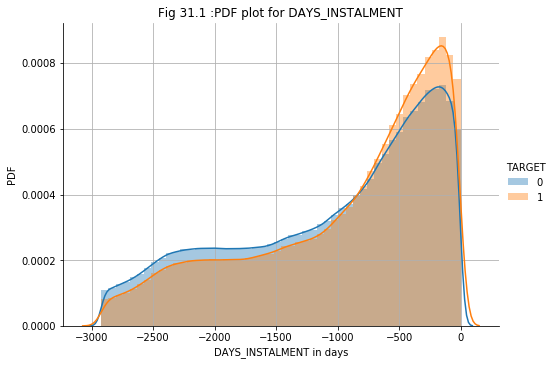



 Few statistical Informaion:


count    1.159159e+07
mean    -1.041082e+03
std      7.994779e+02
min     -2.922000e+03
25%     -1.654000e+03
50%     -8.200000e+02
75%     -3.590000e+02
max     -1.000000e+00
Name: DAYS_INSTALMENT, dtype: float64


In [103]:
#plotting density plot
sns.FacetGrid(data=installments_payments_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'DAYS_INSTALMENT').add_legend()
plt.title('Fig 31.1 :PDF plot for DAYS_INSTALMENT')
plt.xlabel('DAYS_INSTALMENT in days')
plt.ylabel('PDF')
plt.grid()
plt.show()
print("\n\n Few statistical Informaion:\n\n")
print(installments_payments_join_app.DAYS_INSTALMENT.describe())

<h3><u>From fig 31.1: Observation:</u></h3><br>
we have a range of 0 to -2922 days info available in the sample

## 10.5.4 EDA - DAYS_ENTRY_PAYMENT: When was the installments of previous credit paid actually (relative to application date of current loan)

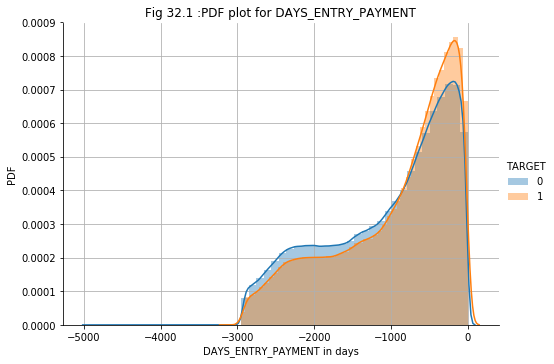



 Few statistical Informaion:


count    1.158901e+07
mean    -1.049898e+03
std      7.990790e+02
min     -4.921000e+03
25%     -1.663000e+03
50%     -8.290000e+02
75%     -3.680000e+02
max     -1.000000e+00
Name: DAYS_ENTRY_PAYMENT, dtype: float64


In [104]:
#plotting density plot
sns.FacetGrid(data=installments_payments_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'DAYS_ENTRY_PAYMENT').add_legend()
plt.title('Fig 32.1 :PDF plot for DAYS_ENTRY_PAYMENT')
plt.xlabel('DAYS_ENTRY_PAYMENT in days')
plt.ylabel('PDF')
plt.grid()
plt.show()
print("\n\n Few statistical Informaion:\n\n")
print(installments_payments_join_app.DAYS_ENTRY_PAYMENT.describe())

<h3><u>From fig 32.1: Observation:</u></h3><br>
we have a range of 0 to -4921 days information available in the sample.-4921 seems to be an outlier.

## 10.5.5 EDA - AMT_INSTALMENT: What was the prescribed installment amount of previous credit on this installment

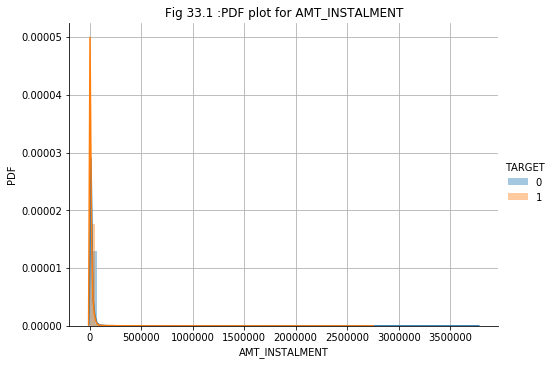



 Few statistical Informaion:


count    1.159159e+07
mean     1.691790e+04
std      5.033127e+04
min      0.000000e+00
25%      4.203675e+03
50%      8.787645e+03
75%      1.655559e+04
max      3.771488e+06
Name: AMT_INSTALMENT, dtype: float64


In [106]:
#plotting density plot
sns.FacetGrid(data=installments_payments_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'AMT_INSTALMENT').add_legend()
plt.title('Fig 33.1 :PDF plot for AMT_INSTALMENT')
plt.xlabel('AMT_INSTALMENT')
plt.ylabel('PDF')
plt.grid()
plt.show()
print("\n\n Few statistical Informaion:\n\n")
print(installments_payments_join_app.AMT_INSTALMENT.describe())

<h3><u>From fig 33.1: Observation:</u></h3><br>
The distribution is heavily right skewed.
we have a range of 0 to 3.771488e+06 values.

## 10.5.6 EDA - AMT_PAYMENT: What the client actually paid on previous credit on this installment

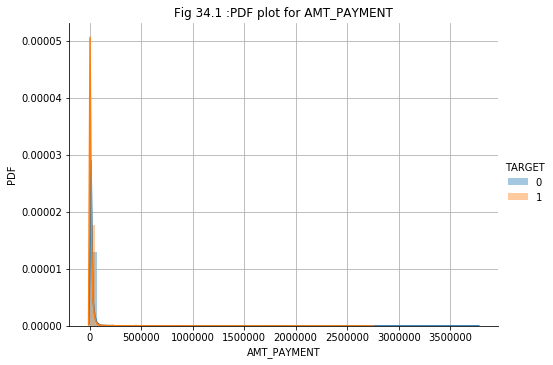



 Few statistical Informaion:


count    1.158901e+07
mean     1.707693e+04
std      5.445628e+04
min      0.000000e+00
25%      3.378375e+03
50%      8.095410e+03
75%      1.593193e+04
max      3.771488e+06
Name: AMT_PAYMENT, dtype: float64


In [107]:
#plotting density plot
sns.FacetGrid(data=installments_payments_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'AMT_PAYMENT').add_legend()
plt.title('Fig 34.1 :PDF plot for AMT_PAYMENT')
plt.xlabel('AMT_PAYMENT')
plt.ylabel('PDF')
plt.grid()
plt.show()
print("\n\n Few statistical Informaion:\n\n")
print(installments_payments_join_app.AMT_PAYMENT.describe())

<h3><u>From fig 34.1: Observation:</u></h3><br>
The distribution is heavily right skewed. and we have a range of 0 to 3.771488e+06 values available in the sample

# 11. POS_CASH_balance data analysis

## 11.1 Shape of the POS_CASH_balance Datasets

In [108]:
print("Shape of POS_CASH_balance: ",POS_CASH_balance.shape)

Shape of POS_CASH_balance:  (10001358, 8)


<h3><u>Observation:</u></h3><br>
There are total 8 features and 10 million rows in this dataset

## 11.2 snapshot of POS_CASH_balance data

In [109]:
POS_CASH_balance.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0  
3                   42.0               Active       0           0  
4                   35.0               Active       0           0

## 11.3 name of all the features

In [110]:
POS_CASH_balance.columns.values

array(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'CNT_INSTALMENT',
       'CNT_INSTALMENT_FUTURE', 'NAME_CONTRACT_STATUS', 'SK_DPD',
       'SK_DPD_DEF'], dtype=object)

In [111]:
print("Unique values in POS_CASH_balance data SK_ID_CURR: ",len(POS_CASH_balance["SK_ID_CURR"].unique()))
print("Unique values in POS_CASH_balance data SK_ID_PREV: ",len(POS_CASH_balance["SK_ID_PREV"].unique()))

Unique values in POS_CASH_balance data SK_ID_CURR:  337252
Unique values in POS_CASH_balance data SK_ID_PREV:  936325


<h3><u>Observation:</u></h3><br>
We Have 8 features.<br>
We have several rows for each 'SK_ID_CURR' and there is .33 million unique SK_ID_CURR in the dataset.
We have several rows for each 'SK_ID_PREV' and there is .93 million unique SK_ID_CURR in the dataset.

## 11.3.1 Joining with application_train

In [112]:
#Joining with application train on 'SK_ID_CURR to get the 'TARGET' label
POS_CASH_balance_join_app=application_train[['SK_ID_CURR','TARGET']].\
merge(POS_CASH_balance,on = 'SK_ID_CURR', how = 'left')

print("After Joining bureau to application data on SK_ID_BUREAU new columns of the joined data: ",\
      POS_CASH_balance_join_app.columns.values)

After Joining bureau to application data on SK_ID_BUREAU new columns of the joined data:  ['SK_ID_CURR' 'TARGET' 'SK_ID_PREV' 'MONTHS_BALANCE' 'CNT_INSTALMENT'
 'CNT_INSTALMENT_FUTURE' 'NAME_CONTRACT_STATUS' 'SK_DPD' 'SK_DPD_DEF']


In [113]:
#after joining with application train
POS_CASH_balance_join_app.shape

(8561442, 9)

## 10.4 Missing value Statistics on the 9 features present in the joined data

In [114]:
#checking the information about application train features
miss_value(POS_CASH_balance_join_app)

dtype  Unique values  Number of missing values  \
CNT_INSTALMENT_FUTURE  float64             78                     39945   
CNT_INSTALMENT         float64             72                     39930   
SK_ID_PREV             float64         800337                     18067   
MONTHS_BALANCE         float64             96                     18067   
NAME_CONTRACT_STATUS    object              9                     18067   
SK_DPD                 float64           3358                     18067   
SK_DPD_DEF             float64           1987                     18067   
SK_ID_CURR               int64         307511                         0   
TARGET                   int64              2                         0   

                       Percentage missing  
CNT_INSTALMENT_FUTURE            0.466569  
CNT_INSTALMENT                   0.466393  
SK_ID_PREV                       0.211028  
MONTHS_BALANCE                   0.211028  
NAME_CONTRACT_STATUS             0.211028  
SK_DPD                           0.211028  
SK_DPD_DEF                       0.211028  
SK_ID_CURR                       0.000000  
TARGET                           0.000000

<h3><u>Observation:</u></h3><br>
Most of the data is present



## 11.5 EDA of numerical features

In [115]:
# Name of all the numerical features
POS_CASH_balance_join_app.select_dtypes(exclude='object').columns.values

array(['SK_ID_CURR', 'TARGET', 'SK_ID_PREV', 'MONTHS_BALANCE',
       'CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE', 'SK_DPD', 'SK_DPD_DEF'],
      dtype=object)

## 11.5.1 EDA - CNT_INSTALMENT_FUTURE: Installments left to pay on the previous credit

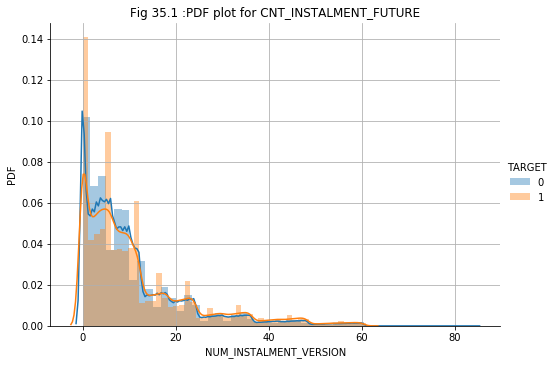



 Few statistical Informaion:


count    8.521497e+06
mean     1.046808e+01
std      1.114408e+01
min      0.000000e+00
25%      3.000000e+00
50%      7.000000e+00
75%      1.400000e+01
max      8.400000e+01
Name: CNT_INSTALMENT_FUTURE, dtype: float64


<Figure size 504x432 with 0 Axes>

In [119]:
#plotting density plot
sns.FacetGrid(data=POS_CASH_balance_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'CNT_INSTALMENT_FUTURE').add_legend()
plt.title('Fig 35.1 :PDF plot for CNT_INSTALMENT_FUTURE')
plt.xlabel('CNT_INSTALMENT_FUTURE')
plt.ylabel('PDF')
plt.grid()
plt.show()
plt.figure(figsize=(7,6))
print("\n\n Few statistical Informaion:\n\n")
print(POS_CASH_balance_join_app.CNT_INSTALMENT_FUTURE.describe())

<h3><u>From fig 35: Observation:</u></h3><br>
We have range of values from 0 to 84.max 84 installment is pending. 

## 11.5.2 EDA - CNT_INSTALMENT: Term of previous credit (can change over time)

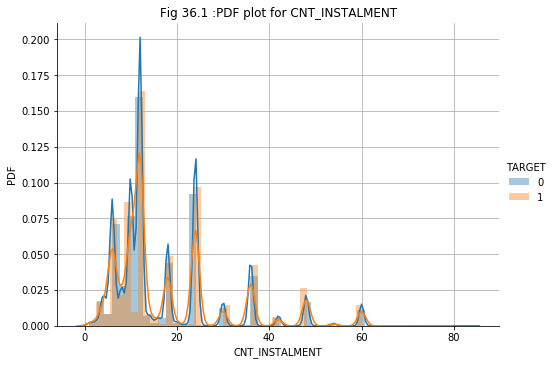



 Few statistical Informaion:


count    8.521512e+06
mean     1.703348e+01
std      1.200430e+01
min      1.000000e+00
25%      1.000000e+01
50%      1.200000e+01
75%      2.400000e+01
max      8.400000e+01
Name: CNT_INSTALMENT, dtype: float64


In [118]:
#plotting density plot
sns.FacetGrid(data=POS_CASH_balance_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'CNT_INSTALMENT').add_legend()
plt.title('Fig 36.1 :PDF plot for CNT_INSTALMENT')
plt.xlabel('CNT_INSTALMENT')
plt.ylabel('PDF')
plt.grid()
plt.show()
print("\n\n Few statistical Informaion:\n\n")
print(POS_CASH_balance_join_app.CNT_INSTALMENT.describe())

<h3><u>From fig 36: Observation:</u></h3><br>
We have range of values from 1 to 84 installment present in the sample. 

## 11.5.3 EDA - SK_DPD: DPD (days past due) during the month of previous credit

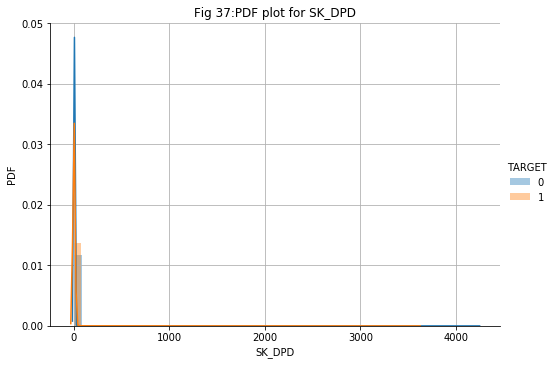



 Few statistical Informaion:


count    8.543375e+06
mean     1.190473e+01
std      1.340302e+02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.231000e+03
Name: SK_DPD, dtype: float64


In [120]:
#plotting density plot
sns.FacetGrid(data=POS_CASH_balance_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'SK_DPD').add_legend()
plt.title('Fig 37:PDF plot for SK_DPD')
plt.xlabel('SK_DPD')
plt.ylabel('PDF')
plt.grid()
plt.show()
print("\n\n Few statistical Informaion:\n\n")
print(POS_CASH_balance_join_app.SK_DPD.describe())

<h3><u>From fig 37: Observation:</u></h3><br>
The distribution is highly right skewed as most clients have 0 dpd, few clients have high DPD.<br>
We have range of values from 0 to 4231

## 11.5.4 EDA - SK_DPD_DEF: DPD during the month with tolerance (debts with low loan amounts are ignored) of the previous credit

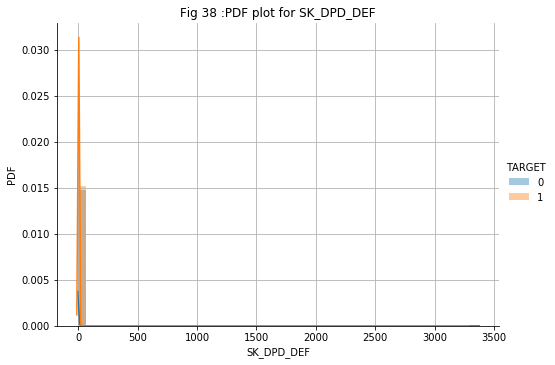



 Few statistical Informaion:


count    8.543375e+06
mean     5.835209e-01
std      3.042110e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.373000e+03
Name: SK_DPD_DEF, dtype: float64


In [122]:
#plotting density plot
sns.FacetGrid(data=POS_CASH_balance_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'SK_DPD_DEF').add_legend()
plt.title('Fig 38 :PDF plot for SK_DPD_DEF')
plt.xlabel('SK_DPD_DEF')
plt.ylabel('PDF')
plt.grid()
plt.show()
print("\n\n Few statistical Informaion:\n\n")
print(POS_CASH_balance_join_app.SK_DPD_DEF.describe())

<h3><u>From fig 38: Observation:</u></h3><br>
The distribution is highly right skewed as most clients have 0 ignored dpd, few clients have high ignored DPD.<br>
We have range of values from 0 to 3373 DPD ignored/waved off.

## 11.5.5 EDA - MONTHS_BALANCE: Month of balance relative to application date (-1 means the information to the freshest monthly snapshot, 0 means the information at application - often it will be the same as -1 as many banks are not updating the information to Credit Bureau regularly )

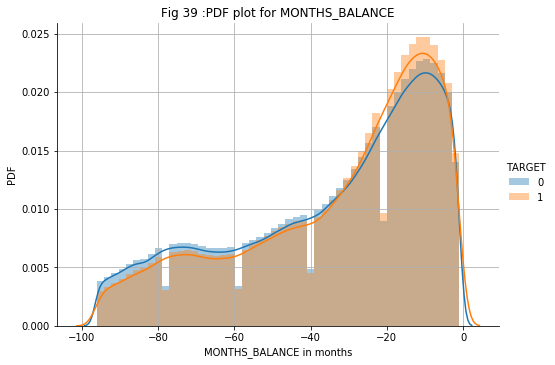



 Few statistical Informaion:


count    8.543375e+06
mean    -3.494812e+01
std      2.605372e+01
min     -9.600000e+01
25%     -5.400000e+01
50%     -2.800000e+01
75%     -1.300000e+01
max     -1.000000e+00
Name: MONTHS_BALANCE, dtype: float64


In [123]:
#plotting density plot
sns.FacetGrid(data=POS_CASH_balance_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'MONTHS_BALANCE').add_legend()
plt.title('Fig 39 :PDF plot for MONTHS_BALANCE')
plt.xlabel('MONTHS_BALANCE in months')
plt.ylabel('PDF')
plt.grid()
plt.show()
print("\n\n Few statistical Informaion:\n\n")
print(POS_CASH_balance_join_app.MONTHS_BALANCE.describe())

<h3><u>From fig 39: Observation:</u></h3><br>
We have range of values from 0 to -96 months of historical data present.

## 11.6 EDA of categorical features

In [124]:
# Name of all the categorical features
POS_CASH_balance_join_app.select_dtypes('object').columns.values

array(['NAME_CONTRACT_STATUS'], dtype=object)

Unique values present in NAME_CONTRACT_STATUS : {nan, 'Canceled', 'Active', 'Completed', 'Amortized debt', 'Demand', 'Returned to the store', 'XNA', 'Approved', 'Signed'} 
No of unique values: 10


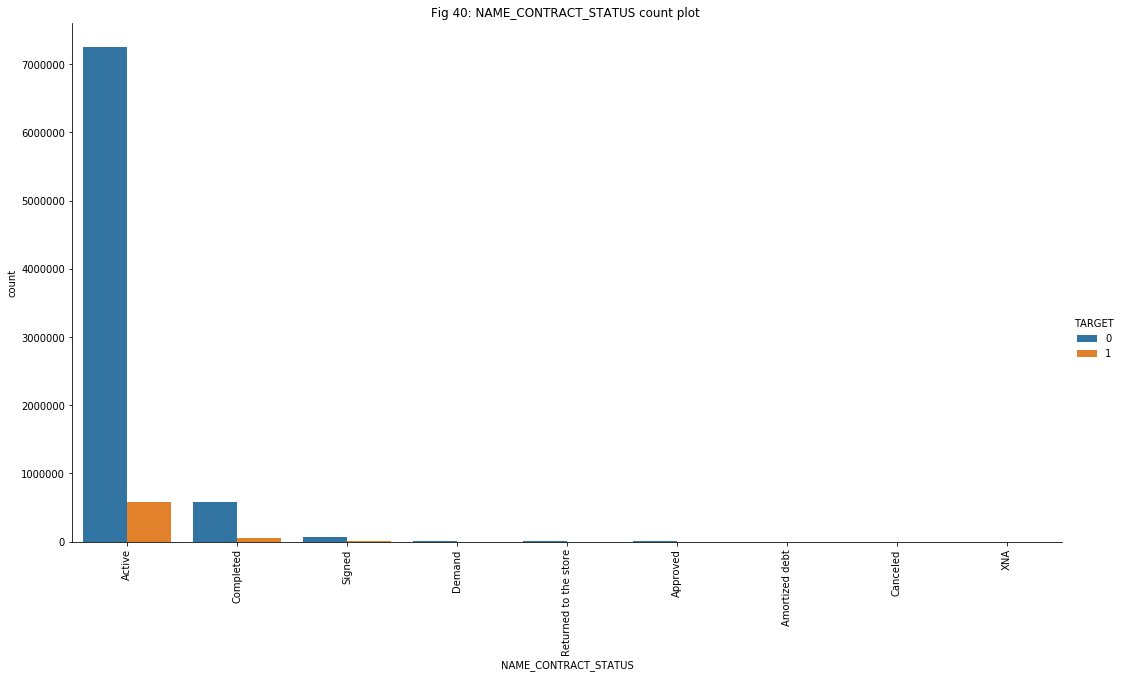

Counts of top 5 values of label 1:


Count of each category  \
NAME_CONTRACT_STATUS                            
Active                              91.326883   
Completed                            7.469463   
Signed                               0.928592   
Demand                               0.129020   
Returned to the store                0.075089   

                       Percentage of count of each category  
NAME_CONTRACT_STATUS                                         
Active                                               574068  
Completed                                             46952  
Signed                                                 5837  
Demand                                                  811  
Returned to the store                                   472

Counts of  top 5 values of label 0:


Count of each category  \
NAME_CONTRACT_STATUS                            
Active                              91.531297   
Completed                            7.428120   
Signed                               0.869107   
Demand                               0.066951   
Returned to the store                0.052042   

                       Percentage of count of each category  
NAME_CONTRACT_STATUS                                         
Active                                              7244509  
Completed                                            587920  
Signed                                                68788  
Demand                                                 5299  
Returned to the store                                  4119

In [125]:
print("Unique values present in {} : {} ".format('NAME_CONTRACT_STATUS', set(POS_CASH_balance_join_app\
                                                                          ['NAME_CONTRACT_STATUS'].values)))
print("No of unique values: {}".format(len(set(POS_CASH_balance_join_app['NAME_CONTRACT_STATUS'].values))))
#plotting countplot in sorted manner for each unique value in the categorical feature
sns.catplot(x='NAME_CONTRACT_STATUS', kind="count",hue='TARGET', data=POS_CASH_balance_join_app,height=8, \
            aspect=15/8,order=POS_CASH_balance_join_app['NAME_CONTRACT_STATUS'].value_counts().index).\
set_xticklabels(rotation=90)
plt.title('Fig 40: {} count plot '.format('NAME_CONTRACT_STATUS'))
plt.show()

counts_1_percent,counts_0_percent=agg_count_details(POS_CASH_balance_join_app,'NAME_CONTRACT_STATUS')

#printing the top 5 values for both labels
print("Counts of top 5 values of label 1:")
display(counts_1_percent.head(5))
print("Counts of  top 5 values of label 0:")
display(counts_0_percent.head(5))

<h3><u>From fig 40: Observation:</u></h3><br>
There are 9 unique categori present in this featureexcept nan values: 'Canceled', 'Active', 'Completed', 'Amortized debt', 'Demand', 'Returned to the store', 'XNA', 'Approved', 'Signed'. For both labels the data is well distributed.

# 12. credit_card_balance data analysis

## 12.1 Shape of the credit_card_balance Datasets

In [126]:
print("Shape of credit_card_balance: ",credit_card_balance.shape)

Shape of credit_card_balance:  (3840312, 23)


<h3><u>Observation:</u></h3><br>
There are total 23 features and 3.84 million rows in this dataset

## 12.2 snapshot of credit_card_balance data

In [127]:
credit_card_balance.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   
2     1740877      371185              -7    31815.225   
3     1389973      337855              -4   236572.110   
4     1891521      126868              -1   453919.455   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   
3                   225000                    2250.0                2250.0   
4                   450000                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                   11547.0   

   AMT_INST_MIN_REGULARITY     ...      AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                 1700.325     ...              0.000                 0.000   
1                 2250.000     ...          64875.555             64875.555   
2                 2250.000     ...          31460.085             31460.085   
3                11795.760     ...         233048.970            233048.970   
4                22924.890     ...         453919.455            453919.455   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1                         0.0   
2                       0.0                     0                         0.0   
3                       1.0                     1                         0.0   
4                       0.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM  NAME_CONTRACT_STATUS  \
0                       1.0                       35.0                Active   
1                       0.0                       69.0                Active   
2                       0.0                       30.0                Active   
3                       0.0                       10.0                Active   
4                       1.0                      101.0                Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0  

[5 rows x 23 columns]

## 12.3 name of all the features

In [128]:
credit_card_balance.columns.values

array(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE',
       'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT',
       'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
       'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY',
       'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
       'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE',
       'AMT_TOTAL_RECEIVABLE', 'CNT_DRAWINGS_ATM_CURRENT',
       'CNT_DRAWINGS_CURRENT', 'CNT_DRAWINGS_OTHER_CURRENT',
       'CNT_DRAWINGS_POS_CURRENT', 'CNT_INSTALMENT_MATURE_CUM',
       'NAME_CONTRACT_STATUS', 'SK_DPD', 'SK_DPD_DEF'], dtype=object)

In [129]:
print("Unique values in credit_card_balance data SK_ID_CURR: ",len(credit_card_balance["SK_ID_CURR"].unique()))
print("Unique values in credit_card_balance data SK_ID_PREV: ",len(credit_card_balance["SK_ID_PREV"].unique()))

Unique values in credit_card_balance data SK_ID_CURR:  103558
Unique values in credit_card_balance data SK_ID_PREV:  104307


<h3><u>Observation:</u></h3><br>
We Have 23 features.<br>
We have several rows for each 'SK_ID_CURR' and there is .1 million unique SK_ID_CURR in the dataset.
We have several rows for each 'SK_ID_PREV' and there is .1 million unique SK_ID_CURR in the dataset.

## 12.3.1 Joining with application_train

In [130]:
#Joining with application train on 'SK_ID_CURR to get the 'TARGET' label
credit_card_balance_join_app=application_train[['SK_ID_CURR','TARGET']].\
merge(credit_card_balance,on = 'SK_ID_CURR', how = 'left')

print("After Joining bureau to application data on SK_ID_BUREAU new columns of the joined data: ",\
      credit_card_balance_join_app.columns.values)

After Joining bureau to application data on SK_ID_BUREAU new columns of the joined data:  ['SK_ID_CURR' 'TARGET' 'SK_ID_PREV' 'MONTHS_BALANCE' 'AMT_BALANCE'
 'AMT_CREDIT_LIMIT_ACTUAL' 'AMT_DRAWINGS_ATM_CURRENT'
 'AMT_DRAWINGS_CURRENT' 'AMT_DRAWINGS_OTHER_CURRENT'
 'AMT_DRAWINGS_POS_CURRENT' 'AMT_INST_MIN_REGULARITY'
 'AMT_PAYMENT_CURRENT' 'AMT_PAYMENT_TOTAL_CURRENT'
 'AMT_RECEIVABLE_PRINCIPAL' 'AMT_RECIVABLE' 'AMT_TOTAL_RECEIVABLE'
 'CNT_DRAWINGS_ATM_CURRENT' 'CNT_DRAWINGS_CURRENT'
 'CNT_DRAWINGS_OTHER_CURRENT' 'CNT_DRAWINGS_POS_CURRENT'
 'CNT_INSTALMENT_MATURE_CUM' 'NAME_CONTRACT_STATUS' 'SK_DPD' 'SK_DPD_DEF']


In [131]:
#after joining with application train
credit_card_balance_join_app.shape

(3448571, 24)

## 12.4 Missing value Statistics on the 9 features present in the joined data

In [132]:
#checking the information about application train features
miss_value(credit_card_balance_join_app)

dtype  Unique values  Number of missing values  \
AMT_PAYMENT_CURRENT         float64         142261                    840699   
CNT_DRAWINGS_POS_CURRENT    float64            132                    826360   
AMT_DRAWINGS_ATM_CURRENT    float64           2095                    826360   
CNT_DRAWINGS_OTHER_CURRENT  float64             11                    826360   
AMT_DRAWINGS_OTHER_CURRENT  float64           1650                    826360   
AMT_DRAWINGS_POS_CURRENT    float64         143768                    826360   
CNT_DRAWINGS_ATM_CURRENT    float64             44                    826360   
CNT_INSTALMENT_MATURE_CUM   float64            121                    484990   
AMT_INST_MIN_REGULARITY     float64         278880                    484990   
AMT_PAYMENT_TOTAL_CURRENT   float64         156928                    220606   
AMT_TOTAL_RECEIVABLE        float64        1174308                    220606   
SK_DPD                      float64            844                    220606   
NAME_CONTRACT_STATUS         object              7                    220606   
CNT_DRAWINGS_CURRENT        float64            127                    220606   
SK_DPD_DEF                  float64            308                    220606   
AMT_RECIVABLE               float64        1174197                    220606   
AMT_RECEIVABLE_PRINCIPAL    float64        1045438                    220606   
AMT_DRAWINGS_CURRENT        float64         159227                    220606   
AMT_CREDIT_LIMIT_ACTUAL     float64            167                    220606   
AMT_BALANCE                 float64        1182278                    220606   
MONTHS_BALANCE              float64             96                    220606   
SK_ID_PREV                  float64          87452                    220606   
TARGET                        int64              2                         0   
SK_ID_CURR                    int64         307511                         0   

                            Percentage missing  
AMT_PAYMENT_CURRENT                  24.378184  
CNT_DRAWINGS_POS_CURRENT             23.962389  
AMT_DRAWINGS_ATM_CURRENT             23.962389  
CNT_DRAWINGS_OTHER_CURRENT           23.962389  
AMT_DRAWINGS_OTHER_CURRENT           23.962389  
AMT_DRAWINGS_POS_CURRENT             23.962389  
CNT_DRAWINGS_ATM_CURRENT             23.962389  
CNT_INSTALMENT_MATURE_CUM            14.063506  
AMT_INST_MIN_REGULARITY              14.063506  
AMT_PAYMENT_TOTAL_CURRENT             6.397026  
AMT_TOTAL_RECEIVABLE                  6.397026  
SK_DPD                                6.397026  
NAME_CONTRACT_STATUS                  6.397026  
CNT_DRAWINGS_CURRENT                  6.397026  
SK_DPD_DEF                            6.397026  
AMT_RECIVABLE                         6.397026  
AMT_RECEIVABLE_PRINCIPAL              6.397026  
AMT_DRAWINGS_CURRENT                  6.397026  
AMT_CREDIT_LIMIT_ACTUAL               6.397026  
AMT_BALANCE                           6.397026  
MONTHS_BALANCE                        6.397026  
SK_ID_PREV                            6.397026  
TARGET                                0.000000  
SK_ID_CURR                            0.000000

<h3><u>Observation:</u></h3><br>
Most of the data is present, except few features from the top 7 missing more than 23% data



## 12.5 EDA of numerical features

In [133]:
# Name of all the numerical features
credit_card_balance_join_app.select_dtypes(exclude='object').columns.values

array(['SK_ID_CURR', 'TARGET', 'SK_ID_PREV', 'MONTHS_BALANCE',
       'AMT_BALANCE', 'AMT_CREDIT_LIMIT_ACTUAL',
       'AMT_DRAWINGS_ATM_CURRENT', 'AMT_DRAWINGS_CURRENT',
       'AMT_DRAWINGS_OTHER_CURRENT', 'AMT_DRAWINGS_POS_CURRENT',
       'AMT_INST_MIN_REGULARITY', 'AMT_PAYMENT_CURRENT',
       'AMT_PAYMENT_TOTAL_CURRENT', 'AMT_RECEIVABLE_PRINCIPAL',
       'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE',
       'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT',
       'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT',
       'CNT_INSTALMENT_MATURE_CUM', 'SK_DPD', 'SK_DPD_DEF'], dtype=object)

## 12.5.1 EDA - MONTHS_BALANCE: Month of balance relative to application date (-1 means the freshest balance date)

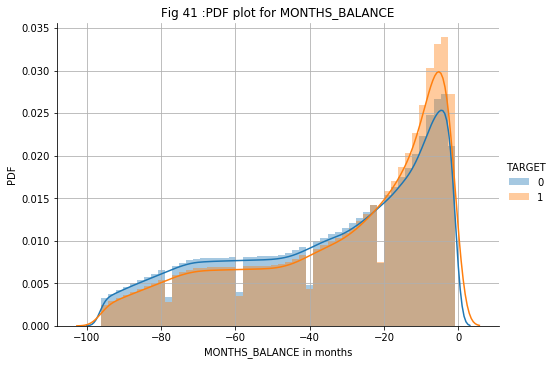



 Few statistical Informaion:


count    3.227965e+06
mean    -3.471544e+01
std      2.663609e+01
min     -9.600000e+01
25%     -5.600000e+01
50%     -2.800000e+01
75%     -1.100000e+01
max     -1.000000e+00
Name: MONTHS_BALANCE, dtype: float64


<Figure size 504x432 with 0 Axes>

In [134]:
#plotting density plot
sns.FacetGrid(data=credit_card_balance_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'MONTHS_BALANCE').add_legend()
plt.title('Fig 41 :PDF plot for MONTHS_BALANCE')
plt.xlabel('MONTHS_BALANCE in months')
plt.ylabel('PDF')
plt.grid()
plt.show()
plt.figure(figsize=(7,6))
print("\n\n Few statistical Informaion:\n\n")
print(credit_card_balance_join_app.MONTHS_BALANCE.describe())

<h3><u>From fig 41: Observation:</u></h3><br>
We have range of values from 0 to -96 months of historical data present in the sample.

## 12.5.2 EDA -AMT_BALANCE: Balance during the month of previous credit

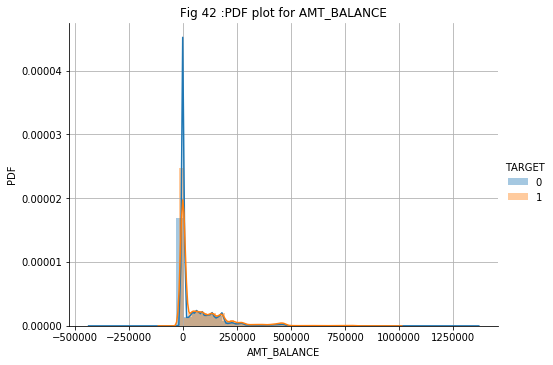



 Few statistical Informaion:


count    3.227965e+06
mean     5.907332e+04
std      1.066137e+05
min     -4.202502e+05
25%      0.000000e+00
50%      0.000000e+00
75%      9.040554e+04
max      1.354829e+06
Name: AMT_BALANCE, dtype: float64


<Figure size 504x432 with 0 Axes>

In [135]:
#plotting density plot
sns.FacetGrid(data=credit_card_balance_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'AMT_BALANCE').add_legend()
plt.title('Fig 42 :PDF plot for AMT_BALANCE')
plt.xlabel('AMT_BALANCE')
plt.ylabel('PDF')
plt.grid()
plt.show()
plt.figure(figsize=(7,6))
print("\n\n Few statistical Informaion:\n\n")
print(credit_card_balance_join_app.AMT_BALANCE.describe())

<h3><u>From fig 42: Observation:</u></h3><br>
The distribution is highly densed at 0
We have range of values from -420250 to 1.36e+06 present in the sample.both positive and negetive balance is present.

## 12.5.3 EDA - AMT_CREDIT_LIMIT_ACTUAL: Credit card limit during the month of the previous credit

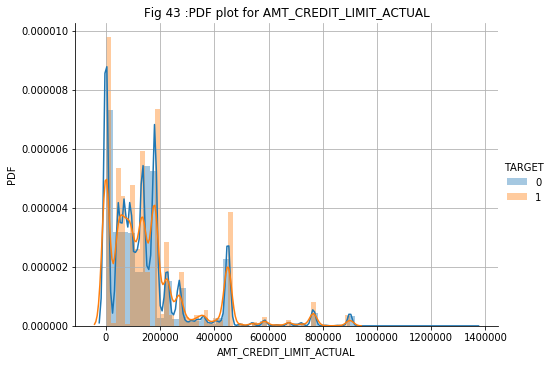



 Few statistical Informaion:


count    3.227965e+06
mean     1.529536e+05
std      1.637092e+05
min      0.000000e+00
25%      4.500000e+04
50%      1.125000e+05
75%      1.800000e+05
max      1.350000e+06
Name: AMT_CREDIT_LIMIT_ACTUAL, dtype: float64


<Figure size 504x432 with 0 Axes>

In [137]:
#plotting density plot
sns.FacetGrid(data=credit_card_balance_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'AMT_CREDIT_LIMIT_ACTUAL').add_legend()
plt.title('Fig 43 :PDF plot for AMT_CREDIT_LIMIT_ACTUAL')
plt.xlabel('AMT_CREDIT_LIMIT_ACTUAL')
plt.ylabel('PDF')
plt.grid()
plt.show()
plt.figure(figsize=(7,6))
print("\n\n Few statistical Informaion:\n\n")
print(credit_card_balance_join_app.AMT_CREDIT_LIMIT_ACTUAL.describe())

<h3><u>From fig 43: Observation:</u></h3><br>
We have range of values from 0 to 1.350000e+06 data present in the sample.

## 12.5.4 EDA - AMT_DRAWINGS_ATM_CURRENT: Amount drawing at ATM during the month of the previous credit

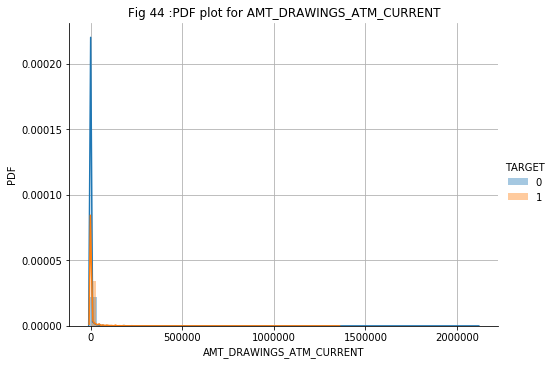



 Few statistical Informaion:


count    2.622211e+06
mean     6.024272e+03
std      2.842116e+04
min     -6.827310e+03
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.115000e+06
Name: AMT_DRAWINGS_ATM_CURRENT, dtype: float64


<Figure size 504x432 with 0 Axes>

In [138]:
#plotting density plot
sns.FacetGrid(data=credit_card_balance_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'AMT_DRAWINGS_ATM_CURRENT').add_legend()
plt.title('Fig 44 :PDF plot for AMT_DRAWINGS_ATM_CURRENT')
plt.xlabel('AMT_DRAWINGS_ATM_CURRENT')
plt.ylabel('PDF')
plt.grid()
plt.show()
plt.figure(figsize=(7,6))
print("\n\n Few statistical Informaion:\n\n")
print(credit_card_balance_join_app.AMT_DRAWINGS_ATM_CURRENT.describe())

<h3><u>From fig 44: Observation:</u></h3><br>
The distribution is heavily right skewed.as not all client do the atm transaction all the months<br>
We have range of values from 0 to 2.115000e+06 present in the sample.

## 12.5.5 EDA - AMT_DRAWINGS_CURRENT: Amount drawing during the month of the previous credit

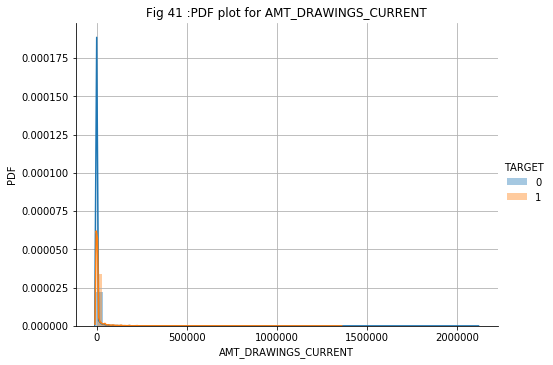



 Few statistical Informaion:


count    3.227965e+06
mean     7.494084e+03
std      3.396743e+04
min     -6.211620e+03
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.115000e+06
Name: AMT_DRAWINGS_CURRENT, dtype: float64


<Figure size 504x432 with 0 Axes>

In [139]:
#plotting density plot
sns.FacetGrid(data=credit_card_balance_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'AMT_DRAWINGS_CURRENT').add_legend()
plt.title('Fig 45 :PDF plot for AMT_DRAWINGS_CURRENT')
plt.xlabel('AMT_DRAWINGS_CURRENT')
plt.ylabel('PDF')
plt.grid()
plt.show()
plt.figure(figsize=(7,6))
print("\n\n Few statistical Informaion:\n\n")
print(credit_card_balance_join_app.AMT_DRAWINGS_CURRENT.describe())

<h3><u>From fig 45: Observation:</u></h3><br>
The distribution is heavily right skewed.as not all client draw amount all the months<br>
We have range of values from 0 to 2.115000e+06 present in the sample.

## 12.5.6 EDA - AMT_DRAWINGS_OTHER_CURRENT: Amount of other drawings during the month of the previous credit

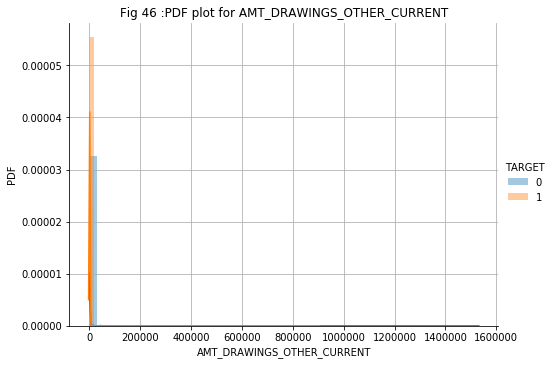



 Few statistical Informaion:


count    2.622211e+06
mean     2.984882e+02
std      8.396193e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.529847e+06
Name: AMT_DRAWINGS_OTHER_CURRENT, dtype: float64


<Figure size 504x432 with 0 Axes>

In [140]:
#plotting density plot
sns.FacetGrid(data=credit_card_balance_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'AMT_DRAWINGS_OTHER_CURRENT').add_legend()
plt.title('Fig 46 :PDF plot for AMT_DRAWINGS_OTHER_CURRENT')
plt.xlabel('AMT_DRAWINGS_OTHER_CURRENT')
plt.ylabel('PDF')
plt.grid()
plt.show()
plt.figure(figsize=(7,6))
print("\n\n Few statistical Informaion:\n\n")
print(credit_card_balance_join_app.AMT_DRAWINGS_OTHER_CURRENT.describe())

<h3><u>From fig 46: Observation:</u></h3><br>
The distribution is heavily right skewed.as not all client draw from other current amount all the months
We have range of values from 0 to 1.529847e+06 present in the sample.

## 12.5.7 EDA - AMT_DRAWINGS_POS_CURRENT: Amount drawing or buying goods during the month of the previous credit

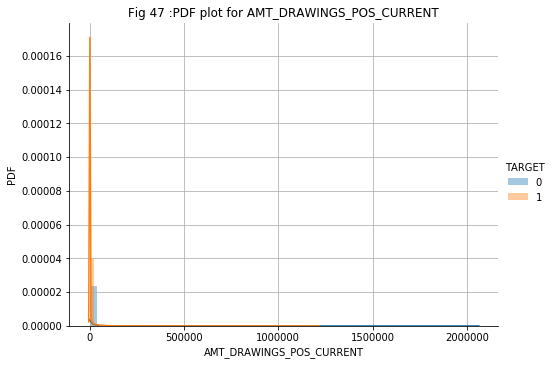



 Few statistical Informaion:


count    2.622211e+06
mean     2.884152e+03
std      2.038833e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.060030e+06
Name: AMT_DRAWINGS_POS_CURRENT, dtype: float64


<Figure size 504x432 with 0 Axes>

In [141]:
#plotting density plot
sns.FacetGrid(data=credit_card_balance_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'AMT_DRAWINGS_POS_CURRENT').add_legend()
plt.title('Fig 47 :PDF plot for AMT_DRAWINGS_POS_CURRENT')
plt.xlabel('AMT_DRAWINGS_POS_CURRENT')
plt.ylabel('PDF')
plt.grid()
plt.show()
plt.figure(figsize=(7,6))
print("\n\n Few statistical Informaion:\n\n")
print(credit_card_balance_join_app.AMT_DRAWINGS_POS_CURRENT.describe())

<h3><u>From fig 47: Observation:</u></h3><br>
The distribution is heavily right skewed.as not all client use pos for all the months
We have range of values from 0 to 2.060030e+06 present in the sample.

## 12.5.8 EDA - AMT_INST_MIN_REGULARITY: Minimal installment for this month of the previous credit

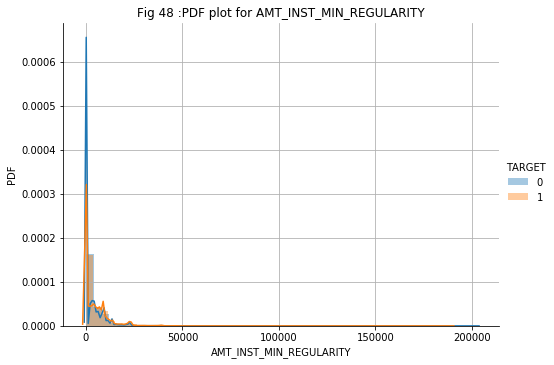



 Few statistical Informaion:


count    2.963581e+06
mean     3.599681e+03
std      5.611742e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      6.750000e+03
max      2.028820e+05
Name: AMT_INST_MIN_REGULARITY, dtype: float64


<Figure size 504x432 with 0 Axes>

In [142]:
#plotting density plot
sns.FacetGrid(data=credit_card_balance_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'AMT_INST_MIN_REGULARITY').add_legend()
plt.title('Fig 48 :PDF plot for AMT_INST_MIN_REGULARITY')
plt.xlabel('AMT_INST_MIN_REGULARITY')
plt.ylabel('PDF')
plt.grid()
plt.show()
plt.figure(figsize=(7,6))
print("\n\n Few statistical Informaion:\n\n")
print(credit_card_balance_join_app.AMT_INST_MIN_REGULARITY.describe())

<h3><u>From fig 48: Observation:</u></h3><br>
The distribution is heavily right skewed.as not all client have minimum credit usage for all the months.<br> We have range of values from 0 to 2.028820e+05 present in the sample.

## 12.5.9 EDA - AMT_PAYMENT_CURRENT: How much did the client pay during the month on the previous credit

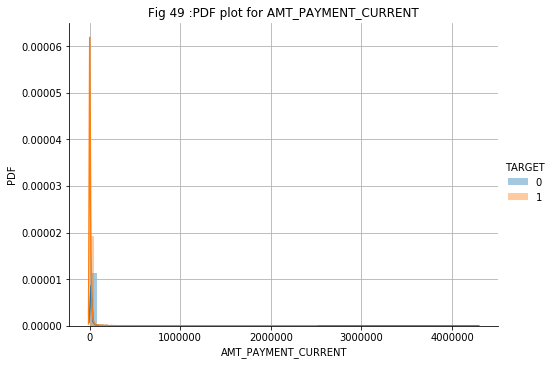



 Few statistical Informaion:


count    2.607872e+06
mean     1.023861e+04
std      3.586433e+04
min      0.000000e+00
25%      1.557000e+02
50%      2.923020e+03
75%      9.000000e+03
max      4.289207e+06
Name: AMT_PAYMENT_CURRENT, dtype: float64


<Figure size 504x432 with 0 Axes>

In [143]:
#plotting density plot
sns.FacetGrid(data=credit_card_balance_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'AMT_PAYMENT_CURRENT').add_legend()
plt.title('Fig 49 :PDF plot for AMT_PAYMENT_CURRENT')
plt.xlabel('AMT_PAYMENT_CURRENT')
plt.ylabel('PDF')
plt.grid()
plt.show()
plt.figure(figsize=(7,6))
print("\n\n Few statistical Informaion:\n\n")
print(credit_card_balance_join_app.AMT_PAYMENT_CURRENT.describe())

<h3><u>From fig 49: Observation:</u></h3><br>
The distribution is heavily right skewed.
We have range of values from 0 to 4.289207e+06 present in the sample.

## 12.5.10 EDA - AMT_PAYMENT_TOTAL_CURRENT: How much did the client pay during the month in total on the previous credit

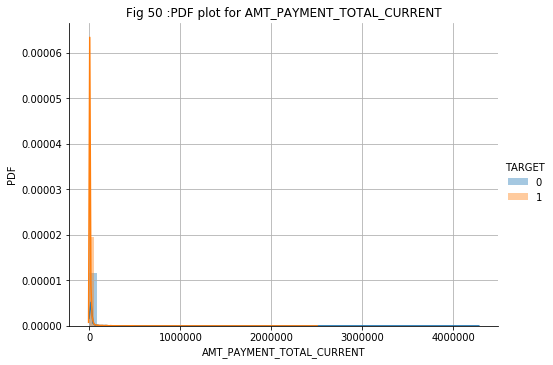



 Few statistical Informaion:


count    3.227965e+06
mean     7.633469e+03
std      3.195403e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      6.750000e+03
max      4.278316e+06
Name: AMT_PAYMENT_TOTAL_CURRENT, dtype: float64


<Figure size 504x432 with 0 Axes>

In [144]:
#plotting density plot
sns.FacetGrid(data=credit_card_balance_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'AMT_PAYMENT_TOTAL_CURRENT').add_legend()
plt.title('Fig 50 :PDF plot for AMT_PAYMENT_TOTAL_CURRENT')
plt.xlabel('AMT_PAYMENT_TOTAL_CURRENT')
plt.ylabel('PDF')
plt.grid()
plt.show()
plt.figure(figsize=(7,6))
print("\n\n Few statistical Informaion:\n\n")
print(credit_card_balance_join_app.AMT_PAYMENT_TOTAL_CURRENT.describe())

<h3><u>From fig 50: Observation:</u></h3><br>
The distribution is heavily right skewed.
We have range of values from 0 to 4.278316e+06 present in the sample.This seems like similar to AMT_PAYMENT_CURRENT

## 12.5.11 EDA - AMT_RECEIVABLE_PRINCIPAL: Amount receivable for principal on the previous credit

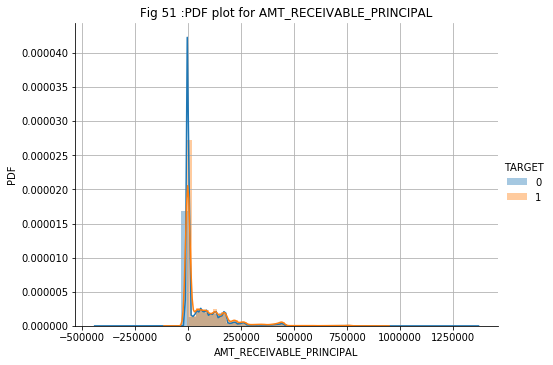



 Few statistical Informaion:


count    3.227965e+06
mean     5.670018e+04
std      1.028242e+05
min     -4.233058e+05
25%      0.000000e+00
50%      0.000000e+00
75%      8.664215e+04
max      1.354829e+06
Name: AMT_RECEIVABLE_PRINCIPAL, dtype: float64


<Figure size 504x432 with 0 Axes>

In [145]:
#plotting density plot
sns.FacetGrid(data=credit_card_balance_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'AMT_RECEIVABLE_PRINCIPAL').add_legend()
plt.title('Fig 51 :PDF plot for AMT_RECEIVABLE_PRINCIPAL')
plt.xlabel('AMT_RECEIVABLE_PRINCIPAL')
plt.ylabel('PDF')
plt.grid()
plt.show()
plt.figure(figsize=(7,6))
print("\n\n Few statistical Informaion:\n\n")
print(credit_card_balance_join_app.AMT_RECEIVABLE_PRINCIPAL.describe())

<h3><u>From fig 51: Observation:</u></h3><br>
We have range of values from -4.233058e+05 to 1.354829e+06 present in the sample.

## 12.5.12 EDA - AMT_RECIVABLE: Amount receivable on the previous credit

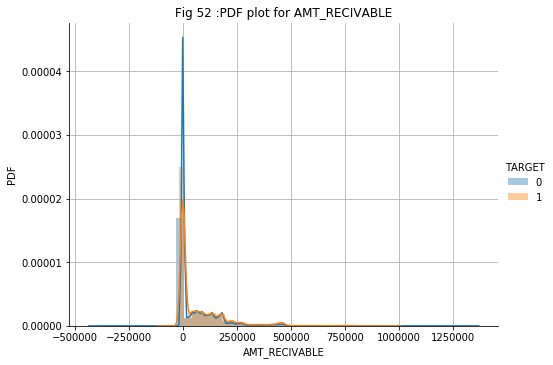



 Few statistical Informaion:


count    3.227965e+06
mean     5.886264e+04
std      1.062747e+05
min     -4.202502e+05
25%      0.000000e+00
50%      0.000000e+00
75%      9.020840e+04
max      1.354829e+06
Name: AMT_RECIVABLE, dtype: float64


<Figure size 504x432 with 0 Axes>

In [147]:
#plotting density plot
sns.FacetGrid(data=credit_card_balance_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'AMT_RECIVABLE').add_legend()
plt.title('Fig 52 :PDF plot for AMT_RECIVABLE')
plt.xlabel('AMT_RECIVABLE')
plt.ylabel('PDF')
plt.grid()
plt.show()
plt.figure(figsize=(7,6))
print("\n\n Few statistical Informaion:\n\n")
print(credit_card_balance_join_app.AMT_RECIVABLE.describe())

<h3><u>From fig 52: Observation:</u></h3><br>
We have range of values from -4.202502e+05 to 1.354829e+06 present in the sample.this feature seems similar to AMT_RECEIVABLE_PRINCIPAL

## 12.5.13 EDA -AMT_TOTAL_RECEIVABLE: Total amount receivable on the previous credit

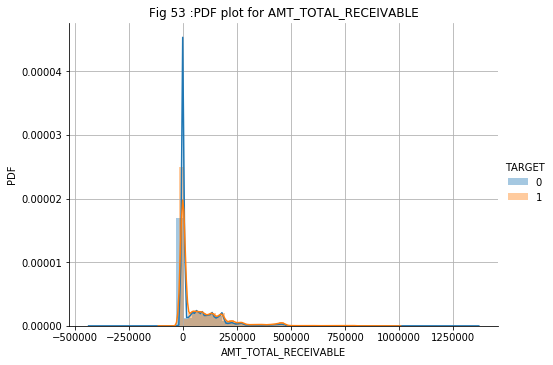



 Few statistical Informaion:


count    3.227965e+06
mean     5.887259e+04
std      1.062813e+05
min     -4.202502e+05
25%      0.000000e+00
50%      0.000000e+00
75%      9.022635e+04
max      1.354829e+06
Name: AMT_TOTAL_RECEIVABLE, dtype: float64


<Figure size 504x432 with 0 Axes>

In [148]:
#plotting density plot
sns.FacetGrid(data=credit_card_balance_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'AMT_TOTAL_RECEIVABLE').add_legend()
plt.title('Fig 53 :PDF plot for AMT_TOTAL_RECEIVABLE')
plt.xlabel('AMT_TOTAL_RECEIVABLE')
plt.ylabel('PDF')
plt.grid()
plt.show()
plt.figure(figsize=(7,6))
print("\n\n Few statistical Informaion:\n\n")
print(credit_card_balance_join_app.AMT_TOTAL_RECEIVABLE.describe())

<h3><u>From fig 53: Observation:</u></h3><br>
We have range of values from -4.202502e+05 to 1.493338e+06 present in the sample.This feature seems similar to AMT_RECIVABLE

## 12.5.14 EDA -CNT_DRAWINGS_ATM_CURRENT: Number of drawings at ATM during this month on the previous credit

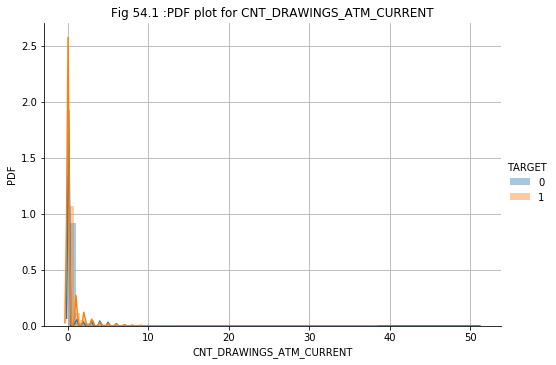

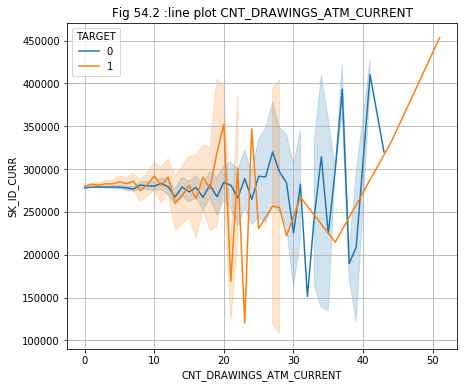



 Few statistical Informaion:


count    2.622211e+06
mean     3.150212e-01
std      1.112726e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      5.100000e+01
Name: CNT_DRAWINGS_ATM_CURRENT, dtype: float64


In [149]:
#plotting density plot
sns.FacetGrid(data=credit_card_balance_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'CNT_DRAWINGS_ATM_CURRENT').add_legend()
plt.title('Fig 54.1 :PDF plot for CNT_DRAWINGS_ATM_CURRENT')
plt.xlabel('CNT_DRAWINGS_ATM_CURRENT')
plt.ylabel('PDF')
plt.grid()
plt.show()
plt.figure(figsize=(7,6))
sns.lineplot(y=credit_card_balance_join_app.SK_ID_CURR,\
             x=credit_card_balance_join_app.CNT_DRAWINGS_ATM_CURRENT,sort=True,hue=installments_payments_join_app.TARGET)
plt.title('Fig 54.2 :line plot CNT_DRAWINGS_ATM_CURRENT')
plt.xlabel('CNT_DRAWINGS_ATM_CURRENT')
plt.ylabel('SK_ID_CURR')
plt.grid()
plt.show()
print("\n\n Few statistical Informaion:\n\n")
print(credit_card_balance_join_app.CNT_DRAWINGS_ATM_CURRENT.describe())

<h3><u>From fig 54: Observation:</u></h3><br>
The distribution is heavily skewed in the right side.<br>We have range of values from 0 to 51 in the sample

## 12.5.15 EDA - CNT_DRAWINGS_CURRENT: Number of drawings during this month on the previous credit

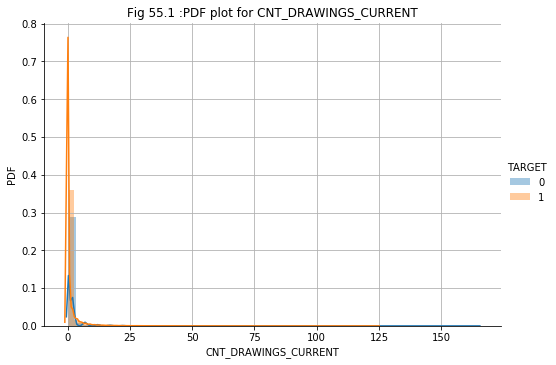

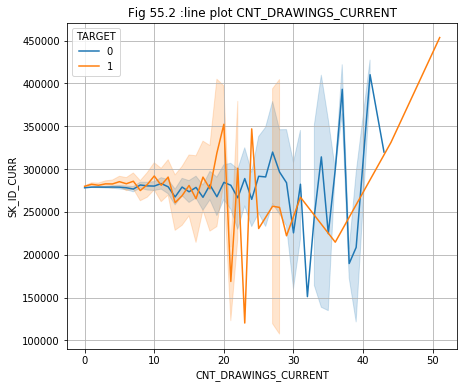



 Few statistical Informaion:


count    3.227965e+06
mean     7.011439e-01
std      3.171833e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.650000e+02
Name: CNT_DRAWINGS_CURRENT, dtype: float64


In [150]:
#plotting density plot
sns.FacetGrid(data=credit_card_balance_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'CNT_DRAWINGS_CURRENT').add_legend()
plt.title('Fig 55.1 :PDF plot for CNT_DRAWINGS_CURRENT')
plt.xlabel('CNT_DRAWINGS_CURRENT')
plt.ylabel('PDF')
plt.grid()
plt.show()
plt.figure(figsize=(7,6))
sns.lineplot(y=credit_card_balance_join_app.SK_ID_CURR,\
             x=credit_card_balance_join_app.CNT_DRAWINGS_ATM_CURRENT,sort=True,hue=installments_payments_join_app.TARGET)
plt.title('Fig 55.2 :line plot CNT_DRAWINGS_CURRENT')
plt.xlabel('CNT_DRAWINGS_CURRENT')
plt.ylabel('SK_ID_CURR')
plt.grid()
plt.show()
print("\n\n Few statistical Informaion:\n\n")
print(credit_card_balance_join_app.CNT_DRAWINGS_CURRENT.describe())

<h3><u>From fig 55: Observation:</u></h3><br>
The distribution is heavily skewed in the right side.
We have range of values from 0 to 165 in the sample

## 12.5.16 EDA - CNT_DRAWINGS_OTHER_CURRENT: Number of other drawings during this month on the previous credit

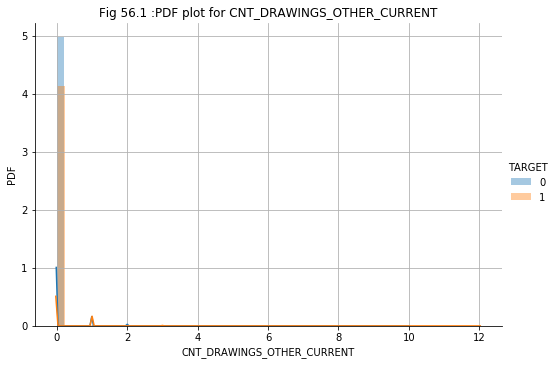

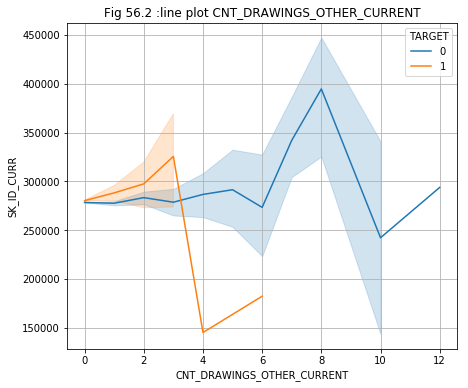



 Few statistical Informaion:


count    2.622211e+06
mean     4.988538e-03
std      8.408493e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.200000e+01
Name: CNT_DRAWINGS_OTHER_CURRENT, dtype: float64


In [152]:
#plotting density plot
sns.FacetGrid(data=credit_card_balance_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'CNT_DRAWINGS_OTHER_CURRENT').add_legend()
plt.title('Fig 56.1 :PDF plot for CNT_DRAWINGS_OTHER_CURRENT')
plt.xlabel('CNT_DRAWINGS_OTHER_CURRENT')
plt.ylabel('PDF')
plt.grid()
plt.show()
plt.figure(figsize=(7,6))
sns.lineplot(y=credit_card_balance_join_app.SK_ID_CURR,\
             x=credit_card_balance_join_app.CNT_DRAWINGS_OTHER_CURRENT,sort=True,hue=installments_payments_join_app.TARGET)
plt.title('Fig 56.2 :line plot CNT_DRAWINGS_OTHER_CURRENT')
plt.xlabel('CNT_DRAWINGS_OTHER_CURRENT')
plt.ylabel('SK_ID_CURR')
plt.grid()
plt.show()
print("\n\n Few statistical Informaion:\n\n")
print(credit_card_balance_join_app.CNT_DRAWINGS_OTHER_CURRENT.describe())

<h3><u>From fig 56: Observation:</u></h3><br>
The distribution is heavily skewed in the right side.
We have range of values from 0 to 12 in the sample

## 12.5.17 EDA - CNT_DRAWINGS_POS_CURRENT: Number of drawings for goods during this month on the previous credit

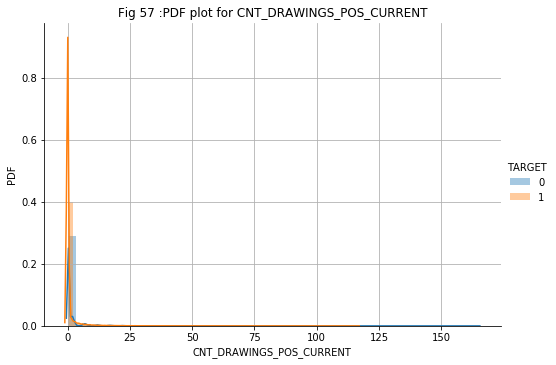



 Few statistical Informaion:


count    2.622211e+06
mean     5.431047e-01
std      3.193040e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.650000e+02
Name: CNT_DRAWINGS_POS_CURRENT, dtype: float64


<Figure size 504x432 with 0 Axes>

In [153]:
#plotting density plot
sns.FacetGrid(data=credit_card_balance_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'CNT_DRAWINGS_POS_CURRENT').add_legend()
plt.title('Fig 57 :PDF plot for CNT_DRAWINGS_POS_CURRENT')
plt.xlabel('CNT_DRAWINGS_POS_CURRENT')
plt.ylabel('PDF')
plt.grid()
plt.show()
plt.figure(figsize=(7,6))
print("\n\n Few statistical Informaion:\n\n")
print(credit_card_balance_join_app.CNT_DRAWINGS_POS_CURRENT.describe())

<h3><u>From fig 57: Observation:</u></h3><br>
The distribution is heavily skewed in the right side.
We have range of values from 0 to 165 in the sample

## 12.5.18 EDA - CNT_INSTALMENT_MATURE_CUM: Number of paid installments on the previous credit

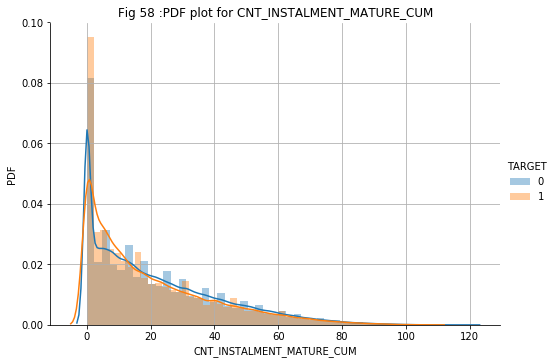



 Few statistical Informaion:


count    2.963581e+06
mean     2.108883e+01
std      1.998730e+01
min      0.000000e+00
25%      5.000000e+00
50%      1.600000e+01
75%      3.300000e+01
max      1.200000e+02
Name: CNT_INSTALMENT_MATURE_CUM, dtype: float64


<Figure size 504x432 with 0 Axes>

In [154]:
#plotting density plot
sns.FacetGrid(data=credit_card_balance_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'CNT_INSTALMENT_MATURE_CUM').add_legend()
plt.title('Fig 58 :PDF plot for CNT_INSTALMENT_MATURE_CUM')
plt.xlabel('CNT_INSTALMENT_MATURE_CUM')
plt.ylabel('PDF')
plt.grid()
plt.show()
plt.figure(figsize=(7,6))
print("\n\n Few statistical Informaion:\n\n")
print(credit_card_balance_join_app.CNT_INSTALMENT_MATURE_CUM.describe())

<h3><u>From fig 58: Observation:</u></h3><br>
The distribution is skewed in the right side.
We have range of values from 0 to 120 in the sample

## 12.5.19 EDA - SK_DPD: DPD (Days past due) during the month on the previous credit

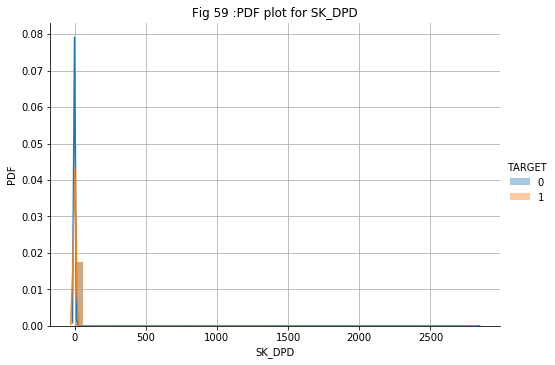



 Few statistical Informaion:


count    3.227965e+06
mean     9.494803e+00
std      9.805148e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.831000e+03
Name: SK_DPD, dtype: float64


<Figure size 504x432 with 0 Axes>

In [155]:
#plotting density plot
sns.FacetGrid(data=credit_card_balance_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'SK_DPD').add_legend()
plt.title('Fig 59 :PDF plot for SK_DPD')
plt.xlabel('SK_DPD')
plt.ylabel('PDF')
plt.grid()
plt.show()
plt.figure(figsize=(7,6))
print("\n\n Few statistical Informaion:\n\n")
print(credit_card_balance_join_app.SK_DPD.describe())

<h3><u>From fig 59: Observation:</u></h3><br>
The distribution is skewed in the right side. We have range of values from 0 to 2831 in the sample

## 12.5.20 EDA - SK_DPD_DEF: DPD (Days past due) during the month with tolerance (debts with low loan amounts are ignored) of the previous credit

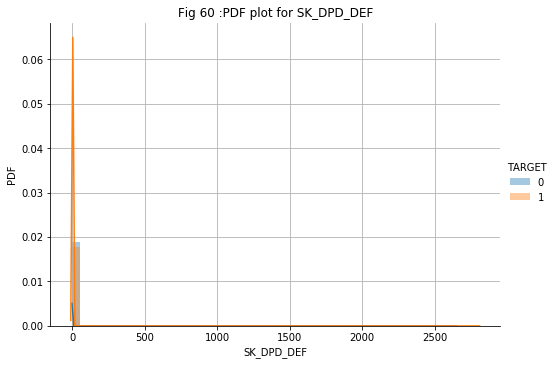



 Few statistical Informaion:


count    3.227965e+06
mean     2.857060e-01
std      1.957034e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.800000e+03
Name: SK_DPD_DEF, dtype: float64


<Figure size 504x432 with 0 Axes>

In [156]:
#plotting density plot
sns.FacetGrid(data=credit_card_balance_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'SK_DPD_DEF').add_legend()
plt.title('Fig 60 :PDF plot for SK_DPD_DEF')
plt.xlabel('SK_DPD_DEF')
plt.ylabel('PDF')
plt.grid()
plt.show()
plt.figure(figsize=(7,6))
print("\n\n Few statistical Informaion:\n\n")
print(credit_card_balance_join_app.SK_DPD_DEF.describe())

<h3><u>From fig 60: Observation:</u></h3><br>
The distribution is skewed in the right side. We have range of values from 0 to 2800 in the sample

## 12.6 EDA of categorical features- NAME_CONTRACT_STATUS

Unique values present in NAME_CONTRACT_STATUS : {nan, 'Refused', 'Active', 'Completed', 'Demand', 'Sent proposal', 'Approved', 'Signed'} 
No of unique values: 8


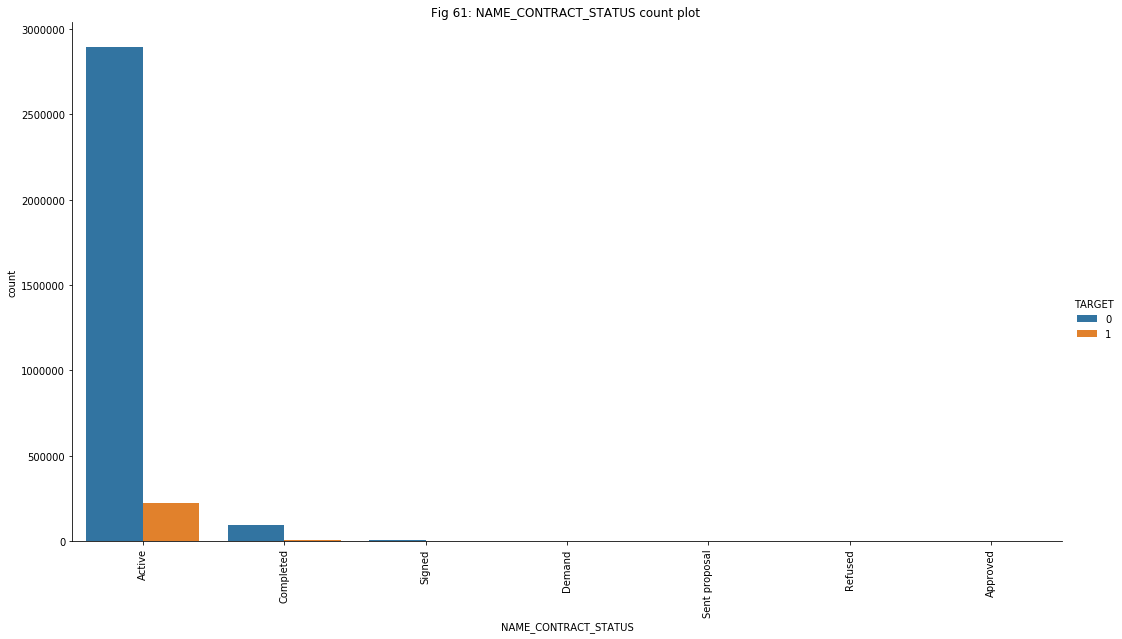

Counts of top 5 values of label 1:


Count of each category  \
NAME_CONTRACT_STATUS                           
Active                             96.839579   
Completed                           2.791292   
Signed                              0.287390   
Demand                              0.073043   
Sent proposal                       0.007826   

                      Percentage of count of each category  
NAME_CONTRACT_STATUS                                        
Active                                              222732  
Completed                                             6420  
Signed                                                 661  
Demand                                                 168  
Sent proposal                                           18

Counts of  top 5 values of label 0:


Count of each category  \
NAME_CONTRACT_STATUS                           
Active                             96.530212   
Completed                           3.122486   
Signed                              0.309477   
Demand                              0.022515   
Sent proposal                       0.014743   

                      Percentage of count of each category  
NAME_CONTRACT_STATUS                                        
Active                                             2893941  
Completed                                            93611  
Signed                                                9278  
Demand                                                 675  
Sent proposal                                          442

In [158]:
print("Unique values present in {} : {} ".format('NAME_CONTRACT_STATUS', set(credit_card_balance_join_app\
                                                                          ['NAME_CONTRACT_STATUS'].values)))
print("No of unique values: {}".format(len(set(credit_card_balance_join_app['NAME_CONTRACT_STATUS'].values))))
#plotting countplot in sorted manner for each unique value in the categorical feature
sns.catplot(x='NAME_CONTRACT_STATUS', kind="count",hue='TARGET', data=credit_card_balance_join_app,height=8, \
            aspect=15/8,order=credit_card_balance_join_app['NAME_CONTRACT_STATUS'].value_counts().index).\
set_xticklabels(rotation=90)
plt.title('Fig 61: {} count plot '.format('NAME_CONTRACT_STATUS'))
plt.show()

counts_1_percent,counts_0_percent=agg_count_details(credit_card_balance_join_app,'NAME_CONTRACT_STATUS')

#printing the top 5 values for both labels
print("Counts of top 5 values of label 1:")
display(counts_1_percent.head(5))
print("Counts of  top 5 values of label 0:")
display(counts_0_percent.head(5))

<h3><u>From fig 61: Observation:</u></h3><br>
There are 7 unique categories in the feature except nan values: 'Refused', 'Active', 'Completed', 'Demand', 'Sent proposal', 'Approved', 'Signed'

# 13. previous_application data analysis

## 13.1 Shape of the previous_application Datasets

In [159]:
print("Shape of previous_application: ",previous_application.shape)

Shape of previous_application:  (1670214, 37)


<h3><u>Observation:</u></h3><br>
There are total 37 features and 1.67 million rows in this dataset

## 13.2 snapshot of previous_application data

In [160]:
previous_application.head()

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START            ...            NAME_SELLER_INDUSTRY  \
0                       15            ...                    Connectivity   
1                       11            ...                             XNA   
2                       11            ...                             XNA   
3                        7            ...                             XNA   
4                        9            ...                             XNA   

   CNT_PAYMENT  NAME_YIELD_GROUP       PRODUCT_COMBINATION  \
0         12.0            middle  POS mobile with interest   
1         36.0        low_action          Cash X-Sell: low   
2         12.0              high         Cash X-Sell: high   
3         12.0            middle       Cash X-Sell: middle   
4         24.0              high         Cash Street: high   

   DAYS_FIRST_DRAWING DAYS_FIRST_DUE DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE  \
0            365243.0          -42.0                     300.0          -42.0   
1            365243.0         -134.0                     916.0       365243.0   
2            365243.0         -271.0                      59.0       365243.0   
3            365243.0         -482.0                    -152.0         -182.0   
4                 NaN            NaN                       NaN            NaN   

  DAYS_TERMINATION NFLAG_INSURED_ON_APPROVAL  
0            -37.0                       0.0  
1         365243.0                       1.0  
2         365243.0                       1.0  
3           -177.0                       1.0  
4              NaN                       NaN  

[5 rows x 37 columns]

## 13.3 name of all the features

In [161]:
previous_application.columns.values

array(['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY',
       'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT',
       'AMT_GOODS_PRICE', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'FLAG_LAST_APPL_PER_CONTRACT',
       'NFLAG_LAST_APPL_IN_DAY', 'RATE_DOWN_PAYMENT',
       'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED',
       'NAME_CASH_LOAN_PURPOSE', 'NAME_CONTRACT_STATUS', 'DAYS_DECISION',
       'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_TYPE_SUITE',
       'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO',
       'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'SELLERPLACE_AREA',
       'NAME_SELLER_INDUSTRY', 'CNT_PAYMENT', 'NAME_YIELD_GROUP',
       'PRODUCT_COMBINATION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE',
       'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION',
       'NFLAG_INSURED_ON_APPROVAL'], dtype=object)

In [163]:
print("Unique values in previous_application data SK_ID_CURR: ",len(previous_application["SK_ID_CURR"].unique()))

Unique values in previous_application data SK_ID_CURR:  338857


<h3><u>Observation:</u></h3><br>
We Have 37 features.<br>
We have several rows for each 'SK_ID_CURR' and there is .3 million unique SK_ID_CURR in the dataset.

## 13.3.1 Joining with application_train

In [164]:
#Joining with application train on 'SK_ID_CURR to get the 'TARGET' label
previous_application_join_app=application_train[['SK_ID_CURR','TARGET']].\
merge(previous_application,on = 'SK_ID_CURR', how = 'left')

print("After Joining bureau to application data on SK_ID_BUREAU new columns of the joined data: ",\
      previous_application_join_app.columns.values)

After Joining bureau to application data on SK_ID_BUREAU new columns of the joined data:  ['SK_ID_CURR' 'TARGET' 'SK_ID_PREV' 'NAME_CONTRACT_TYPE' 'AMT_ANNUITY'
 'AMT_APPLICATION' 'AMT_CREDIT' 'AMT_DOWN_PAYMENT' 'AMT_GOODS_PRICE'
 'WEEKDAY_APPR_PROCESS_START' 'HOUR_APPR_PROCESS_START'
 'FLAG_LAST_APPL_PER_CONTRACT' 'NFLAG_LAST_APPL_IN_DAY'
 'RATE_DOWN_PAYMENT' 'RATE_INTEREST_PRIMARY' 'RATE_INTEREST_PRIVILEGED'
 'NAME_CASH_LOAN_PURPOSE' 'NAME_CONTRACT_STATUS' 'DAYS_DECISION'
 'NAME_PAYMENT_TYPE' 'CODE_REJECT_REASON' 'NAME_TYPE_SUITE'
 'NAME_CLIENT_TYPE' 'NAME_GOODS_CATEGORY' 'NAME_PORTFOLIO'
 'NAME_PRODUCT_TYPE' 'CHANNEL_TYPE' 'SELLERPLACE_AREA'
 'NAME_SELLER_INDUSTRY' 'CNT_PAYMENT' 'NAME_YIELD_GROUP'
 'PRODUCT_COMBINATION' 'DAYS_FIRST_DRAWING' 'DAYS_FIRST_DUE'
 'DAYS_LAST_DUE_1ST_VERSION' 'DAYS_LAST_DUE' 'DAYS_TERMINATION'
 'NFLAG_INSURED_ON_APPROVAL']


In [165]:
#after joining with application train
previous_application_join_app.shape

(1430155, 38)

## 13.4 Missing value Statistics on the 9 features present in the joined data

In [166]:
#checking the information about application train features
miss_value(previous_application_join_app)

dtype  Unique values  Number of missing values  \
RATE_INTEREST_PRIMARY        float64            136                   1425364   
RATE_INTEREST_PRIVILEGED     float64             23                   1425364   
AMT_DOWN_PAYMENT             float64          26863                    765994   
RATE_DOWN_PAYMENT            float64         185078                    765994   
NAME_TYPE_SUITE               object              7                    711126   
NFLAG_INSURED_ON_APPROVAL    float64              2                    577560   
DAYS_TERMINATION             float64           2809                    577560   
DAYS_LAST_DUE                float64           2869                    577560   
DAYS_LAST_DUE_1ST_VERSION    float64           4604                    577560   
DAYS_FIRST_DUE               float64           2892                    577560   
DAYS_FIRST_DRAWING           float64           2799                    577560   
AMT_GOODS_PRICE              float64          86766                    335979   
AMT_ANNUITY                  float64         329537                    323672   
CNT_PAYMENT                  float64             48                    323667   
PRODUCT_COMBINATION           object             17                     16767   
AMT_CREDIT                   float64          81730                     16455   
NAME_YIELD_GROUP              object              5                     16454   
NAME_GOODS_CATEGORY           object             27                     16454   
NAME_SELLER_INDUSTRY          object             11                     16454   
SELLERPLACE_AREA             float64           2077                     16454   
CHANNEL_TYPE                  object              8                     16454   
NAME_PRODUCT_TYPE             object              3                     16454   
NAME_PORTFOLIO                object              5                     16454   
NAME_PAYMENT_TYPE             object              4                     16454   
NAME_CLIENT_TYPE              object              4                     16454   
CODE_REJECT_REASON            object              9                     16454   
DAYS_DECISION                float64           2922                     16454   
NAME_CONTRACT_STATUS          object              4                     16454   
NAME_CASH_LOAN_PURPOSE        object             25                     16454   
NFLAG_LAST_APPL_IN_DAY       float64              2                     16454   
FLAG_LAST_APPL_PER_CONTRACT   object              2                     16454   
HOUR_APPR_PROCESS_START      float64             24                     16454   
WEEKDAY_APPR_PROCESS_START    object              7                     16454   
AMT_APPLICATION              float64          86766                     16454   
NAME_CONTRACT_TYPE            object              4                     16454   
SK_ID_PREV                   float64        1413701                     16454   
TARGET                         int64              2                         0   
SK_ID_CURR                     int64         307511                         0   

                             Percentage missing  
RATE_INTEREST_PRIMARY                 99.665001  
RATE_INTEREST_PRIVILEGED              99.665001  
AMT_DOWN_PAYMENT                      53.560209  
RATE_DOWN_PAYMENT                     53.560209  
NAME_TYPE_SUITE                       49.723701  
NFLAG_INSURED_ON_APPROVAL             40.384434  
DAYS_TERMINATION                      40.384434  
DAYS_LAST_DUE                         40.384434  
DAYS_LAST_DUE_1ST_VERSION             40.384434  
DAYS_FIRST_DUE                        40.384434  
DAYS_FIRST_DRAWING                    40.384434  
AMT_GOODS_PRICE                       23.492489  
AMT_ANNUITY                           22.631952  
CNT_PAYMENT                           22.631603  
PRODUCT_COMBINATION                    1.172390  
AMT_CREDIT                             1.150575  
NAME_YIELD_GROUP     

<h3><u>Observation:</u></h3><br>
The top 2 features are missing 99% data, we need to ignore them as they hae less data<br>
Next top 9 features are missing 40-50% data, we need come up with imputation method to fill the data



## 13.5 EDA of numerical features

In [167]:
# Name of all the numerical features
previous_application_join_app.select_dtypes(exclude='object').columns.values

array(['SK_ID_CURR', 'TARGET', 'SK_ID_PREV', 'AMT_ANNUITY',
       'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT',
       'AMT_GOODS_PRICE', 'HOUR_APPR_PROCESS_START',
       'NFLAG_LAST_APPL_IN_DAY', 'RATE_DOWN_PAYMENT',
       'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED',
       'DAYS_DECISION', 'SELLERPLACE_AREA', 'CNT_PAYMENT',
       'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE',
       'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION',
       'NFLAG_INSURED_ON_APPROVAL'], dtype=object)

## 13.5.1 EDA - AMT_ANNUITY:Annuity of previous application

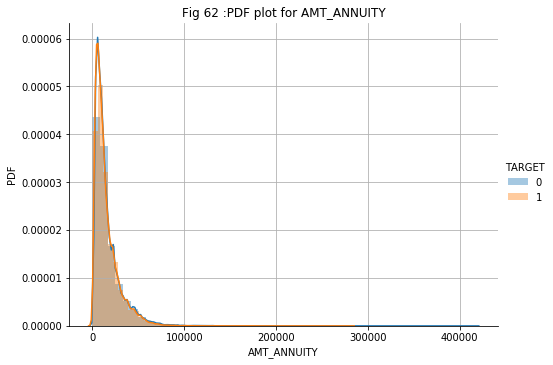



 Few statistical Informaion:


count    1.106483e+06
mean     1.583718e+04
std      1.472491e+04
min      0.000000e+00
25%      6.257858e+03
50%      1.122376e+04
75%      2.042078e+04
max      4.180581e+05
Name: AMT_ANNUITY, dtype: float64


<Figure size 504x432 with 0 Axes>

In [168]:
#plotting density plot
sns.FacetGrid(data=previous_application_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'AMT_ANNUITY').add_legend()
plt.title('Fig 62 :PDF plot for AMT_ANNUITY')
plt.xlabel('AMT_ANNUITY')
plt.ylabel('PDF')
plt.grid()
plt.show()
plt.figure(figsize=(7,6))
print("\n\n Few statistical Informaion:\n\n")
print(previous_application_join_app.AMT_ANNUITY.describe())

<h3><u>From fig 62: Observation:</u></h3><br>
The distribution is heavily right skewed.<br>
We have range of values from 0 to 4.180581e+05 present in the sample.Most client have low annuity amount.

## 13.5.2 EDA - AMT_APPLICATION:For how much credit did client ask on the previous application

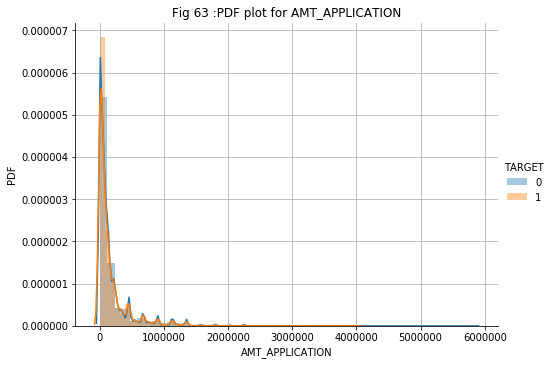



 Few statistical Informaion:


count    1.413701e+06
mean     1.752436e+05
std      2.936222e+05
min      0.000000e+00
25%      1.975050e+04
50%      7.087050e+04
75%      1.800000e+05
max      5.850000e+06
Name: AMT_APPLICATION, dtype: float64


<Figure size 504x432 with 0 Axes>

In [169]:
#plotting density plot
sns.FacetGrid(data=previous_application_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'AMT_APPLICATION').add_legend()
plt.title('Fig 63 :PDF plot for AMT_APPLICATION')
plt.xlabel('AMT_APPLICATION')
plt.ylabel('PDF')
plt.grid()
plt.show()
plt.figure(figsize=(7,6))
print("\n\n Few statistical Informaion:\n\n")
print(previous_application_join_app.AMT_APPLICATION.describe())

<h3><u>From fig 63: Observation:</u></h3><br>
The distribution is heavily right skewed.
We have range of values from 0 to 5.850000e+06 present in the sample.

## 13.5.3 AMT_CREDIT:Final credit amount on the previous application. This differs from AMT_APPLICATION in a way that the AMT_APPLICATION is the amount for which the client initially applied for, but during our approval process he could have received different amount - AMT_CREDIT

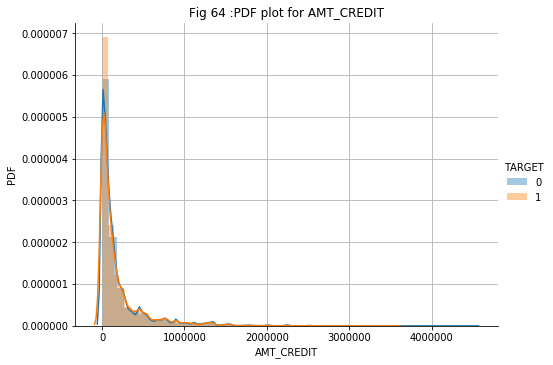



 Few statistical Informaion:


count    1.413700e+06
mean     1.963541e+05
std      3.194813e+05
min      0.000000e+00
25%      2.488050e+04
50%      8.059500e+04
75%      2.156400e+05
max      4.509688e+06
Name: AMT_CREDIT, dtype: float64


<Figure size 504x432 with 0 Axes>

In [170]:
#plotting density plot
sns.FacetGrid(data=previous_application_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'AMT_CREDIT').add_legend()
plt.title('Fig 64 :PDF plot for AMT_CREDIT')
plt.xlabel('AMT_CREDIT')
plt.ylabel('PDF')
plt.grid()
plt.show()
plt.figure(figsize=(7,6))
print("\n\n Few statistical Informaion:\n\n")
print(previous_application_join_app.AMT_CREDIT.describe())

<h3><u>From fig 64: Observation:</u></h3><br>
The distribution is heavily right skewed. We have range of values from 0 to 4.509688e+06 present in the sample.This is similar to AMT_APPLICATION,but actual amount approved

## 13.5.4 EDA - AMT_DOWN_PAYMENT:Down payment on the previous application

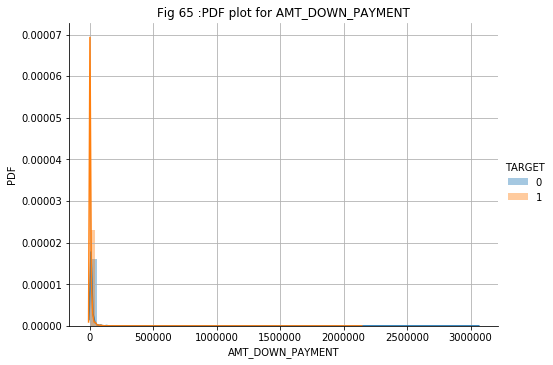



 Few statistical Informaion:


count    6.641610e+05
mean     6.655317e+03
std      2.062030e+04
min     -9.000000e-01
25%      0.000000e+00
50%      1.791000e+03
75%      7.695000e+03
max      3.060045e+06
Name: AMT_DOWN_PAYMENT, dtype: float64


<Figure size 504x432 with 0 Axes>

In [172]:
#plotting density plot
sns.FacetGrid(data=previous_application_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'AMT_DOWN_PAYMENT').add_legend()
plt.title('Fig 65 :PDF plot for AMT_DOWN_PAYMENT')
plt.xlabel('AMT_DOWN_PAYMENT')
plt.ylabel('PDF')
plt.grid()
plt.show()
plt.figure(figsize=(7,6))
print("\n\n Few statistical Informaion:\n\n")
print(previous_application_join_app.AMT_DOWN_PAYMENT.describe())

In [173]:
previous_application_join_app[previous_application_join_app['AMT_DOWN_PAYMENT']<0]['AMT_DOWN_PAYMENT']

132103    -0.45
1003957   -0.90
Name: AMT_DOWN_PAYMENT, dtype: float64

<h3><u>From fig 65: Observation:</u></h3><br>
The distribution is heavily right skewed. We have range of values from -0.45 to 3.060045e+06 present in the sample.The negative amounts seems to be outlier as down payment can not be negative.

## 13.5.5 EDA - AMT_GOODS_PRICE:Goods price of good that client asked for (if applicable) on the previous application

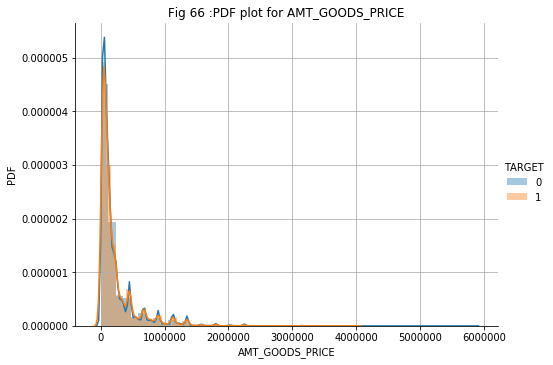



 Few statistical Informaion:


count    1.094176e+06
mean     2.264512e+05
std      3.159376e+05
min      0.000000e+00
25%      4.982850e+04
50%      1.102455e+05
75%      2.295000e+05
max      5.850000e+06
Name: AMT_GOODS_PRICE, dtype: float64


<Figure size 504x432 with 0 Axes>

In [175]:
#plotting density plot
sns.FacetGrid(data=previous_application_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'AMT_GOODS_PRICE').add_legend()
plt.title('Fig 66 :PDF plot for AMT_GOODS_PRICE')
plt.xlabel('AMT_GOODS_PRICE')
plt.ylabel('PDF')
plt.grid()
plt.show()
plt.figure(figsize=(7,6))
print("\n\n Few statistical Informaion:\n\n")
print(previous_application_join_app.AMT_GOODS_PRICE.describe())

<h3><u>From fig 66: Observation:</u></h3><br>
The distribution is heavily right skewed. We have range of values from 0 to 5.850000e+06 present in the sample.

## 13.5.6 EDA - HOUR_APPR_PROCESS_START:Approximately at what day hour did the client apply for the previous application

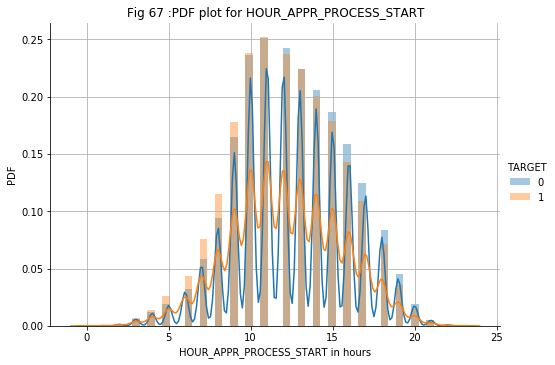



 Few statistical Informaion:


count    1.413701e+06
mean     1.247893e+01
std      3.331474e+00
min      0.000000e+00
25%      1.000000e+01
50%      1.200000e+01
75%      1.500000e+01
max      2.300000e+01
Name: HOUR_APPR_PROCESS_START, dtype: float64


<Figure size 504x432 with 0 Axes>

In [177]:
#plotting density plot
sns.FacetGrid(data=previous_application_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'HOUR_APPR_PROCESS_START').add_legend()
plt.title('Fig 67 :PDF plot for HOUR_APPR_PROCESS_START')
plt.xlabel('HOUR_APPR_PROCESS_START in hours')
plt.ylabel('PDF')
plt.grid()
plt.show()
plt.figure(figsize=(7,6))
print("\n\n Few statistical Informaion:\n\n")
print(previous_application_join_app.HOUR_APPR_PROCESS_START.describe())

<h3><u>From fig 67: Observation:</u></h3><br>
We have range of values from 0 to 24 hours data present in the sample.

## 13.5.7 EDA - RATE_DOWN_PAYMENT:Down payment rate normalized on previous credit

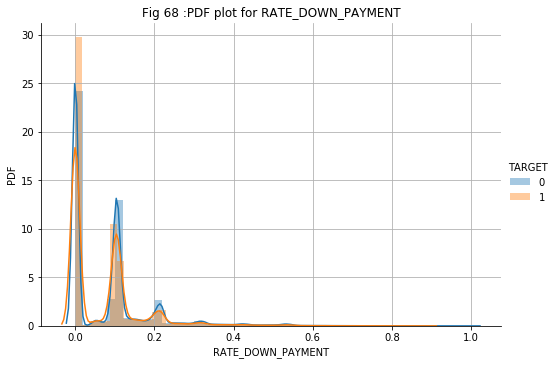



 Few statistical Informaion:


count    664161.000000
mean          0.080175
std           0.107784
min          -0.000015
25%           0.000000
50%           0.062489
75%           0.108912
max           1.000000
Name: RATE_DOWN_PAYMENT, dtype: float64


<Figure size 504x432 with 0 Axes>

In [181]:
#plotting density plot
sns.FacetGrid(data=previous_application_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'RATE_DOWN_PAYMENT').add_legend()
plt.title('Fig 68 :PDF plot for RATE_DOWN_PAYMENT')
plt.xlabel('RATE_DOWN_PAYMENT')
plt.ylabel('PDF')
plt.grid()
plt.show()
plt.figure(figsize=(7,6))
print("\n\n Few statistical Informaion:\n\n")
print(previous_application_join_app.RATE_DOWN_PAYMENT.describe())

<h3><u>From fig 68: Observation:</u></h3><br>
the value ranges from -0.000015 to 1 as dat is normalized

## 13.5.8 EDA - NFLAG_LAST_APPL_IN_DAY:Flag if the application was the last application per day of the client. Sometimes clients apply for more applications a day. Rarely it could also be error in our system that one application is in the database twice

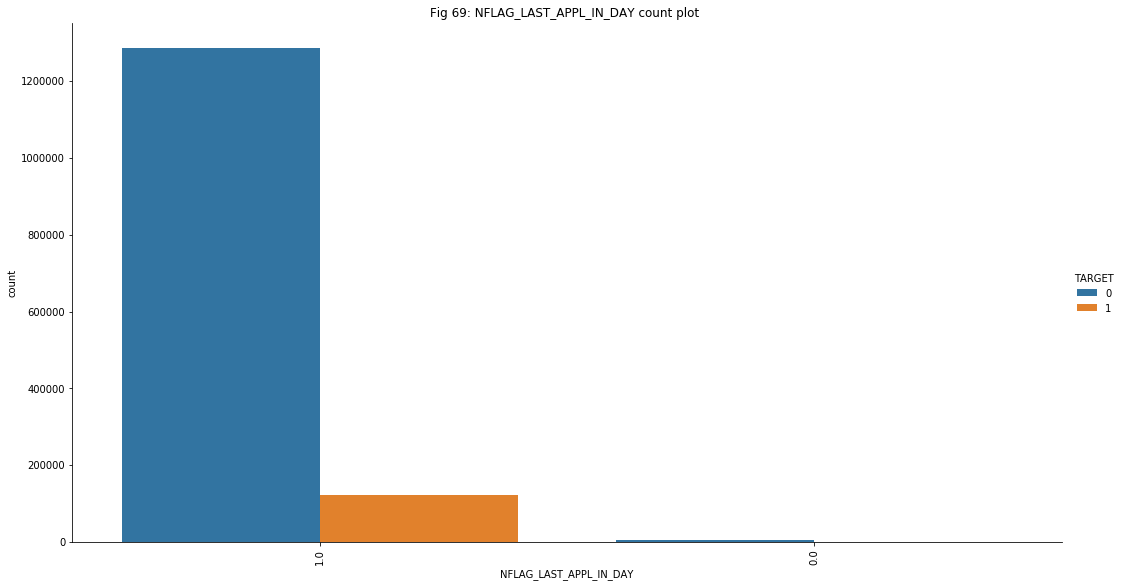

In [183]:
#plotting countplot in sorted manner for each unique value in the categorical feature
sns.catplot(x='NFLAG_LAST_APPL_IN_DAY', kind="count",hue='TARGET', data=previous_application_join_app,height=8, \
            aspect=15/8,order=previous_application_join_app['NFLAG_LAST_APPL_IN_DAY'].value_counts().index).\
set_xticklabels(rotation=90)
plt.title('Fig 69: {} count plot '.format('NFLAG_LAST_APPL_IN_DAY'))
plt.show()

<h3><u>From fig 69: Observation:</u></h3><br>
There are 2 unique value 1,0 as it is a binary flag, most have flag 1

## 13.5.9 EDA - DAYS_DECISION:Relative to current application when was the decision about previous application made

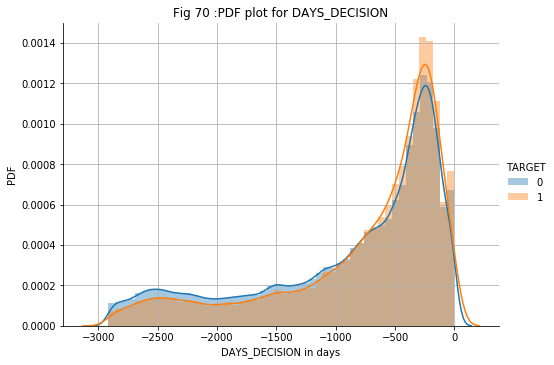



 Few statistical Informaion:


count    1.413701e+06
mean    -8.803670e+02
std      7.835402e+02
min     -2.922000e+03
25%     -1.313000e+03
50%     -5.820000e+02
75%     -2.710000e+02
max     -1.000000e+00
Name: DAYS_DECISION, dtype: float64


<Figure size 504x432 with 0 Axes>

In [185]:
#plotting density plot
sns.FacetGrid(data=previous_application_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'DAYS_DECISION').add_legend()
plt.title('Fig 70 :PDF plot for DAYS_DECISION')
plt.xlabel('DAYS_DECISION in days')
plt.ylabel('PDF')
plt.grid()
plt.show()
plt.figure(figsize=(7,6))
print("\n\n Few statistical Informaion:\n\n")
print(previous_application_join_app.DAYS_DECISION.describe())

<h3><u>From fig 70: Observation:</u></h3><br>
We have range of values from 0 to -2922 days data present in the sample.

## 13.5.10 EDA - SELLERPLACE_AREA:Selling area of seller place of the previous application

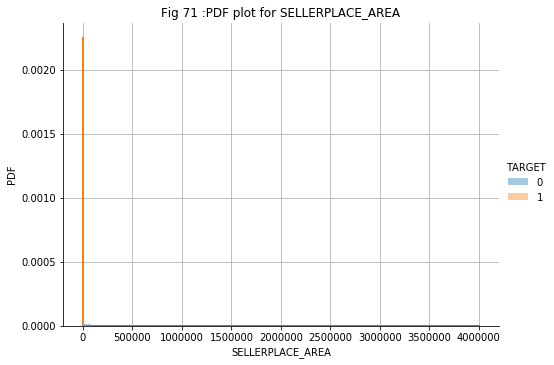



 Few statistical Informaion:


count    1.413701e+06
mean     3.149878e+02
std      7.695082e+03
min     -1.000000e+00
25%     -1.000000e+00
50%      4.000000e+00
75%      8.500000e+01
max      4.000000e+06
Name: SELLERPLACE_AREA, dtype: float64


<Figure size 504x432 with 0 Axes>

In [188]:
#plotting density plot
sns.FacetGrid(data=previous_application_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'SELLERPLACE_AREA').add_legend()
plt.title('Fig 71 :PDF plot for SELLERPLACE_AREA')
plt.xlabel('SELLERPLACE_AREA')
plt.ylabel('PDF')
plt.grid()
plt.show()
plt.figure(figsize=(7,6))
print("\n\n Few statistical Informaion:\n\n")
print(previous_application_join_app.SELLERPLACE_AREA.describe())

In [189]:
previous_application_join_app[previous_application_join_app['SELLERPLACE_AREA']>4e5]['SELLERPLACE_AREA']

512461     4000000.0
676541     4000000.0
1169596    4000000.0
1178638    4000000.0
1406251    4000000.0
Name: SELLERPLACE_AREA, dtype: float64

<h3><u>From fig 71: Observation:</u></h3><br>
The data is highly right sided skewed.
negative value seems to be outlier.Rest of the value ranges from 0 to 4.000000e+06.Any value more than 4e5 seems to be outlier.

## 13.5.11 EDA - CNT_PAYMENT:Term of previous credit at application of the previous application

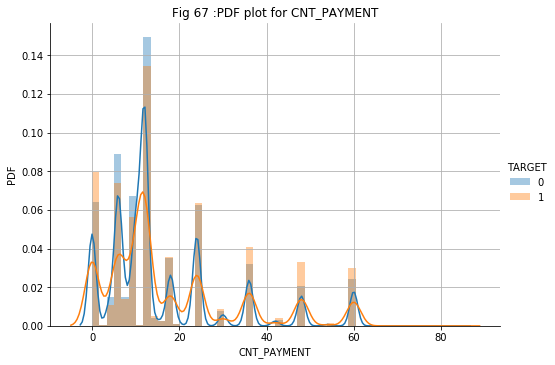



 Few statistical Informaion:


count    1.106488e+06
mean     1.605194e+01
std      1.456675e+01
min      0.000000e+00
25%      6.000000e+00
50%      1.200000e+01
75%      2.400000e+01
max      8.400000e+01
Name: CNT_PAYMENT, dtype: float64


<Figure size 504x432 with 0 Axes>

In [190]:
#plotting density plot
sns.FacetGrid(data=previous_application_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'CNT_PAYMENT').add_legend()
plt.title('Fig 72 :PDF plot for CNT_PAYMENT')
plt.xlabel('CNT_PAYMENT')
plt.ylabel('PDF')
plt.grid()
plt.show()
print("\n\n Few statistical Informaion:\n\n")
print(previous_application_join_app.CNT_PAYMENT.describe())

<h3><u>From fig 72: Observation:</u></h3><br>
We have range of values from 0 to 84 data present in the sample.

## 13.5.12 EDA - DAYS_FIRST_DRAWING:Relative to application date of current application when was the first disbursement of the previous application


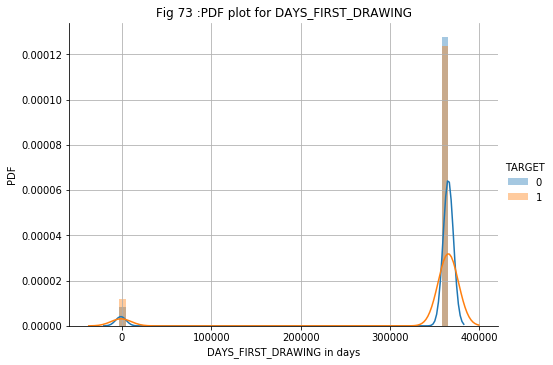



 Few statistical Informaion:


count    852595.000000
mean     342257.656710
std       88832.266598
min       -2922.000000
25%      365243.000000
50%      365243.000000
75%      365243.000000
max      365243.000000
Name: DAYS_FIRST_DRAWING, dtype: float64


In [201]:
#plotting density plot
sns.FacetGrid(data=previous_application_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'DAYS_FIRST_DRAWING').add_legend()
plt.title('Fig 73 :PDF plot for DAYS_FIRST_DRAWING')
plt.xlabel('DAYS_FIRST_DRAWING in days')
plt.ylabel('PDF')
plt.grid()
plt.show()
print("\n\n Few statistical Informaion:\n\n")
print(previous_application_join_app.DAYS_FIRST_DRAWING.describe())

<h3><u>From fig 73: Observation:</u></h3><br>
We have range of values from 0 to -2922 days data present in the sample and 365243.000000 days is an outlier 

## 13.5.13 EDA - DAYS_FIRST_DUE:Relative to application date of current application when was the first due supposed to be of the previous application


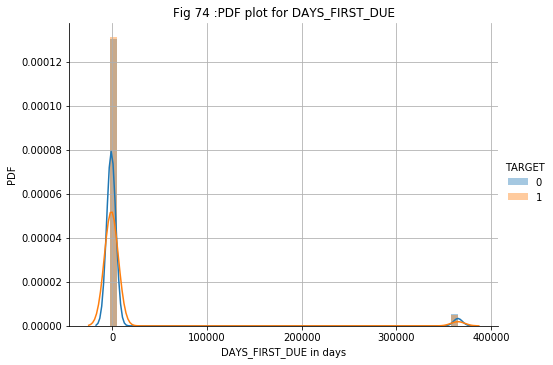



 Few statistical Informaion:


count    852595.000000
mean      13488.741567
std       71650.147146
min       -2892.000000
25%       -1630.000000
50%        -825.000000
75%        -408.000000
max      365243.000000
Name: DAYS_FIRST_DUE, dtype: float64


In [202]:
#plotting density plot
sns.FacetGrid(data=previous_application_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'DAYS_FIRST_DUE').add_legend()
plt.title('Fig 74 :PDF plot for DAYS_FIRST_DUE')
plt.xlabel('DAYS_FIRST_DUE in days')
plt.ylabel('PDF')
plt.grid()
plt.show()
print("\n\n Few statistical Informaion:\n\n")
print(previous_application_join_app.DAYS_FIRST_DUE.describe())

<h3><u>From fig 74: Observation:</u></h3><br>
We have range of values from 0 to -2892 days data present in the sample and 365243.000000 days is an outlier 

## 13.5.14 EDA -DAYS_LAST_DUE_1ST_VERSION:Relative to application date of current application when was the first due of the previous application


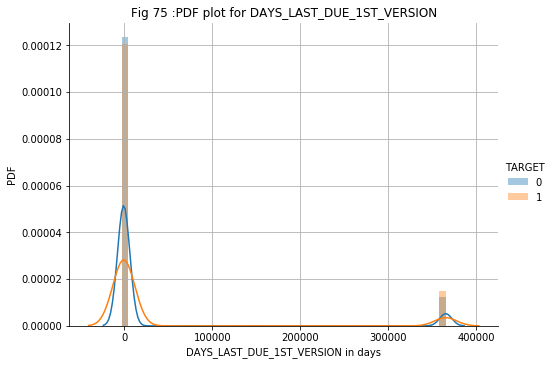



 Few statistical Informaion:


count    852595.000000
mean      33274.831806
std      106161.775933
min       -2801.000000
25%       -1244.000000
50%        -358.000000
75%         135.000000
max      365243.000000
Name: DAYS_LAST_DUE_1ST_VERSION, dtype: float64


In [203]:
#plotting density plot
sns.FacetGrid(data=previous_application_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'DAYS_LAST_DUE_1ST_VERSION').add_legend()
plt.title('Fig 75 :PDF plot for DAYS_LAST_DUE_1ST_VERSION')
plt.xlabel('DAYS_LAST_DUE_1ST_VERSION in days')
plt.ylabel('PDF')
plt.grid()
plt.show()
print("\n\n Few statistical Informaion:\n\n")
print(previous_application_join_app.DAYS_LAST_DUE_1ST_VERSION.describe())

<h3><u>From fig 75: Observation:</u></h3><br>
We have range of values from 0 to -2801 days data present in the sample and 365243.000000 days is an outlier 

## 13.5.15 EDA - DAYS_LAST_DUE:Relative to application date of current application when was the last due date of the previous application

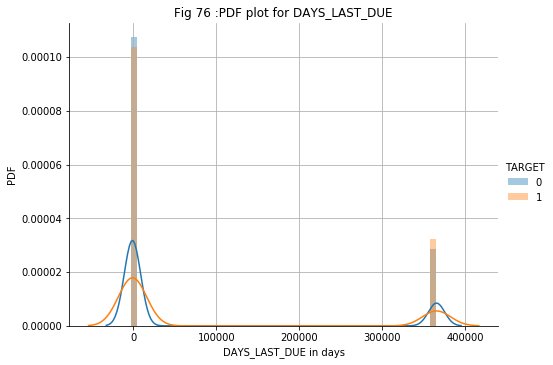



 Few statistical Informaion:


count    852595.000000
mean      76665.634755
std      149704.716371
min       -2889.000000
25%       -1316.000000
50%        -534.000000
75%         -73.000000
max      365243.000000
Name: DAYS_LAST_DUE, dtype: float64


In [204]:
#plotting density plot
sns.FacetGrid(data=previous_application_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'DAYS_LAST_DUE').add_legend()
plt.title('Fig 76 :PDF plot for DAYS_LAST_DUE')
plt.xlabel('DAYS_LAST_DUE in days')
plt.ylabel('PDF')
plt.grid()
plt.show()
print("\n\n Few statistical Informaion:\n\n")
print(previous_application_join_app.DAYS_LAST_DUE.describe())

<h3><u>From fig 76: Observation:</u></h3><br>
We have range of values from 0 to -2889 days data present in the sample and 365243.000000 days is an outlier 

## 13.5.16 EDA - DAYS_TERMINATION:Relative to application date of current application when was the expected termination of the previous application


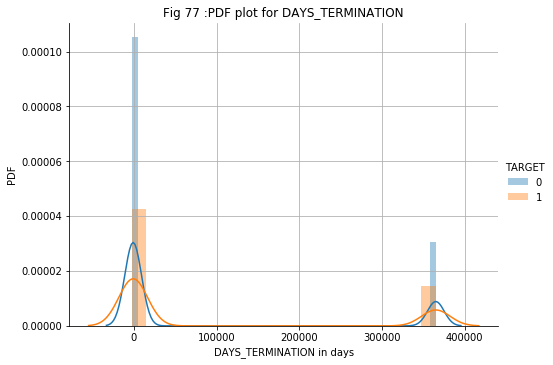



 Few statistical Informaion:


count    852595.000000
mean      82353.171672
std      153537.064274
min       -2874.000000
25%       -1269.000000
50%        -494.000000
75%         -42.000000
max      365243.000000
Name: DAYS_TERMINATION, dtype: float64


In [205]:
#plotting density plot
sns.FacetGrid(data=previous_application_join_app, hue='TARGET', height=5, aspect=10/7). \
map(sns.distplot, 'DAYS_TERMINATION').add_legend()
plt.title('Fig 77 :PDF plot for DAYS_TERMINATION')
plt.xlabel('DAYS_TERMINATION in days')
plt.ylabel('PDF')
plt.grid()
plt.show()
print("\n\n Few statistical Informaion:\n\n")
print(previous_application_join_app.DAYS_TERMINATION.describe())

<h3><u>From fig 77: Observation:</u></h3><br>
We have range of values from 0 to -2874 days data present in the sample and 365243.000000 days is an outlier 

## 13.6 EDA of categorical features

In [206]:
#all the categorical features
previous_application_join_app.select_dtypes('object').columns.values

array(['NAME_CONTRACT_TYPE', 'WEEKDAY_APPR_PROCESS_START',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON',
       'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY',
       'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE',
       'NAME_SELLER_INDUSTRY', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION'],
      dtype=object)

In [229]:
#plot a count plot of each unique categories 
def categorical_analysis(data,feature_name):
    
    #plotting countplot in sorted manner for each unique value in the categorical feature
    sns.catplot(x=feature_name, kind="count",hue='TARGET', data=data,height=8, \
                aspect=15/8,order=data[feature_name].value_counts().index).\
    set_xticklabels(rotation=90)
    plt.title('{} count plot '.format(feature_name))
    plt.show()
    #calculating count of total unique categories and name 
    print("\n\nNo of unique values: {}\n".format(len(set(data[feature_name].values))))
    print("Unique values present in {}: {} \n".format(feature_name, set(data\
                                                                              [feature_name].values)))
    


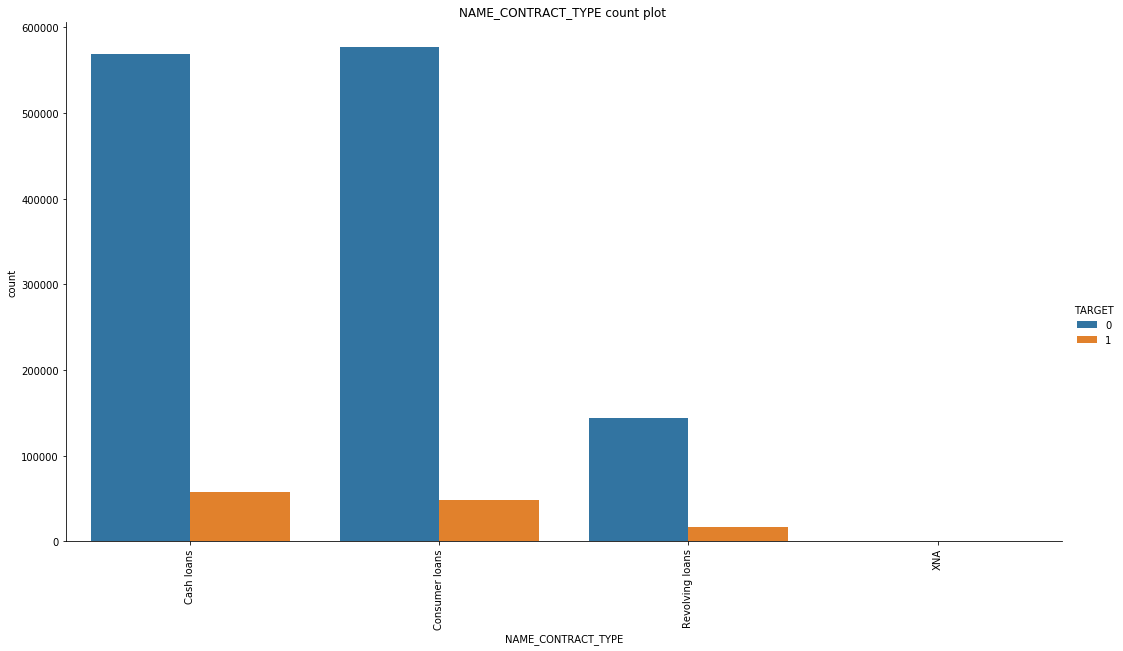



No of unique values: 5

Unique values present in NAME_CONTRACT_TYPE: {nan, 'Cash loans', 'XNA', 'Revolving loans', 'Consumer loans'} 



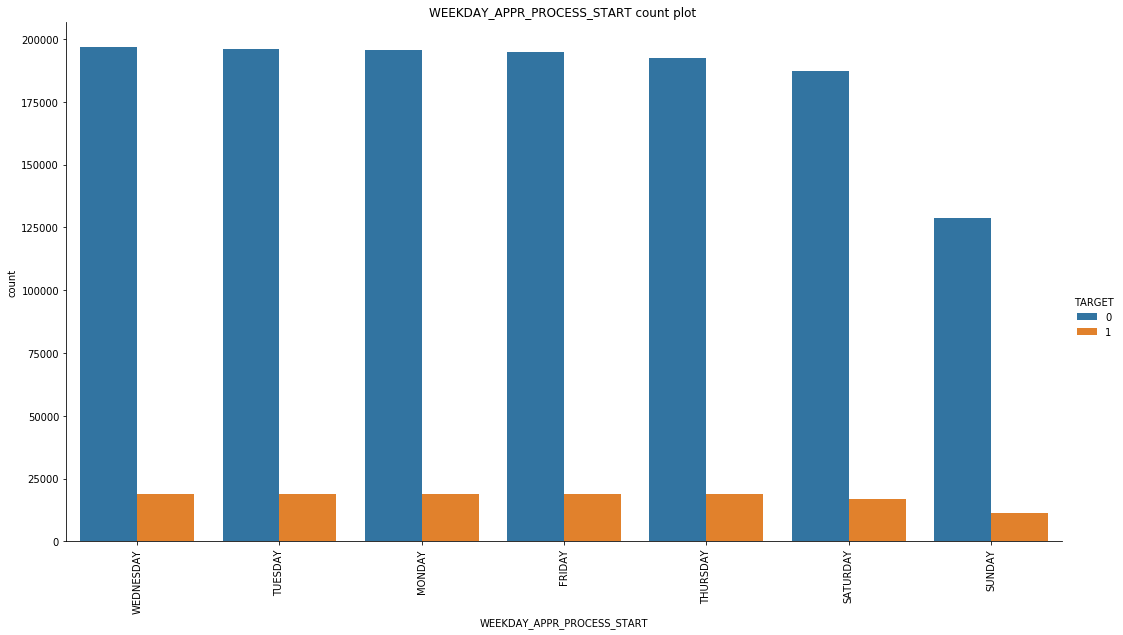



No of unique values: 8

Unique values present in WEEKDAY_APPR_PROCESS_START: {nan, 'SUNDAY', 'TUESDAY', 'THURSDAY', 'FRIDAY', 'SATURDAY', 'MONDAY', 'WEDNESDAY'} 



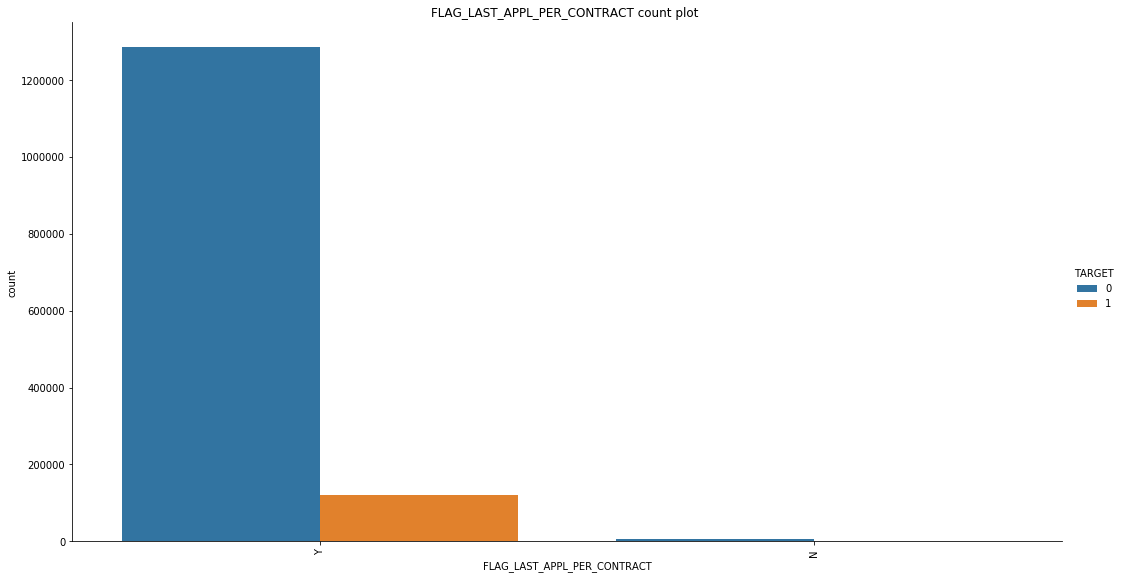



No of unique values: 3

Unique values present in FLAG_LAST_APPL_PER_CONTRACT: {'Y', nan, 'N'} 



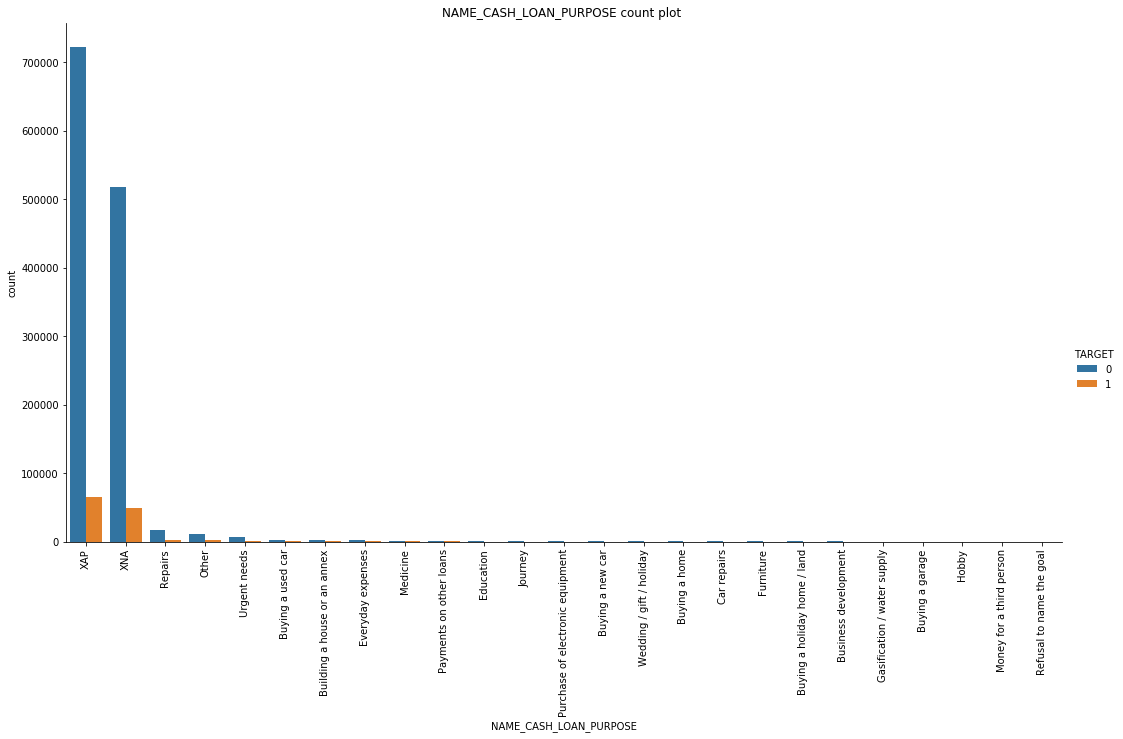



No of unique values: 26

Unique values present in NAME_CASH_LOAN_PURPOSE: {nan, 'Buying a used car', 'Other', 'Buying a new car', 'Medicine', 'Car repairs', 'Buying a garage', 'Wedding / gift / holiday', 'Education', 'Everyday expenses', 'Business development', 'XAP', 'Gasification / water supply', 'Hobby', 'Refusal to name the goal', 'Money for a third person', 'Repairs', 'XNA', 'Urgent needs', 'Purchase of electronic equipment', 'Building a house or an annex', 'Furniture', 'Buying a holiday home / land', 'Buying a home', 'Payments on other loans', 'Journey'} 



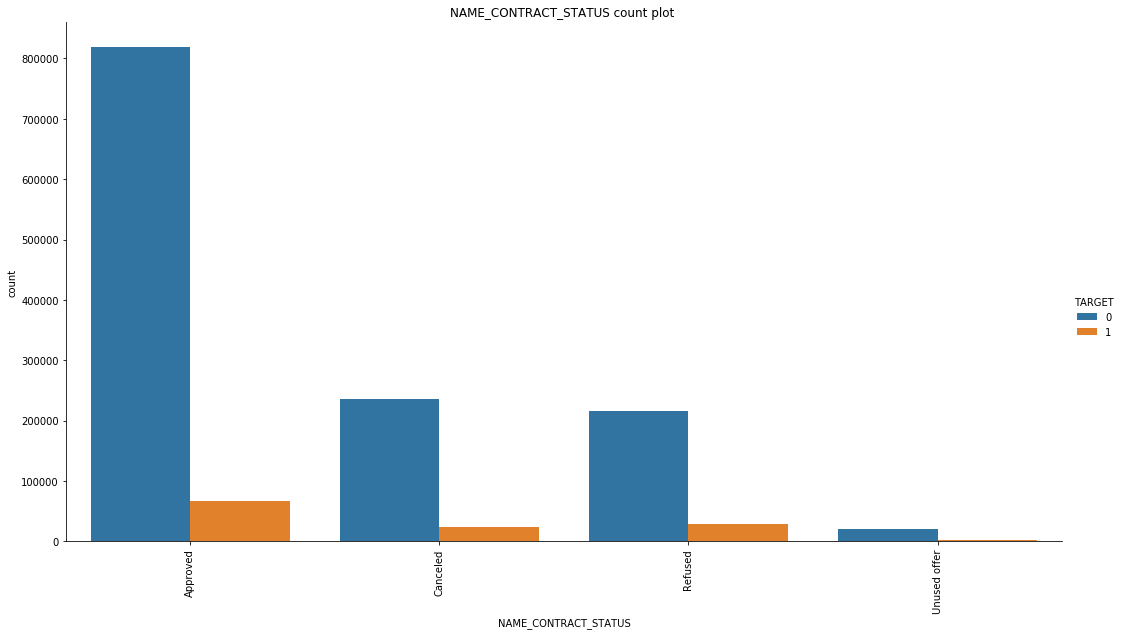



No of unique values: 5

Unique values present in NAME_CONTRACT_STATUS: {'Canceled', 'Refused', 'Unused offer', nan, 'Approved'} 



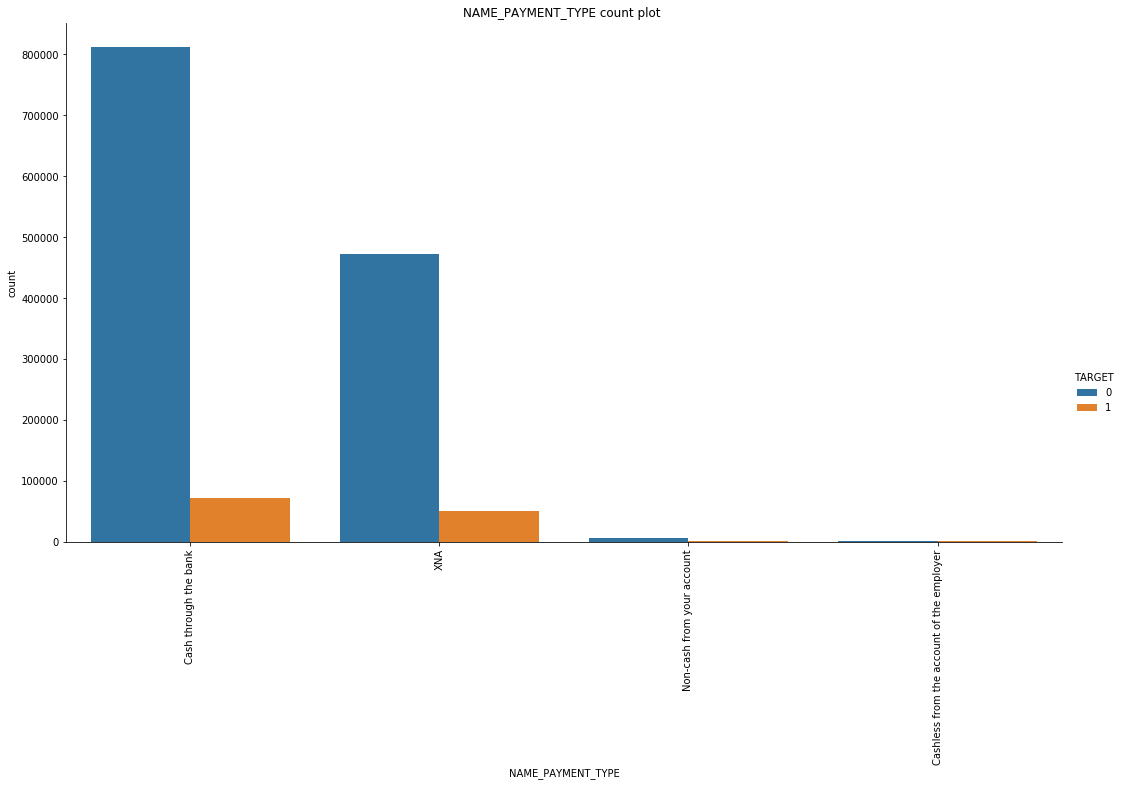



No of unique values: 5

Unique values present in NAME_PAYMENT_TYPE: {nan, 'Cash through the bank', 'XNA', 'Cashless from the account of the employer', 'Non-cash from your account'} 



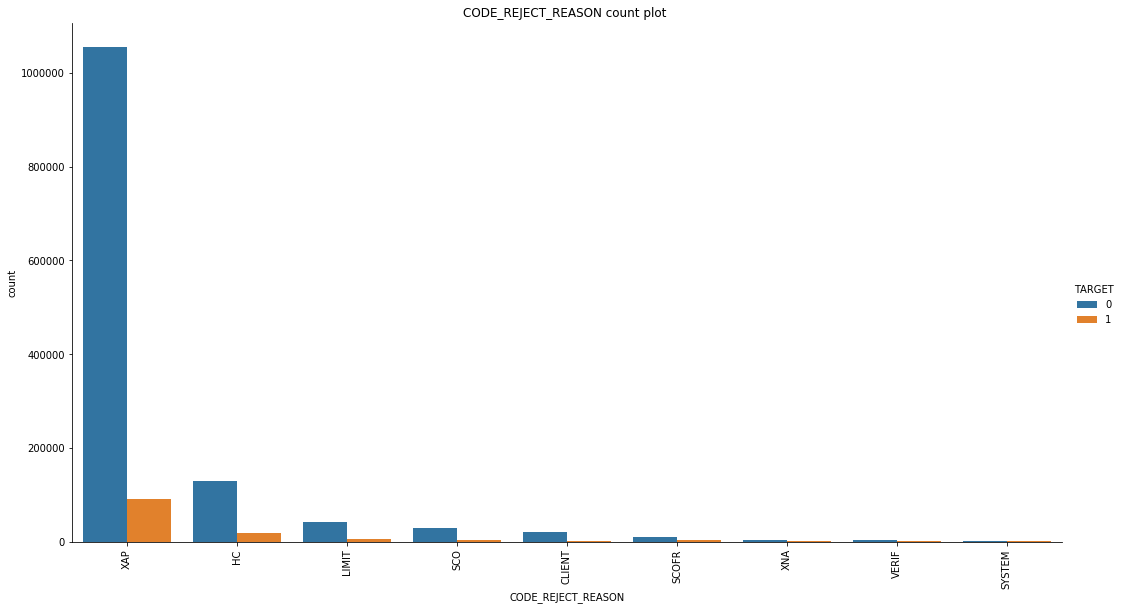



No of unique values: 10

Unique values present in CODE_REJECT_REASON: {nan, 'SCO', 'XNA', 'XAP', 'CLIENT', 'LIMIT', 'VERIF', 'SYSTEM', 'SCOFR', 'HC'} 



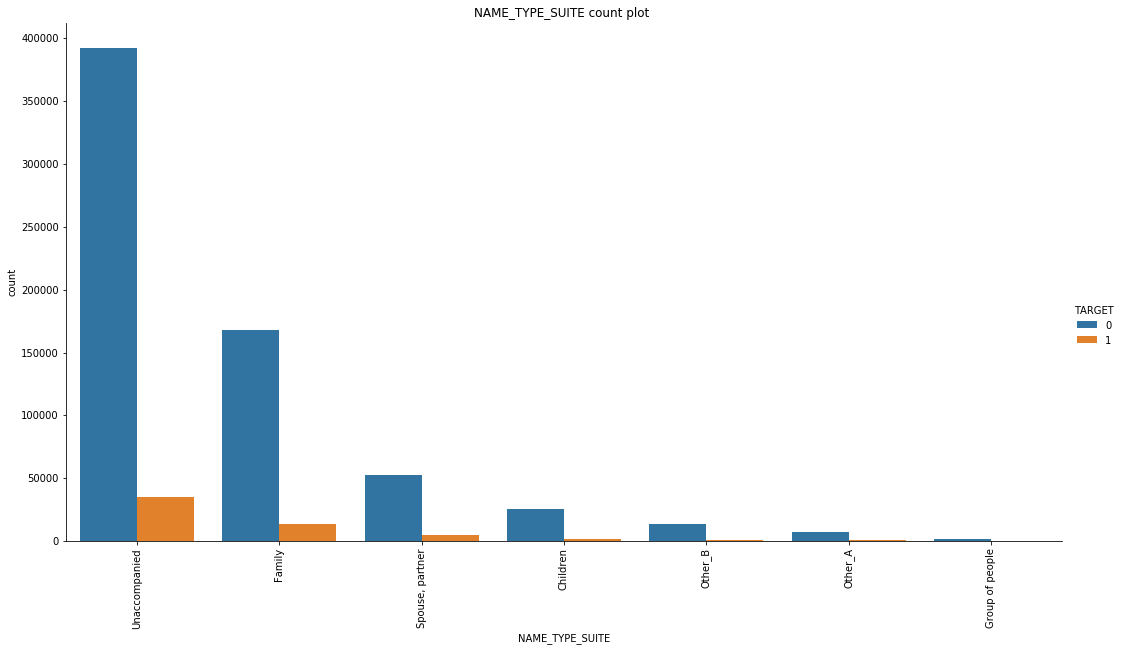



No of unique values: 8

Unique values present in NAME_TYPE_SUITE: {nan, 'Unaccompanied', 'Other_A', 'Group of people', 'Family', 'Children', 'Other_B', 'Spouse, partner'} 



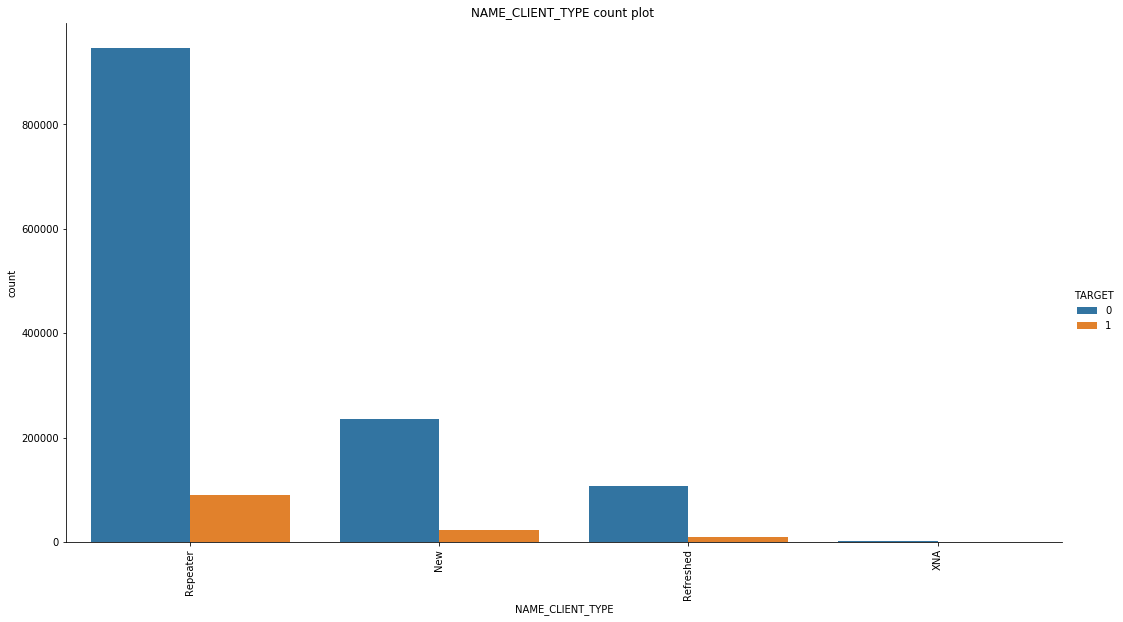



No of unique values: 5

Unique values present in NAME_CLIENT_TYPE: {nan, 'XNA', 'New', 'Repeater', 'Refreshed'} 



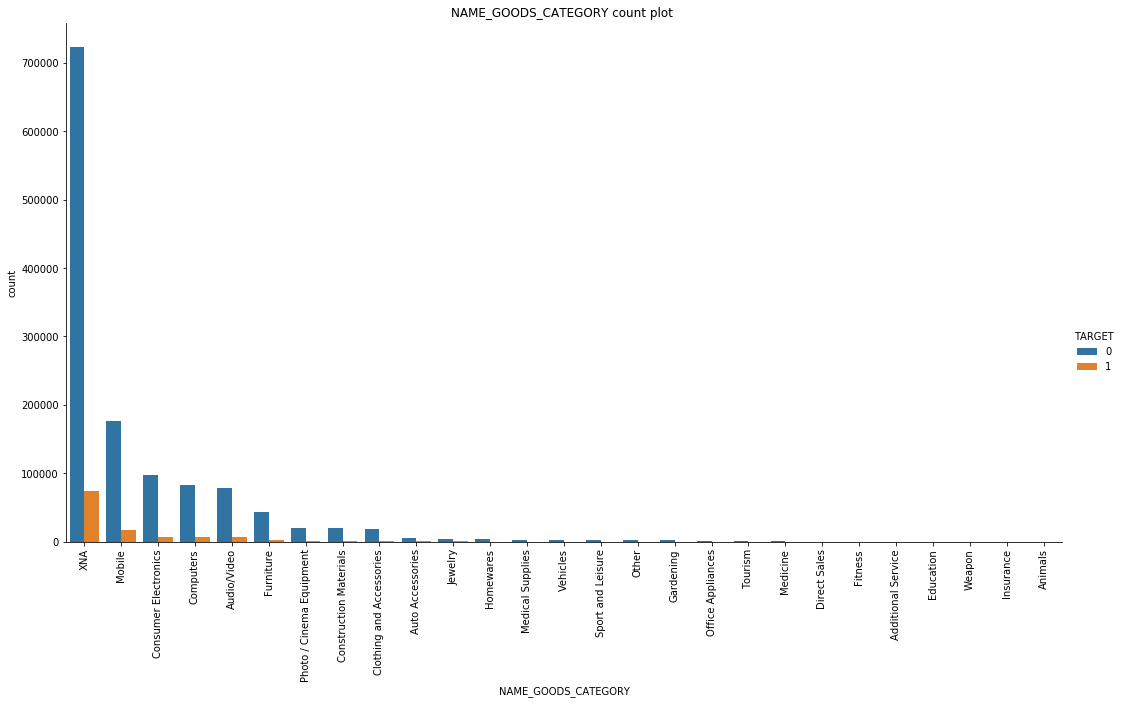



No of unique values: 28

Unique values present in NAME_GOODS_CATEGORY: {nan, 'Computers', 'Other', 'Direct Sales', 'Medicine', 'Sport and Leisure', 'Education', 'Audio/Video', 'Animals', 'Vehicles', 'Clothing and Accessories', 'Auto Accessories', 'Gardening', 'XNA', 'Weapon', 'Mobile', 'Consumer Electronics', 'Construction Materials', 'Office Appliances', 'Additional Service', 'Insurance', 'Furniture', 'Fitness', 'Tourism', 'Photo / Cinema Equipment', 'Medical Supplies', 'Homewares', 'Jewelry'} 



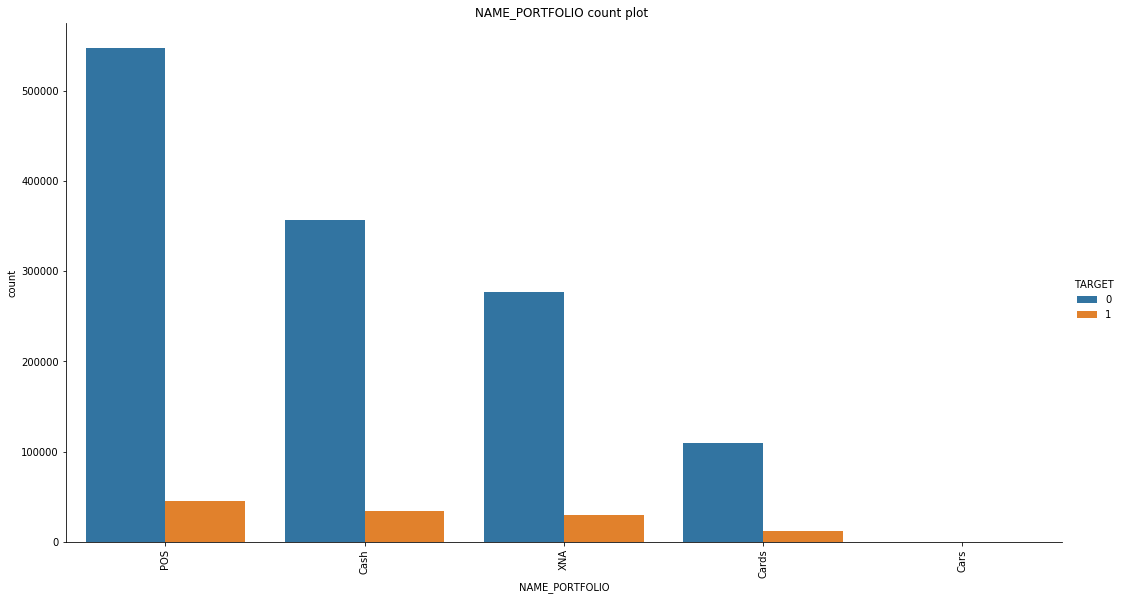



No of unique values: 6

Unique values present in NAME_PORTFOLIO: {nan, 'POS', 'Cash', 'XNA', 'Cars', 'Cards'} 



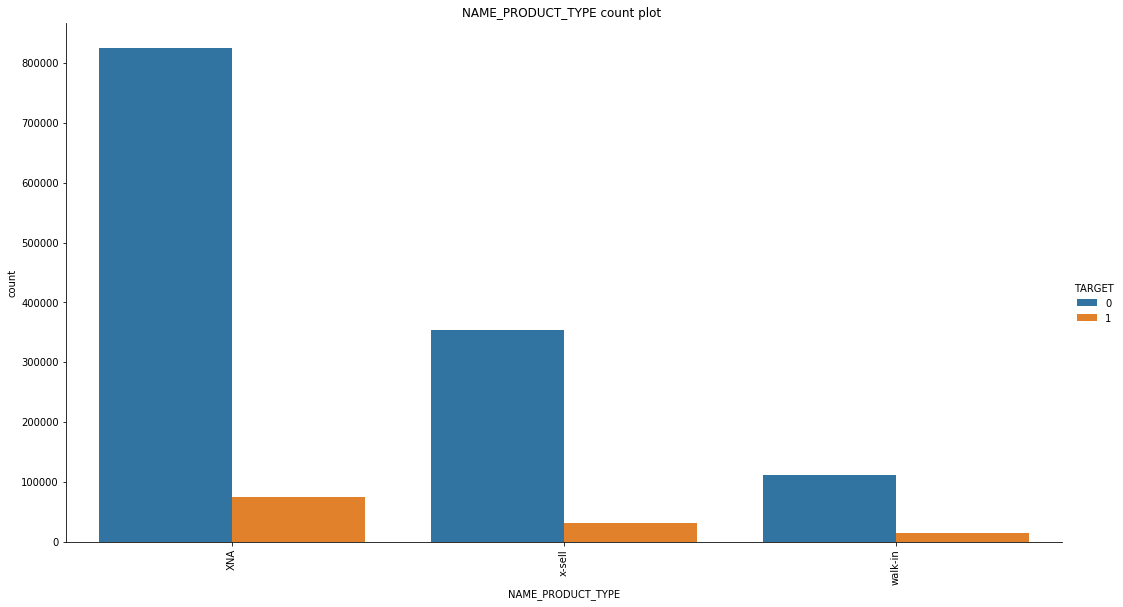



No of unique values: 4

Unique values present in NAME_PRODUCT_TYPE: {'walk-in', nan, 'XNA', 'x-sell'} 



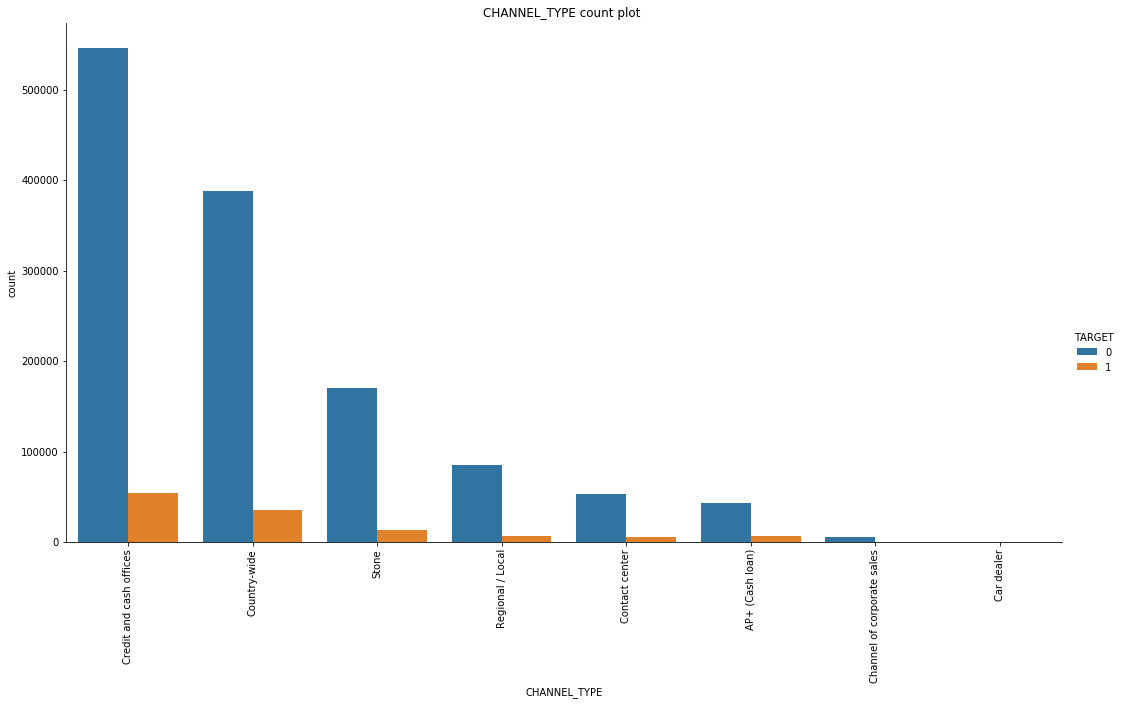



No of unique values: 9

Unique values present in CHANNEL_TYPE: {nan, 'Contact center', 'Channel of corporate sales', 'Credit and cash offices', 'AP+ (Cash loan)', 'Car dealer', 'Stone', 'Country-wide', 'Regional / Local'} 



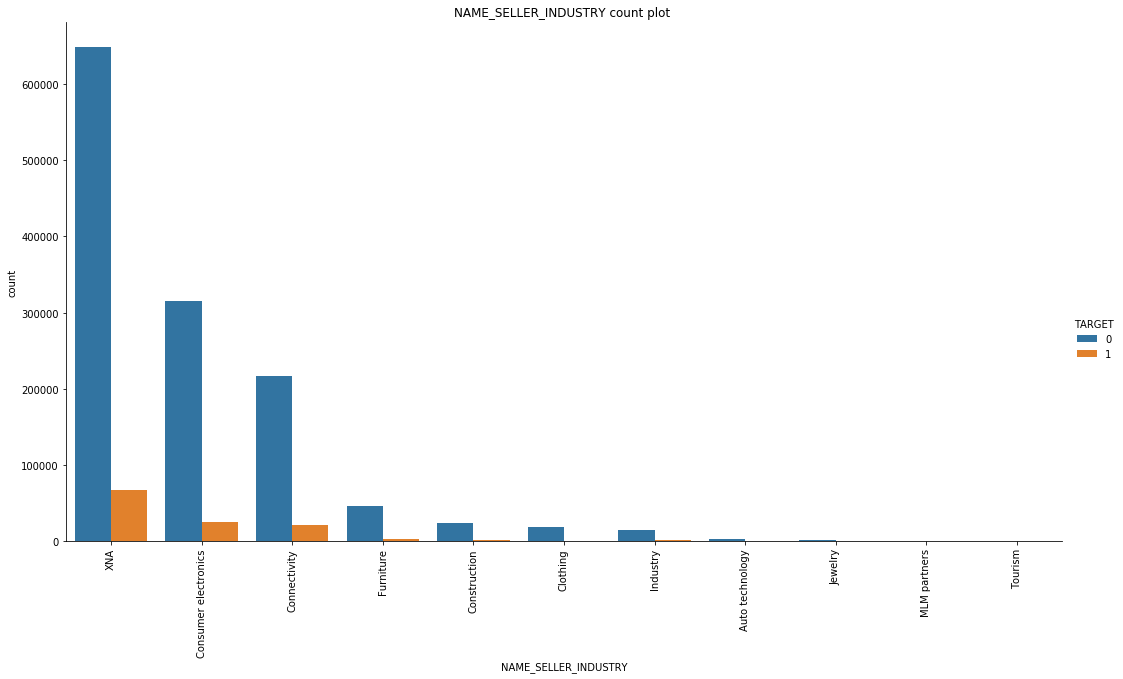



No of unique values: 12

Unique values present in NAME_SELLER_INDUSTRY: {nan, 'Furniture', 'Tourism', 'Construction', 'MLM partners', 'XNA', 'Industry', 'Connectivity', 'Auto technology', 'Consumer electronics', 'Clothing', 'Jewelry'} 



In [ ]:
for feature_name in previous_application_join_app.select_dtypes('object').columns.values:
    categorical_analysis(previous_application_join_app,feature_name)

<h3><u>Observation:</u></h3><br>
We can check for each plot for more details and the all the unique categories present in the dataset is given.